## Deep Learning Approach

#### Importing Libraries

In [39]:
import io 
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import math
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.regularizers import l2,l1
from keras.layers import BatchNormalization
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperas.utils import eval_hyperopt_space

**Import data function**

In [40]:
def data():
  _path_ = 'datasets/raw_signals/'
  activities = {1: 'WALKING',
  2: 'WALKING_UPSTAIRS',
  3: 'WALKING_DOWNSTAIRS',
  4: 'SITTING',
  5: 'STANDING',
  6: 'LAYING'
  }
  raw_signals_trainList = ['body_acc_x_train','body_acc_y_train','body_acc_z_train','body_gyro_x_train','body_gyro_y_train','body_gyro_z_train','total_acc_x_train','total_acc_y_train',
                      'total_acc_z_train']
  raw_signals_testList = ['body_acc_x_test','body_acc_y_test','body_acc_z_test','body_gyro_x_test','body_gyro_y_test','body_gyro_z_test','total_acc_x_test','total_acc_y_test',
                      'total_acc_z_test']
  def load_x(list,path):
    data = []
    for signal in list:
      data.append(pd.read_csv(path+signal+'.txt',delim_whitespace=True, header=None).to_numpy())
    
    return np.transpose(data, (1,2,0))

  def load_y(path, _type_):
    data = pd.read_csv(path + 'y_' + _type_ + '.txt',delim_whitespace=True, header=None)[0]
    return pd.get_dummies(data).to_numpy()

  X_train, X_test = load_x(raw_signals_trainList, _path_), load_x(raw_signals_testList, _path_)
  y_train, y_test = load_y(_path_, 'train'), load_y(_path_,'test')
  return X_train,y_train, X_test, y_test

**Confusion Matrix Plot function**

In [82]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}
labels=['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']
# Utility function to print the confusion matrix
def confusion_matrix_cnn(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    #return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])
    return metrics.confusion_matrix(Y_true, Y_pred)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [42]:
X_train,y_train, X_test, y_test = data()

**CNN with 2 Convolution Layer and 1 Fully Connected Layer**

In [ ]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train,y_train, epochs=100, batch_size=16,validation_data=(X_test, y_test))

In [ ]:
model.summary()

**CNN with 2 Convolution Layer and 1 Fully Connected Layer(with optimization)**

In [ ]:
def create_model_2C_1FC():
  model = Sequential()
  model.add(Conv1D(filters={{choice([16,32,42])}}, kernel_size={{choice([3,5,7])}}, activation='relu',kernel_initializer='he_uniform', kernel_regularizer=l2({{uniform(0,1.5)}})))
  model.add(Conv1D(filters={{choice([16,24,32])}}, kernel_size={{choice([3,5,7])}}, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2({{uniform(0,1.5)}})))

  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(50, activation='relu'))
  model.add(Dense(6, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(X_train,y_train, epochs=10, batch_size=16,validation_data=(X_test, y_test))

  score, acc = model.evaluate(X_test, y_test, verbose=0)
  print('Test accuracy:', acc)
  return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [ ]:
best_run, best_model = optim.minimize(model=create_model_2C_1FC,
                                          data=data,
                                          max_evals=1,
                                          algo=tpe.suggest,
                                          notebook_name='HAR_DL',
                                          trials=Trials())

In [ ]:
best_model.summary()

In [ ]:
_,test_acc = best_model.evaluate(X_test,y_test,verbose=0)
_,train_acc = best_model.evaluate(X_train,y_train,verbose=0)
print('Train_accuracy',train_acc,'test_accuracy',test_acc)

In [ ]:
plt.figure(figsize=(8,8))
cm = confusion_matrix_cnn(y_test, best_model.predict(X_test))
plot_confusion_matrix(cm, classes=labels, title='Confusion matrix')
plt.show()

In [ ]:
best_model.save('SavedModels/2Conv_1FC')

**CNN with 3 Convolution Layer and 1 Fully Connected Layer(with optimization)**

In [ ]:
def create_model_3C_1FC():
  model = Sequential()
  model.add(Conv1D(filters={{choice([16,32,42])}}, kernel_size={{choice([3,5,7])}}, activation='relu',kernel_initializer='he_uniform', kernel_regularizer=l2({{uniform(0,1.5)}})))
  model.add(Conv1D(filters={{choice([16,24,32])}}, kernel_size={{choice([3,5,7])}}, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2({{uniform(0,1.5)}})))
  model.add(Conv1D(filters={{choice([16,24,32])}}, kernel_size={{choice([3,5,7])}}, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2({{uniform(0,1.5)}})))

  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(50, activation='relu'))
  model.add(Dense(6, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(X_train,y_train, epochs=10, batch_size=16,validation_data=(X_test, y_test))

  score, acc = model.evaluate(X_test, y_test, verbose=0)
  print('Test accuracy:', acc)
  return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [ ]:
best_run, best_model = optim.minimize(model=create_model,
                                          data=data,
                                          max_evals=100,
                                          algo=tpe.suggest,
                                          notebook_name='HAR_DL',
                                          trials=Trials())

In [ ]:
best_model.summary()

In [ ]:
_,test_acc = best_model.evaluate(X_test,y_test,verbose=0)
_,train_acc = best_model.evaluate(X_train,y_train,verbose=0)
print('Train_accuracy',train_acc,'test_accuracy',test_acc)

In [ ]:
plt.figure(figsize=(8,8))
cm = confusion_matrix_cnn(y_test, best_model.predict(X_test))
plot_confusion_matrix(cm, classes=labels, title='Confusion matrix')
plt.show()

In [ ]:
best_model.save('SavedModels/3Conv_1FC')

**CNN with 3 Convolution Layer and 2 Fully Connected Layer(with optimization)**

In [ ]:
def create_model_3C_2FC():
  model = Sequential()
  model.add(Conv1D(filters={{choice([16,32,42])}}, kernel_size={{choice([3,5,7])}}, activation='relu',kernel_initializer='he_uniform', kernel_regularizer=l2({{uniform(0,1.5)}})))
  model.add(Conv1D(filters={{choice([16,24,32])}}, kernel_size={{choice([3,5,7])}}, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2({{uniform(0,1.5)}})))
  model.add(Conv1D(filters={{choice([16,24,32])}}, kernel_size={{choice([3,5,7])}}, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2({{uniform(0,1.5)}})))

  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense({{choice([32,64])}}, activation='relu'))
  model.add(Dense({{choice([32,64])}}, activation='relu'))
  model.add(Dense(6, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(X_train,y_train, epochs=10, batch_size=16,validation_data=(X_test, y_test))

  score, acc = model.evaluate(X_test, y_test, verbose=0)
  print('Test accuracy:', acc)
  return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [ ]:
best_run, best_model = optim.minimize(model=create_model_3C_2FC,
                                          data=data,
                                          max_evals=20,
                                          algo=tpe.suggest,
                                          notebook_name='HAR_DL',
                                          trials=Trials())

In [ ]:
best_model.summary()

In [ ]:
_,test_acc = best_model.evaluate(X_test,y_test,verbose=0)
_,train_acc = best_model.evaluate(X_train,y_train,verbose=0)
print('Train_accuracy',train_acc,'test_accuracy',test_acc)

In [ ]:
plt.figure(figsize=(8,8))
cm = confusion_matrix_cnn(y_test, best_model.predict(X_test))
plot_confusion_matrix(cm, classes=labels, title='Confusion matrix')
plt.show()

In [ ]:
best_model.save('SavedModels/3Conv_2FC')

**CNN with 2 Convolution Layer and 2 Fully Connected Layer(with optimization)**

In [ ]:
def create_model_2C_2FC():
  model = Sequential()
  model.add(Conv1D(filters={{choice([16,32,42])}}, kernel_size={{choice([3,5,7])}}, activation='relu',kernel_initializer='he_uniform', kernel_regularizer=l2({{uniform(0,1.5)}})))
  model.add(Conv1D(filters={{choice([16,24,32])}}, kernel_size={{choice([3,5,7])}}, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2({{uniform(0,1.5)}})))
  model.add(Dropout({{uniform(0.45,0.7)}}))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense({{choice([32,64])}}, activation='relu'))
  model.add(Dense({{choice([32,64])}}, activation='relu'))
  model.add(Dense(6, activation='softmax'))
 
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(X_train,y_train, epochs=10, batch_size=16,validation_data=(X_test, y_test))

  score, acc = model.evaluate(X_test, y_test, verbose=0)
  print('Test accuracy:', acc)
  return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [ ]:
best_run, best_model = optim.minimize(model=create_model_2C_2FC,
                                          data=data,
                                          max_evals=20,
                                          algo=tpe.suggest,
                                          notebook_name='HAR_DL',
                                          trials=Trials())

In [ ]:
best_model.summary()

In [ ]:
_,test_acc = best_model.evaluate(X_test,y_test,verbose=0)
_,train_acc = best_model.evaluate(X_train,y_train,verbose=0)
print('Train_accuracy',train_acc,'test_accuracy',test_acc)

In [ ]:
plt.figure(figsize=(8,8))
cm = confusion_matrix_cnn(y_test, best_model.predict(X_test))
plot_confusion_matrix(cm, classes=labels, title='Confusion matrix')
plt.show()

In [ ]:
best_model.save('SavedModels/2Conv_2FC')

# Divide and conquer approach

### Classifying data into Static and Dynamic activities

##### Data Processing

In [36]:
def data_binary():
  _path_ = 'datasets/raw_signals/'
  activities = {1: 'WALKING',
  2: 'WALKING_UPSTAIRS',
  3: 'WALKING_DOWNSTAIRS',
  4: 'SITTING',
  5: 'STANDING',
  6: 'LAYING'
  }
  raw_signals_trainList = ['body_acc_x_train','body_acc_y_train','body_acc_z_train','body_gyro_x_train','body_gyro_y_train','body_gyro_z_train','total_acc_x_train','total_acc_y_train',
                      'total_acc_z_train']
  raw_signals_testList = ['body_acc_x_test','body_acc_y_test','body_acc_z_test','body_gyro_x_test','body_gyro_y_test','body_gyro_z_test','total_acc_x_test','total_acc_y_test',
                      'total_acc_z_test']
  def load_x(list,path):
    data = []
    for signal in list:
      data.append(pd.read_csv(path+signal+'.txt',delim_whitespace=True, header=None).to_numpy())
    
    return np.transpose(data, (1,2,0))

  def load_y(path, _type_):
    data = pd.read_csv(path + 'y_' + _type_ + '.txt',delim_whitespace=True, header=None)[0]
    data[data<=3] = 0
    data[data>3] = 1
    return pd.get_dummies(data).to_numpy()

  X_train, X_test = load_x(raw_signals_trainList, _path_), load_x(raw_signals_testList, _path_)
  y_train, y_test = load_y(_path_, 'train'), load_y(_path_,'test')
  return X_train,y_train, X_test, y_test

X_train_binary,y_train_binary,X_test_binary,y_test_binary = data_binary()


In [ ]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.6))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

In [ ]:
adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])
model.fit(X_train_binary,y_train_binary, epochs=100, batch_size=16,validation_data=(X_test_binary, y_test_binary), verbose=1)

In [ ]:
_,test_acc = model.evaluate(X_test_binary,y_test_binary,verbose=0)
_,train_acc = model.evaluate(X_train_binary,y_train_binary,verbose=0)
print('Train_accuracy',train_acc,'test_accuracy',test_acc)

In [ ]:
model.save('SavedModels/dynamic_static_classification')

### Static Activities classification

##### Data Processing

In [2]:
def data_static():
  _path_ = 'datasets/raw_signals/'
  raw_signals_trainList = ['body_acc_x_train','body_acc_y_train','body_acc_z_train','body_gyro_x_train','body_gyro_y_train','body_gyro_z_train','total_acc_x_train','total_acc_y_train',
                      'total_acc_z_train']
  raw_signals_testList = ['body_acc_x_test','body_acc_y_test','body_acc_z_test','body_gyro_x_test','body_gyro_y_test','body_gyro_z_test','total_acc_x_test','total_acc_y_test',
                      'total_acc_z_test']
  def load_x(list,path):
    data = []
    for signal in list:
      data.append(pd.read_csv(path+signal+'.txt',delim_whitespace=True, header=None).to_numpy())
    
    return np.transpose(data, (1,2,0))

  def load_y(path, _type_):
    data = pd.read_csv(path + 'y_' + _type_ + '.txt',delim_whitespace=True, header=None)[0]
    tmp = data>3
    data = data[tmp]
    return pd.get_dummies(data).to_numpy(),tmp

  X_train_static, X_test_static = load_x(raw_signals_trainList, _path_), load_x(raw_signals_testList, _path_)
  y_train_static,tmp1 = load_y(_path_, 'train')
  y_test_static,tmp2 = load_y(_path_,'test')
  X_train_static = X_train_static[tmp1]
  X_test_static = X_test_static[tmp2]
  return X_train_static,y_train_static, X_test_static, y_test_static


In [3]:
X_train_static,y_train_static,X_test_static,y_test_static = data_static()

In [4]:
def static_cnn():
  model = Sequential()
  model.add(Conv1D(filters={{choice([16,32,42])}}, kernel_size={{choice([3,5,7])}}, activation='relu',kernel_initializer='he_uniform', kernel_regularizer=l2({{uniform(0,3)}})))
  model.add(Conv1D(filters={{choice([16,24,32])}}, kernel_size={{choice([3,5,7])}}, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2({{uniform(0,2)}})))
  model.add(Dropout({{uniform(0.3,0.7)}}))
  model.add(MaxPooling1D(pool_size={{choice([2,3,5])}}))
  model.add(Flatten())
  model.add(Dense({{choice([32,64])}}, activation='relu'))
  model.add(Dense(3, activation='softmax'))
    
  adam = Adam(lr={{uniform(0.00065,0.004)}})
  rmsprop = RMSprop(lr={{uniform(0.00065,0.004)}})
    
  choiceval = {{choice(['adam', 'rmsprop'])}}

  if choiceval == 'adam':
    optim = adam
  else:
    optim = rmsprop
    
  model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
  model.fit(X_train_static,y_train_static, epochs={{choice([25,30,35])}}, batch_size={{choice([16,32,64])}},validation_data=(X_test_static, y_test_static))
  
  score, acc = model.evaluate(X_test_static, y_test_static, verbose=2)
  print('Test accuracy:', acc)
  return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [5]:
trials = Trials()
best_run, best_model, space = optim.minimize(model=static_cnn,
                                          data=data_static,
                                          max_evals=30,
                                          algo=tpe.suggest,rseed = 0, 
                                          notebook_name='HAR_DL',
                                          trials=trials,
                                          return_space = True)

>>> Imports:
#coding=utf-8

try:
    import io
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import itertools
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import math
except:
    pass

try:
    from sklearn import metrics
except:
    pass

try:
    from sklearn.metrics import confusion_matrix
except:
    pass

try:
    from keras.optimizers import Adam
except:
    pass

try:
    from keras.optimizers import RMSprop
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import Dense
except:
    pass

try:
    from keras.layers import Flatten
except:
    pass

try:
    from keras.layers import Dropout
except:
    pass

try:
    from keras.layers.convolutional import Conv1D
except:
    pass

try:
    from keras.layers.convolutional import MaxPooling1D
except:
    pass

try:
    from keras.regularizers import l2, l1
except:


 - ETA: 0s - loss: 110.9482 - accuracy: 0.8118                                                                         
                                                                                                                      
 50/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 105.0123 - accuracy: 0.8225                                                                         
                                                                                                                      
 55/128 [===========>..................]                                                                               
 - ETA: 0s - loss: 100.3966 - accuracy: 0.8273                                                                         
                                                                                                                      
 59/128 [============>.................]   

 37/128 [=======>......................]                                                                               
 - ETA: 0s - loss: 3.1580 - accuracy: 0.8429                                                                           
                                                                                                                      
 43/128 [=========>....................]                                                                               
 - ETA: 0s - loss: 2.8809 - accuracy: 0.8474                                                                           
                                                                                                                      
 49/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 2.6560 - accuracy: 0.8386                                                                           
                                          

                                                                                                                      
 36/128 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.4436 - accuracy: 0.8663                                                                           
                                                                                                                      
 42/128 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.4332 - accuracy: 0.8698                                                                           
                                                                                                                      
 48/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.4449 - accuracy: 0.860

 - ETA: 0s - loss: 0.4074 - accuracy: 0.8656                                                                           
                                                                                                                      
 35/128 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.3964 - accuracy: 0.8732                                                                           
                                                                                                                      
 40/128 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.4019 - accuracy: 0.8719                                                                           
                                                                                                                      
 45/128 [=========>....................]   

 22/128 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.3623 - accuracy: 0.8679                                                                           
                                                                                                                      
 27/128 [=====>........................]                                                                               
 - ETA: 0s - loss: 0.3636 - accuracy: 0.8669                                                                           
                                                                                                                      
 32/128 [======>.......................]                                                                               
 - ETA: 0s - loss: 0.3571 - accuracy: 0.8779                                                                           
                                          

                                                                                                                      
 13/128 [==>...........................]                                                                               
 - ETA: 0s - loss: 0.3263 - accuracy: 0.8966                                                                           
                                                                                                                      
 19/128 [===>..........................]                                                                               
 - ETA: 0s - loss: 0.3592 - accuracy: 0.8766                                                                           
                                                                                                                      
 25/128 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.3491 - accuracy: 0.886

 - ETA: 0s - loss: 0.5629 - accuracy: 0.7812                                                                           
                                                                                                                      
  7/128 [>.............................]                                                                               
 - ETA: 0s - loss: 0.4335 - accuracy: 0.8393                                                                           
                                                                                                                      
 13/128 [==>...........................]                                                                               
 - ETA: 0s - loss: 0.3732 - accuracy: 0.8774                                                                           
                                                                                                                      
 19/128 [===>..........................]   

  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.5390 - accuracy: 0.7188                                                                           
                                                                                                                      
  7/128 [>.............................]                                                                               
 - ETA: 0s - loss: 0.5222 - accuracy: 0.7768                                                                           
                                                                                                                      
 11/128 [=>............................]                                                                               
 - ETA: 1s - loss: 0.4342 - accuracy: 0.8267                                                                           
                                          

                                                                                                                      
126/128 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3661 - accuracy: 0.8760                                                                           
                                                                                                                      
128/128 [==============================]                                                                               
 - 1s 11ms/step - loss: 0.3649 - accuracy: 0.8766 - val_loss: 0.5032 - val_accuracy: 0.8295                            

Epoch 9/30                                                                                                             
  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.2194 - accuracy: 0.9

 - ETA: 0s - loss: 0.3574 - accuracy: 0.8739                                                                           
                                                                                                                      
119/128 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3624 - accuracy: 0.8732                                                                           
                                                                                                                      
125/128 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3601 - accuracy: 0.8755                                                                           
                                                                                                                      
128/128 [==============================]   

109/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3525 - accuracy: 0.8847                                                                           
                                                                                                                      
114/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3502 - accuracy: 0.8865                                                                           
                                                                                                                      
121/128 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3540 - accuracy: 0.8848                                                                           
                                          

                                                                                                                      
102/128 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3946 - accuracy: 0.8655                                                                           
                                                                                                                      
108/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3899 - accuracy: 0.8672                                                                           
                                                                                                                      
114/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3847 - accuracy: 0.870

 - ETA: 0s - loss: 0.3429 - accuracy: 0.8750                                                                           
                                                                                                                      
 76/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.3441 - accuracy: 0.8750                                                                           
                                                                                                                      
 79/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3440 - accuracy: 0.8754                                                                           
                                                                                                                      
 85/128 [==================>...........]   

 64/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3691 - accuracy: 0.8721                                                                           
                                                                                                                      
 70/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3679 - accuracy: 0.8710                                                                           
                                                                                                                      
 76/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.3630 - accuracy: 0.8742                                                                           
                                          

                                                                                                                      
 57/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3576 - accuracy: 0.8761                                                                           
                                                                                                                      
 63/128 [=============>................]                                                                               
 - ETA: 0s - loss: 0.3600 - accuracy: 0.8745                                                                           
                                                                                                                      
 69/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3594 - accuracy: 0.874

 - ETA: 0s - loss: 0.3424 - accuracy: 0.8824                                                                           
                                                                                                                      
 47/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.3505 - accuracy: 0.8790                                                                           
                                                                                                                      
 51/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.3715 - accuracy: 0.8750                                                                           
                                                                                                                      
 56/128 [============>.................]   

 28/128 [=====>........................]                                                                               
 - ETA: 0s - loss: 0.3691 - accuracy: 0.8705                                                                           
                                                                                                                      
 36/128 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.3527 - accuracy: 0.8785                                                                           
                                                                                                                      
 41/128 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.3494 - accuracy: 0.8803                                                                           
                                          

Epoch 17/30                                                                                                            
  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.2745 - accuracy: 0.9375                                                                           
                                                                                                                      
  6/128 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3943 - accuracy: 0.8594                                                                           
                                                                                                                      
 11/128 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3487 - accuracy: 0.88

 - ETA: 0s - loss: 0.3602 - accuracy: 0.8779                                                                           
                                                                                                                      
112/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3597 - accuracy: 0.8764                                                                           
                                                                                                                      
117/128 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3587 - accuracy: 0.8766                                                                           
                                                                                                                      
122/128 [===========================>..]   

 91/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3391 - accuracy: 0.8771                                                                           
                                                                                                                      
 97/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3327 - accuracy: 0.8811                                                                           
                                                                                                                      
101/128 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3427 - accuracy: 0.8765                                                                           
                                          

                                                                                                                      
 80/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3377 - accuracy: 0.8813                                                                           
                                                                                                                      
 87/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3415 - accuracy: 0.8786                                                                           
                                                                                                                      
 93/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3375 - accuracy: 0.880

 - ETA: 0s - loss: 0.3312 - accuracy: 0.8854                                                                           
                                                                                                                      
 58/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3233 - accuracy: 0.8885                                                                           
                                                                                                                      
 63/128 [=============>................]                                                                               
 - ETA: 0s - loss: 0.3282 - accuracy: 0.8854                                                                           
                                                                                                                      
 68/128 [==============>...............]   

 35/128 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.3445 - accuracy: 0.8643                                                                           
                                                                                                                      
 39/128 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.3433 - accuracy: 0.8638                                                                           
                                                                                                                      
 45/128 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.3437 - accuracy: 0.8681                                                                           
                                          

                                                                                                                      
 24/128 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.3330 - accuracy: 0.8841                                                                           
                                                                                                                      
 29/128 [=====>........................]                                                                               
 - ETA: 0s - loss: 0.3184 - accuracy: 0.8901                                                                           
                                                                                                                      
 35/128 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.3084 - accuracy: 0.891

 - ETA: 0s - loss: 0.3325 - accuracy: 0.8819                                                                           
                                                                                                                      
128/128 [==============================]                                                                               
 - 2s 12ms/step - loss: 0.3325 - accuracy: 0.8820 - val_loss: 0.4021 - val_accuracy: 0.8769                            

Epoch 23/30                                                                                                            
  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.5234 - accuracy: 0.8438                                                                           
                                                                                                                      
  5/128 [>.............................] 

 88/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3366 - accuracy: 0.8832                                                                           
                                                                                                                      
 92/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3492 - accuracy: 0.8781                                                                           
                                                                                                                      
 96/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3469 - accuracy: 0.8796                                                                           
                                          

                                                                                                                      
 50/128 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.3485 - accuracy: 0.8725                                                                           
                                                                                                                      
 54/128 [===========>..................]                                                                               
 - ETA: 1s - loss: 0.3461 - accuracy: 0.8756                                                                           
                                                                                                                      
 58/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3390 - accuracy: 0.879

 - 2s 16ms/step - loss: 0.3397 - accuracy: 0.8758 - val_loss: 0.3664 - val_accuracy: 0.8788                            

Epoch 25/30                                                                                                            
  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.3207 - accuracy: 0.8750                                                                           
                                                                                                                      
  5/128 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3866 - accuracy: 0.8500                                                                           
                                                                                                                      
  9/128 [=>............................] 

 88/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3389 - accuracy: 0.8786                                                                           
                                                                                                                      
 92/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3440 - accuracy: 0.8757                                                                           
                                                                                                                      
 95/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3412 - accuracy: 0.8766                                                                           
                                          

                                                                                                                      
 55/128 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.3420 - accuracy: 0.8818                                                                           
                                                                                                                      
 60/128 [=============>................]                                                                               
 - ETA: 0s - loss: 0.3399 - accuracy: 0.8839                                                                           
                                                                                                                      
 65/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3323 - accuracy: 0.887

 - ETA: 1s - loss: 0.3545 - accuracy: 0.8705                                                                           
                                                                                                                      
 18/128 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.3520 - accuracy: 0.8681                                                                           
                                                                                                                      
 21/128 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.3537 - accuracy: 0.8705                                                                           
                                                                                                                      
 25/128 [====>.........................]   

105/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3471 - accuracy: 0.8729                                                                           
                                                                                                                      
108/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3455 - accuracy: 0.8738                                                                           
                                                                                                                      
112/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3437 - accuracy: 0.8756                                                                           
                                          

                                                                                                                      
 57/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3253 - accuracy: 0.8893                                                                           
                                                                                                                      
 61/128 [=============>................]                                                                               
 - ETA: 0s - loss: 0.3419 - accuracy: 0.8817                                                                           
                                                                                                                      
 64/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3393 - accuracy: 0.881

 - ETA: 1s - loss: 0.3519 - accuracy: 0.8844                                                                           
                                                                                                                      
 14/128 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3619 - accuracy: 0.8795                                                                           
                                                                                                                      
 19/128 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.3571 - accuracy: 0.8766                                                                           
                                                                                                                      
 23/128 [====>.........................]   

106/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3342 - accuracy: 0.8847                                                                           
                                                                                                                      
111/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3328 - accuracy: 0.8840                                                                           
                                                                                                                      
116/128 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3327 - accuracy: 0.8839                                                                           
                                          

                                                                                                                      
 71/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3500 - accuracy: 0.8750                                                                           
                                                                                                                      
 75/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.3476 - accuracy: 0.8763                                                                           
                                                                                                                      
 78/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3472 - accuracy: 0.876

 - ETA: 1s - loss: 176.5851 - accuracy: 0.8009                                                                         
                                                                                                                      
 31/128 [======>.......................]                                                                               
 - ETA: 1s - loss: 168.3477 - accuracy: 0.8155                                                                         
                                                                                                                      
 35/128 [=======>......................]                                                                               
 - ETA: 1s - loss: 160.7370 - accuracy: 0.8268                                                                         
                                                                                                                      
 39/128 [========>.....................]   

119/128 [==========================>...]                                                                               
 - ETA: 0s - loss: 77.7096 - accuracy: 0.8461                                                                          
                                                                                                                       
123/128 [===========================>..]                                                                               
 - ETA: 0s - loss: 75.6423 - accuracy: 0.8471                                                                          
                                                                                                                       
127/128 [============================>.]                                                                               
 - ETA: 0s - loss: 73.6665 - accuracy: 0.8479                                                                          
                                        

                                                                                                                      
 76/128 [================>.............]                                                                               
 - ETA: 0s - loss: 5.6574 - accuracy: 0.8643                                                                           
                                                                                                                      
 79/128 [=================>............]                                                                               
 - ETA: 0s - loss: 5.5168 - accuracy: 0.8671                                                                           
                                                                                                                      
 81/128 [=================>............]                                                                               
 - ETA: 0s - loss: 5.4269 - accuracy: 0.866

 - ETA: 1s - loss: 0.6962 - accuracy: 0.8750                                                                           
                                                                                                                      
 20/128 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.7077 - accuracy: 0.8609                                                                           
                                                                                                                      
 23/128 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.7109 - accuracy: 0.8505                                                                           
                                                                                                                      
 27/128 [=====>........................]   

113/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.5423 - accuracy: 0.8664                                                                           
                                                                                                                      
117/128 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.5387 - accuracy: 0.8665                                                                           
                                                                                                                      
121/128 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.5345 - accuracy: 0.8670                                                                           
                                          

                                                                                                                      
 72/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.4466 - accuracy: 0.8668                                                                           
                                                                                                                      
 76/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.4480 - accuracy: 0.8627                                                                           
                                                                                                                      
 80/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.4459 - accuracy: 0.862

 - ETA: 1s - loss: 0.3609 - accuracy: 0.8913                                                                           
                                                                                                                      
 27/128 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3695 - accuracy: 0.8831                                                                           
                                                                                                                      
 31/128 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.3646 - accuracy: 0.8901                                                                           
                                                                                                                      
 35/128 [=======>......................]   

106/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.4150 - accuracy: 0.8797                                                                           
                                                                                                                      
110/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.4123 - accuracy: 0.8813                                                                           
                                                                                                                      
114/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.4125 - accuracy: 0.8810                                                                           
                                          

                                                                                                                      
 60/128 [=============>................]                                                                               
 - ETA: 0s - loss: 0.4002 - accuracy: 0.8745                                                                           
                                                                                                                      
 64/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.4001 - accuracy: 0.8770                                                                           
                                                                                                                      
 68/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.4032 - accuracy: 0.876

 - ETA: 1s - loss: 0.4872 - accuracy: 0.8302                                                                           
                                                                                                                      
 27/128 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.4753 - accuracy: 0.8356                                                                           
                                                                                                                      
 31/128 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.4591 - accuracy: 0.8488                                                                           
                                                                                                                      
 35/128 [=======>......................]   

114/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.4037 - accuracy: 0.8712                                                                           
                                                                                                                      
119/128 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.4052 - accuracy: 0.8721                                                                           
                                                                                                                      
124/128 [============================>.]                                                                               
 - ETA: 0s - loss: 0.4051 - accuracy: 0.8735                                                                           
                                          

                                                                                                                      
 92/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3537 - accuracy: 0.8927                                                                           
                                                                                                                      
 97/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3531 - accuracy: 0.8927                                                                           
                                                                                                                      
102/128 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3483 - accuracy: 0.894

 - ETA: 0s - loss: 0.3681 - accuracy: 0.8683                                                                           
                                                                                                                      
 55/128 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.3693 - accuracy: 0.8676                                                                           
                                                                                                                      
 59/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3675 - accuracy: 0.8697                                                                           
                                                                                                                      
 64/128 [==============>...............]   

  9/128 [=>............................]                                                                               
 - ETA: 1s - loss: 0.2956 - accuracy: 0.9028                                                                           
                                                                                                                      
 13/128 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.2881 - accuracy: 0.9111                                                                           
                                                                                                                      
 17/128 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.2819 - accuracy: 0.9136                                                                           
                                          

                                                                                                                      
102/128 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3463 - accuracy: 0.8866                                                                           
                                                                                                                      
106/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3449 - accuracy: 0.8877                                                                           
                                                                                                                      
110/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3438 - accuracy: 0.887

 - ETA: 0s - loss: 0.3329 - accuracy: 0.8834                                                                           
                                                                                                                      
 67/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3325 - accuracy: 0.8843                                                                           
                                                                                                                      
 71/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3323 - accuracy: 0.8834                                                                           
                                                                                                                      
 75/128 [================>.............]   

 33/128 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.3267 - accuracy: 0.8939                                                                           
                                                                                                                      
 37/128 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.3294 - accuracy: 0.8953                                                                           
                                                                                                                      
 42/128 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.3352 - accuracy: 0.8891                                                                           
                                          

Epoch 13/25                                                                                                            
  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.2916 - accuracy: 0.9375                                                                           
                                                                                                                      
  5/128 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3900 - accuracy: 0.9062                                                                           
                                                                                                                      
  9/128 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3669 - accuracy: 0.89

 - ETA: 0s - loss: 0.3146 - accuracy: 0.9086                                                                           
                                                                                                                      
 98/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3182 - accuracy: 0.9066                                                                           
                                                                                                                      
102/128 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3201 - accuracy: 0.9062                                                                           
                                                                                                                      
106/128 [=======================>......]   

 49/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.3119 - accuracy: 0.8973                                                                           
                                                                                                                      
 53/128 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.3133 - accuracy: 0.8974                                                                           
                                                                                                                      
 56/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3180 - accuracy: 0.8945                                                                           
                                          

                                                                                                                      
  9/128 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3722 - accuracy: 0.8715                                                                           
                                                                                                                      
 13/128 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3676 - accuracy: 0.8726                                                                           
                                                                                                                      
 17/128 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3743 - accuracy: 0.871

 - ETA: 0s - loss: 0.3851 - accuracy: 0.8747                                                                           
                                                                                                                      
 99/128 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3877 - accuracy: 0.8737                                                                           
                                                                                                                      
102/128 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3872 - accuracy: 0.8744                                                                           
                                                                                                                      
105/128 [=======================>......]   

 50/128 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.3229 - accuracy: 0.8838                                                                           
                                                                                                                      
 54/128 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.3208 - accuracy: 0.8860                                                                           
                                                                                                                      
 58/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3193 - accuracy: 0.8863                                                                           
                                          

                                                                                                                      
 20/128 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.2599 - accuracy: 0.9266                                                                           
                                                                                                                      
 24/128 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.2671 - accuracy: 0.9245                                                                           
                                                                                                                      
 28/128 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.2729 - accuracy: 0.920

 - ETA: 0s - loss: 0.2996 - accuracy: 0.8996                                                                           
                                                                                                                      
121/128 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.2997 - accuracy: 0.8993                                                                           
                                                                                                                      
125/128 [============================>.]                                                                               
 - ETA: 0s - loss: 0.2982 - accuracy: 0.8997                                                                           
                                                                                                                      
128/128 [==============================]   

 69/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3382 - accuracy: 0.8872                                                                           
                                                                                                                      
 72/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3350 - accuracy: 0.8906                                                                           
                                                                                                                      
 76/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.3323 - accuracy: 0.8910                                                                           
                                          

                                                                                                                      
 23/128 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.3367 - accuracy: 0.8777                                                                           
                                                                                                                      
 27/128 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3351 - accuracy: 0.8796                                                                           
                                                                                                                      
 31/128 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.3407 - accuracy: 0.877

 - ETA: 0s - loss: 0.3194 - accuracy: 0.8932                                                                           
                                                                                                                      
120/128 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3153 - accuracy: 0.8948                                                                           
                                                                                                                      
124/128 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3175 - accuracy: 0.8939                                                                           
                                                                                                                      
128/128 [==============================]   

 70/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3077 - accuracy: 0.8969                                                                           
                                                                                                                      
 74/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.3060 - accuracy: 0.8986                                                                           
                                                                                                                      
 78/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3100 - accuracy: 0.8970                                                                           
                                          

                                                                                                                      
 26/128 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3150 - accuracy: 0.8966                                                                           
                                                                                                                      
 31/128 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.3247 - accuracy: 0.8901                                                                           
                                                                                                                      
 36/128 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.3302 - accuracy: 0.889

 - ETA: 0s - loss: 0.3556 - accuracy: 0.8832                                                                           
                                                                                                                      
114/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3548 - accuracy: 0.8832                                                                           
                                                                                                                      
118/128 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3529 - accuracy: 0.8840                                                                           
                                                                                                                      
122/128 [===========================>..]   

 61/128 [=============>................]                                                                               
 - ETA: 1s - loss: 0.3139 - accuracy: 0.8934                                                                           
                                                                                                                      
 65/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3085 - accuracy: 0.8962                                                                           
                                                                                                                      
 69/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3089 - accuracy: 0.8949                                                                           
                                          

                                                                                                                      
 20/128 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.2693 - accuracy: 0.9219                                                                           
                                                                                                                      
 24/128 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.2689 - accuracy: 0.9180                                                                           
                                                                                                                      
 29/128 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.2791 - accuracy: 0.908

 - ETA: 0s - loss: 0.3121 - accuracy: 0.8971                                                                           
                                                                                                                      
103/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3110 - accuracy: 0.8971                                                                           
                                                                                                                      
107/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3136 - accuracy: 0.8949                                                                           
                                                                                                                      
111/128 [=========================>....]   

 58/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.4890 - accuracy: 0.8631                                                                           
                                                                                                                      
 62/128 [=============>................]                                                                               
 - ETA: 0s - loss: 0.4779 - accuracy: 0.8659                                                                           
                                                                                                                      
 66/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.4674 - accuracy: 0.8698                                                                           
                                          

                                                                                                                      
 13/128 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.2829 - accuracy: 0.9062                                                                           
                                                                                                                      
 17/128 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.2840 - accuracy: 0.9044                                                                           
                                                                                                                      
 20/128 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.2804 - accuracy: 0.906

 - ETA: 0s - loss: 0.3252 - accuracy: 0.8913                                                                           
                                                                                                                      
 99/128 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3243 - accuracy: 0.8914                                                                           
                                                                                                                      
104/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3225 - accuracy: 0.8921                                                                           
                                                                                                                      
109/128 [========================>.....]   

125/255 [=============>................]                                                                               
 - ETA: 0s - loss: 8.1929 - accuracy: 0.8615                                                                           
                                                                                                                      
135/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 7.6319 - accuracy: 0.8574                                                                           
                                                                                                                      
146/255 [================>.............]                                                                               
 - ETA: 0s - loss: 7.1038 - accuracy: 0.8536                                                                           
                                          

                                                                                                                      
112/255 [============>.................]                                                                               
 - ETA: 0s - loss: 0.4245 - accuracy: 0.8672                                                                           
                                                                                                                      
123/255 [=============>................]                                                                               
 - ETA: 0s - loss: 0.4187 - accuracy: 0.8684                                                                           
                                                                                                                      
134/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.4320 - accuracy: 0.862

 - ETA: 0s - loss: 0.3327 - accuracy: 0.8925                                                                           
                                                                                                                      
 85/255 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.3339 - accuracy: 0.8941                                                                           
                                                                                                                      
 95/255 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.3407 - accuracy: 0.8901                                                                           
                                                                                                                      
106/255 [===========>..................]   

 46/255 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.3061 - accuracy: 0.9022                                                                           
                                                                                                                      
 57/255 [=====>........................]                                                                               
 - ETA: 0s - loss: 0.3102 - accuracy: 0.9024                                                                           
                                                                                                                      
 68/255 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.3177 - accuracy: 0.8980                                                                           
                                          

                                                                                                                      
 22/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3874 - accuracy: 0.8750                                                                           
                                                                                                                      
 32/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3536 - accuracy: 0.8926                                                                           
                                                                                                                      
 43/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.3431 - accuracy: 0.893

 - 1s 5ms/step - loss: 0.3308 - accuracy: 0.8908 - val_loss: 0.3951 - val_accuracy: 0.8827                             

Epoch 6/30                                                                                                             
  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.3084 - accuracy: 0.8750                                                                           
                                                                                                                      
 11/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3322 - accuracy: 0.9148                                                                           
                                                                                                                      
 19/255 [=>............................] 

212/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3540 - accuracy: 0.8915                                                                           
                                                                                                                      
222/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3545 - accuracy: 0.8902                                                                           
                                                                                                                      
233/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3581 - accuracy: 0.8863                                                                           
                                          

                                                                                                                      
205/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3199 - accuracy: 0.8915                                                                           
                                                                                                                      
217/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3180 - accuracy: 0.8926                                                                           
                                                                                                                      
229/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3129 - accuracy: 0.895

 - ETA: 0s - loss: 0.3288 - accuracy: 0.8937                                                                           
                                                                                                                      
198/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3337 - accuracy: 0.8920                                                                           
                                                                                                                      
209/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3348 - accuracy: 0.8914                                                                           
                                                                                                                      
220/255 [========================>.....]   

178/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3733 - accuracy: 0.8725                                                                           
                                                                                                                      
188/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3723 - accuracy: 0.8733                                                                           
                                                                                                                      
193/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3714 - accuracy: 0.8744                                                                           
                                          

                                                                                                                      
126/255 [=============>................]                                                                               
 - ETA: 0s - loss: 0.2977 - accuracy: 0.8968                                                                           
                                                                                                                      
135/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2976 - accuracy: 0.8977                                                                           
                                                                                                                      
144/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3012 - accuracy: 0.894

 - ETA: 0s - loss: 0.3256 - accuracy: 0.8938                                                                           
                                                                                                                      
 92/255 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.3216 - accuracy: 0.8981                                                                           
                                                                                                                      
100/255 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.3224 - accuracy: 0.8956                                                                           
                                                                                                                      
107/255 [===========>..................]   

248/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3116 - accuracy: 0.8934                                                                           
                                                                                                                      
255/255 [==============================]                                                                               
 - 2s 7ms/step - loss: 0.3126 - accuracy: 0.8923 - val_loss: 0.4425 - val_accuracy: 0.8224                             

Epoch 12/30                                                                                                            
  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.5489 - accuracy: 0.7500                                                                           
                                        

                                                                                                                      
206/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3176 - accuracy: 0.9002                                                                           
                                                                                                                      
213/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3188 - accuracy: 0.8996                                                                           
                                                                                                                      
219/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3153 - accuracy: 0.901

 - ETA: 0s - loss: 0.2979 - accuracy: 0.8953                                                                           
                                                                                                                      
119/255 [=============>................]                                                                               
 - ETA: 0s - loss: 0.3010 - accuracy: 0.8950                                                                           
                                                                                                                      
126/255 [=============>................]                                                                               
 - ETA: 0s - loss: 0.2988 - accuracy: 0.8953                                                                           
                                                                                                                      
134/255 [==============>...............]   

 28/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.4477 - accuracy: 0.8594                                                                           
                                                                                                                      
 37/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.4648 - accuracy: 0.8463                                                                           
                                                                                                                      
 44/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.4463 - accuracy: 0.8537                                                                           
                                          

                                                                                                                      
213/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3485 - accuracy: 0.8882                                                                           
                                                                                                                      
221/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3461 - accuracy: 0.8897                                                                           
                                                                                                                      
229/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3445 - accuracy: 0.889

 - ETA: 0s - loss: 0.3011 - accuracy: 0.8902                                                                           
                                                                                                                      
123/255 [=============>................]                                                                               
 - ETA: 0s - loss: 0.3041 - accuracy: 0.8892                                                                           
                                                                                                                      
129/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3018 - accuracy: 0.8900                                                                           
                                                                                                                      
137/255 [===============>..............]   

 17/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.2676 - accuracy: 0.9118                                                                           
                                                                                                                      
 25/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3129 - accuracy: 0.8875                                                                           
                                                                                                                      
 32/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3139 - accuracy: 0.8828                                                                           
                                          

                                                                                                                      
198/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3200 - accuracy: 0.8920                                                                           
                                                                                                                      
207/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3164 - accuracy: 0.8931                                                                           
                                                                                                                      
217/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3127 - accuracy: 0.894

 - ETA: 0s - loss: 0.2984 - accuracy: 0.8966                                                                           
                                                                                                                      
125/255 [=============>................]                                                                               
 - ETA: 0s - loss: 0.2930 - accuracy: 0.8995                                                                           
                                                                                                                      
134/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2903 - accuracy: 0.9002                                                                           
                                                                                                                      
143/255 [===============>..............]   

  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.1417 - accuracy: 1.0000                                                                           
                                                                                                                      
 12/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.2333 - accuracy: 0.9323                                                                           
                                                                                                                      
 22/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.2550 - accuracy: 0.9205                                                                           
                                          

                                                                                                                      
203/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.2969 - accuracy: 0.8959                                                                           
                                                                                                                      
211/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.2949 - accuracy: 0.8966                                                                           
                                                                                                                      
219/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2971 - accuracy: 0.895

 - ETA: 0s - loss: 0.3613 - accuracy: 0.8865                                                                           
                                                                                                                      
167/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3607 - accuracy: 0.8874                                                                           
                                                                                                                      
177/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3604 - accuracy: 0.8867                                                                           
                                                                                                                      
188/255 [=====================>........]   

 83/255 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.3142 - accuracy: 0.8946                                                                           
                                                                                                                      
 90/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.3133 - accuracy: 0.8931                                                                           
                                                                                                                      
 98/255 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.3073 - accuracy: 0.8960                                                                           
                                          

                                                                                                                      
236/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3086 - accuracy: 0.8919                                                                           
                                                                                                                      
241/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3100 - accuracy: 0.8919                                                                           
                                                                                                                      
248/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3081 - accuracy: 0.892

 - ETA: 0s - loss: 0.3018 - accuracy: 0.8929                                                                           
                                                                                                                      
148/255 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2969 - accuracy: 0.8961                                                                           
                                                                                                                      
157/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2947 - accuracy: 0.8977                                                                           
                                                                                                                      
166/255 [==================>...........]   

110/255 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.3297 - accuracy: 0.8920                                                                           
                                                                                                                      
120/255 [=============>................]                                                                               
 - ETA: 0s - loss: 0.3245 - accuracy: 0.8948                                                                           
                                                                                                                      
129/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3226 - accuracy: 0.8953                                                                           
                                          

                                                                                                                      
 60/255 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.2852 - accuracy: 0.8969                                                                           
                                                                                                                      
 69/255 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.3018 - accuracy: 0.8913                                                                           
                                                                                                                      
 78/255 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.3290 - accuracy: 0.887

 - ETA: 0s - loss: 0.3409 - accuracy: 0.8932                                                                           
                                                                                                                      
240/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3408 - accuracy: 0.8932                                                                           
                                                                                                                      
248/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3390 - accuracy: 0.8934                                                                           
                                                                                                                      
255/255 [==============================]   

168/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3018 - accuracy: 0.8955                                                                           
                                                                                                                      
178/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3064 - accuracy: 0.8922                                                                           
                                                                                                                      
187/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3046 - accuracy: 0.8930                                                                           
                                          

                                                                                                                      
134/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2987 - accuracy: 0.8983                                                                           
                                                                                                                      
144/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.2990 - accuracy: 0.8993                                                                           
                                                                                                                      
155/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2975 - accuracy: 0.898

 - ETA: 0s - loss: 0.3104 - accuracy: 0.9005                                                                           
                                                                                                                      
108/255 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.3058 - accuracy: 0.8993                                                                           
                                                                                                                      
118/255 [============>.................]                                                                               
 - ETA: 0s - loss: 0.2996 - accuracy: 0.9015                                                                           
                                                                                                                      
128/255 [==============>...............]   

 68/255 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.3280 - accuracy: 0.8842                                                                           
                                                                                                                      
 78/255 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.3300 - accuracy: 0.8782                                                                           
                                                                                                                      
 88/255 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.3270 - accuracy: 0.8828                                                                           
                                          

                                                                                                                      
 32/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.2512 - accuracy: 0.9238                                                                           
                                                                                                                      
 42/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.2413 - accuracy: 0.9286                                                                           
                                                                                                                      
 52/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.2508 - accuracy: 0.923

 - 1s 6ms/step - loss: 0.2780 - accuracy: 0.9014 - val_loss: 0.6016 - val_accuracy: 0.7955                             

Epoch 29/30                                                                                                            
  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.3206 - accuracy: 0.8125                                                                           
                                                                                                                      
 12/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.2624 - accuracy: 0.9062                                                                           
                                                                                                                      
 22/255 [=>............................] 

230/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3653 - accuracy: 0.8788                                                                           
                                                                                                                      
241/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3615 - accuracy: 0.8810                                                                           
                                                                                                                      
251/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3693 - accuracy: 0.8800                                                                           
                                          

                                                                                                                      
200/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.2990 - accuracy: 0.9003                                                                           
                                                                                                                      
208/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3031 - accuracy: 0.8981                                                                           
                                                                                                                      
218/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3020 - accuracy: 0.899

 - ETA: 0s - loss: 143.2120 - accuracy: 0.8555                                                                         
                                                                                                                      
57/64 [=========================>....]                                                                                 
 - ETA: 0s - loss: 141.0939 - accuracy: 0.8580                                                                         
                                                                                                                      
61/64 [===========================>..]                                                                                 
 - ETA: 0s - loss: 139.0164 - accuracy: 0.8601                                                                         
                                                                                                                      
64/64 [==============================]     

 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 61.9371 - accuracy: 0.8750                                                                          
                                                                                                                       
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 60.8818 - accuracy: 0.8906                                                                          
                                                                                                                       
 9/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 59.8946 - accuracy: 0.8941                                                                          
                                        

                                                                                                                       
18/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 33.6538 - accuracy: 0.9132                                                                          
                                                                                                                       
21/64 [========>.....................]                                                                                 
 - ETA: 0s - loss: 33.2376 - accuracy: 0.9144                                                                          
                                                                                                                       
25/64 [==========>...................]                                                                                 
 - ETA: 0s - loss: 32.6947 - accuracy: 0

 - ETA: 0s - loss: 18.3762 - accuracy: 0.9007                                                                          
                                                                                                                       
34/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 18.1481 - accuracy: 0.9026                                                                          
                                                                                                                       
38/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 17.8554 - accuracy: 0.8988                                                                          
                                                                                                                       
42/64 [==================>...........]  

48/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 9.7969 - accuracy: 0.8971                                                                           
                                                                                                                      
52/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 9.6376 - accuracy: 0.8981                                                                           
                                                                                                                      
56/64 [=========================>....]                                                                                 
 - ETA: 0s - loss: 9.4827 - accuracy: 0.8996                                                                           
                                          

                                                                                                                      
64/64 [==============================]                                                                                 
 - ETA: 0s - loss: 5.2547 - accuracy: 0.8975                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 17ms/step - loss: 5.2547 - accuracy: 0.8975 - val_loss: 4.0045 - val_accuracy: 0.8731                            

Epoch 8/30                                                                                                             
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 3.9440 - accuracy: 0.9

 - ETA: 0s - loss: 2.3353 - accuracy: 0.8281                                                                           
                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 2.2797 - accuracy: 0.8562                                                                           
                                                                                                                      
 9/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 2.2121 - accuracy: 0.8819                                                                           
                                                                                                                      
13/64 [=====>........................]     

22/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 1.2799 - accuracy: 0.8949                                                                           
                                                                                                                      
26/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 1.2618 - accuracy: 0.8966                                                                           
                                                                                                                      
30/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 1.2553 - accuracy: 0.8896                                                                           
                                          

                                                                                                                      
38/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.7783 - accuracy: 0.8997                                                                           
                                                                                                                      
41/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.7738 - accuracy: 0.9005                                                                           
                                                                                                                      
44/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.7682 - accuracy: 0.901

 - ETA: 0s - loss: 0.5676 - accuracy: 0.8951                                                                           
                                                                                                                      
41/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.5648 - accuracy: 0.8956                                                                           
                                                                                                                      
44/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.5611 - accuracy: 0.8963                                                                           
                                                                                                                      
47/64 [=====================>........]     

43/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.4451 - accuracy: 0.8964                                                                           
                                                                                                                      
46/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.4433 - accuracy: 0.8954                                                                           
                                                                                                                      
49/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.4438 - accuracy: 0.8951                                                                           
                                          

                                                                                                                      
53/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 0.3667 - accuracy: 0.9006                                                                           
                                                                                                                      
56/64 [=========================>....]                                                                                 
 - ETA: 0s - loss: 0.3659 - accuracy: 0.9004                                                                           
                                                                                                                      
60/64 [===========================>..]                                                                                 
 - ETA: 0s - loss: 0.3624 - accuracy: 0.902

 - ETA: 0s - loss: 0.3501 - accuracy: 0.8960                                                                           
                                                                                                                      
62/64 [============================>.]                                                                                 
 - ETA: 0s - loss: 0.3466 - accuracy: 0.8974                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 18ms/step - loss: 0.3467 - accuracy: 0.8975 - val_loss: 0.4199 - val_accuracy: 0.8724                            

Epoch 16/30                                                                                                            
 1/64 [..............................]   

64/64 [==============================]                                                                                 
 - 1s 19ms/step - loss: 0.3200 - accuracy: 0.9014 - val_loss: 0.4121 - val_accuracy: 0.8647                            

Epoch 17/30                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.3317 - accuracy: 0.8594                                                                           
                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.2941 - accuracy: 0.9187                                                                           
                                        

                                                                                                                      
 8/64 [==>...........................]                                                                                 
 - ETA: 0s - loss: 0.2830 - accuracy: 0.9102                                                                           
                                                                                                                      
12/64 [====>.........................]                                                                                 
 - ETA: 0s - loss: 0.2929 - accuracy: 0.9010                                                                           
                                                                                                                      
15/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 0.2990 - accuracy: 0.899

 - ETA: 0s - loss: 0.3164 - accuracy: 0.9007                                                                           
                                                                                                                      
21/64 [========>.....................]                                                                                 
 - ETA: 0s - loss: 0.3100 - accuracy: 0.9040                                                                           
                                                                                                                      
25/64 [==========>...................]                                                                                 
 - ETA: 0s - loss: 0.3029 - accuracy: 0.9087                                                                           
                                                                                                                      
29/64 [============>.................]     

37/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.3353 - accuracy: 0.8898                                                                           
                                                                                                                      
41/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.3313 - accuracy: 0.8921                                                                           
                                                                                                                      
45/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.3300 - accuracy: 0.8938                                                                           
                                          

                                                                                                                      
52/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 0.2933 - accuracy: 0.9062                                                                           
                                                                                                                      
56/64 [=========================>....]                                                                                 
 - ETA: 0s - loss: 0.2948 - accuracy: 0.9060                                                                           
                                                                                                                      
59/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 0.2947 - accuracy: 0.905

 - ETA: 0s - loss: 0.2935 - accuracy: 0.9058                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 17ms/step - loss: 0.2935 - accuracy: 0.9058 - val_loss: 0.3893 - val_accuracy: 0.8532                            

Epoch 23/30                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.2128 - accuracy: 0.9531                                                                           
                                                                                                                      
 5/64 [=>............................]   

13/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.3181 - accuracy: 0.8858                                                                           
                                                                                                                      
17/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 0.3117 - accuracy: 0.8915                                                                           
                                                                                                                      
21/64 [========>.....................]                                                                                 
 - ETA: 0s - loss: 0.3059 - accuracy: 0.8936                                                                           
                                          

                                                                                                                      
32/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.2916 - accuracy: 0.8989                                                                           
                                                                                                                      
35/64 [===============>..............]                                                                                 
 - ETA: 0s - loss: 0.2954 - accuracy: 0.8991                                                                           
                                                                                                                      
39/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 0.2929 - accuracy: 0.900

 - ETA: 0s - loss: 0.2762 - accuracy: 0.9076                                                                           
                                                                                                                      
50/64 [======================>.......]                                                                                 
 - ETA: 0s - loss: 0.2781 - accuracy: 0.9053                                                                           
                                                                                                                      
54/64 [========================>.....]                                                                                 
 - ETA: 0s - loss: 0.2772 - accuracy: 0.9051                                                                           
                                                                                                                      
58/64 [==========================>...]     

64/64 [==============================]                                                                                 
 - 1s 16ms/step - loss: 0.2940 - accuracy: 0.8970 - val_loss: 0.4686 - val_accuracy: 0.8064                            

Epoch 28/30                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.3267 - accuracy: 0.9375                                                                           
                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.3485 - accuracy: 0.8781                                                                           
                                        

Epoch 29/30                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.3023 - accuracy: 0.8281                                                                           
                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.3275 - accuracy: 0.8875                                                                           
                                                                                                                      
 9/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.3062 - accuracy: 0.89

 - ETA: 0s - loss: 0.2757 - accuracy: 0.9051                                                                           
                                                                                                                      
18/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.2770 - accuracy: 0.9054                                                                           
                                                                                                                      
22/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 0.2769 - accuracy: 0.9034                                                                           
                                                                                                                      
26/64 [===========>..................]     

 76/255 [=======>......................]                                                                               
 - ETA: 0s - loss: 23.8656 - accuracy: 0.8240                                                                          
                                                                                                                       
 85/255 [=========>....................]                                                                               
 - ETA: 0s - loss: 22.2786 - accuracy: 0.8279                                                                          
                                                                                                                       
 94/255 [==========>...................]                                                                               
 - ETA: 0s - loss: 20.8252 - accuracy: 0.8351                                                                          
                                        

                                                                                                                      
 11/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.6465 - accuracy: 0.8295                                                                           
                                                                                                                      
 20/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.5733 - accuracy: 0.8656                                                                           
                                                                                                                      
 29/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.5572 - accuracy: 0.868

 - ETA: 0s - loss: 0.4486 - accuracy: 0.8851                                                                           
                                                                                                                      
214/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.4447 - accuracy: 0.8849                                                                           
                                                                                                                      
222/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.4442 - accuracy: 0.8837                                                                           
                                                                                                                      
230/255 [==========================>...]   

123/255 [=============>................]                                                                               
 - ETA: 0s - loss: 0.3423 - accuracy: 0.8918                                                                           
                                                                                                                      
131/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3407 - accuracy: 0.8912                                                                           
                                                                                                                      
139/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3440 - accuracy: 0.8903                                                                           
                                          

                                                                                                                      
 56/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.2967 - accuracy: 0.8973                                                                           
                                                                                                                      
 64/255 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.3123 - accuracy: 0.8896                                                                           
                                                                                                                      
 71/255 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.3183 - accuracy: 0.887

 - ETA: 0s - loss: 0.3208 - accuracy: 0.8896                                                                           
                                                                                                                      
253/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3220 - accuracy: 0.8891                                                                           
                                                                                                                      
255/255 [==============================]                                                                               
 - 2s 7ms/step - loss: 0.3214 - accuracy: 0.8894 - val_loss: 0.5488 - val_accuracy: 0.7801                             

Epoch 5/35                                                                                                             
  1/255 [..............................] 

173/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3083 - accuracy: 0.8988                                                                           
                                                                                                                      
182/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3070 - accuracy: 0.8990                                                                           
                                                                                                                      
190/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3079 - accuracy: 0.8984                                                                           
                                          

                                                                                                                      
101/255 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.3123 - accuracy: 0.8800                                                                           
                                                                                                                      
110/255 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.3164 - accuracy: 0.8795                                                                           
                                                                                                                      
119/255 [=============>................]                                                                               
 - ETA: 0s - loss: 0.3098 - accuracy: 0.883

 - ETA: 1s - loss: 0.3091 - accuracy: 0.8922                                                                           
                                                                                                                      
 38/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.2951 - accuracy: 0.8980                                                                           
                                                                                                                      
 45/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.2969 - accuracy: 0.8917                                                                           
                                                                                                                      
 53/255 [=====>........................]   

224/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.2930 - accuracy: 0.8945                                                                           
                                                                                                                      
233/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.2949 - accuracy: 0.8927                                                                           
                                                                                                                      
242/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.2945 - accuracy: 0.8939                                                                           
                                          

                                                                                                                      
158/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2926 - accuracy: 0.8936                                                                           
                                                                                                                      
166/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2856 - accuracy: 0.8965                                                                           
                                                                                                                      
174/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.2872 - accuracy: 0.896

 - ETA: 1s - loss: 0.3225 - accuracy: 0.8758                                                                           
                                                                                                                      
 88/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.3173 - accuracy: 0.8778                                                                           
                                                                                                                      
 96/255 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.3096 - accuracy: 0.8802                                                                           
                                                                                                                      
105/255 [===========>..................]   

 11/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3260 - accuracy: 0.8807                                                                           
                                                                                                                      
 19/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3416 - accuracy: 0.8783                                                                           
                                                                                                                      
 27/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3170 - accuracy: 0.8866                                                                           
                                          

                                                                                                                      
212/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.2883 - accuracy: 0.8894                                                                           
                                                                                                                      
221/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.2884 - accuracy: 0.8894                                                                           
                                                                                                                      
230/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.2907 - accuracy: 0.888

 - ETA: 0s - loss: 0.2856 - accuracy: 0.8950                                                                           
                                                                                                                      
156/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2840 - accuracy: 0.8958                                                                           
                                                                                                                      
165/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2860 - accuracy: 0.8947                                                                           
                                                                                                                      
172/255 [===================>..........]   

 79/255 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.2896 - accuracy: 0.8892                                                                           
                                                                                                                      
 88/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.2876 - accuracy: 0.8913                                                                           
                                                                                                                      
 97/255 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.2905 - accuracy: 0.8892                                                                           
                                          

Epoch 13/35                                                                                                            
  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.3498 - accuracy: 0.8750                                                                           
                                                                                                                      
 10/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.2294 - accuracy: 0.9125                                                                           
                                                                                                                      
 17/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.2565 - accuracy: 0.90

 - ETA: 0s - loss: 0.2855 - accuracy: 0.8977                                                                           
                                                                                                                      
202/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.2843 - accuracy: 0.8994                                                                           
                                                                                                                      
210/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.2866 - accuracy: 0.8988                                                                           
                                                                                                                      
219/255 [========================>.....]   

121/255 [=============>................]                                                                               
 - ETA: 0s - loss: 0.3025 - accuracy: 0.8827                                                                           
                                                                                                                      
129/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3016 - accuracy: 0.8837                                                                           
                                                                                                                      
137/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3003 - accuracy: 0.8859                                                                           
                                          

                                                                                                                      
 37/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.2794 - accuracy: 0.9003                                                                           
                                                                                                                      
 46/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.2814 - accuracy: 0.8967                                                                           
                                                                                                                      
 55/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.2865 - accuracy: 0.892

 - ETA: 0s - loss: 0.2819 - accuracy: 0.8932                                                                           
                                                                                                                      
243/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.2836 - accuracy: 0.8922                                                                           
                                                                                                                      
252/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.2825 - accuracy: 0.8921                                                                           
                                                                                                                      
255/255 [==============================]   

165/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2739 - accuracy: 0.9015                                                                           
                                                                                                                      
173/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.2740 - accuracy: 0.8996                                                                           
                                                                                                                      
181/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.2722 - accuracy: 0.9012                                                                           
                                          

                                                                                                                      
 96/255 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.2727 - accuracy: 0.8991                                                                           
                                                                                                                      
105/255 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.2684 - accuracy: 0.8988                                                                           
                                                                                                                      
113/255 [============>.................]                                                                               
 - ETA: 0s - loss: 0.2635 - accuracy: 0.901

 - ETA: 1s - loss: 0.2288 - accuracy: 0.9148                                                                           
                                                                                                                      
 20/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.2604 - accuracy: 0.9031                                                                           
                                                                                                                      
 29/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.2546 - accuracy: 0.9030                                                                           
                                                                                                                      
 38/255 [===>..........................]   

210/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.2774 - accuracy: 0.9006                                                                           
                                                                                                                      
216/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2779 - accuracy: 0.8996                                                                           
                                                                                                                      
225/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.2788 - accuracy: 0.8997                                                                           
                                          

                                                                                                                      
131/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2874 - accuracy: 0.8884                                                                           
                                                                                                                      
139/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.2883 - accuracy: 0.8876                                                                           
                                                                                                                      
148/255 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2944 - accuracy: 0.886

 - ETA: 1s - loss: 0.2660 - accuracy: 0.9062                                                                           
                                                                                                                      
 62/255 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.2704 - accuracy: 0.9032                                                                           
                                                                                                                      
 71/255 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.2777 - accuracy: 0.8961                                                                           
                                                                                                                      
 80/255 [========>.....................]   

255/255 [==============================]                                                                               
 - 2s 7ms/step - loss: 0.2772 - accuracy: 0.8962 - val_loss: 0.3243 - val_accuracy: 0.8654                             

Epoch 21/35                                                                                                            
  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.3615 - accuracy: 0.8125                                                                           
                                                                                                                      
 11/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.2759 - accuracy: 0.9034                                                                           
                                        

                                                                                                                      
194/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.2915 - accuracy: 0.8930                                                                           
                                                                                                                      
202/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.2890 - accuracy: 0.8942                                                                           
                                                                                                                      
211/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.2861 - accuracy: 0.895

 - ETA: 0s - loss: 0.2820 - accuracy: 0.8861                                                                           
                                                                                                                      
126/255 [=============>................]                                                                               
 - ETA: 0s - loss: 0.2841 - accuracy: 0.8859                                                                           
                                                                                                                      
135/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2857 - accuracy: 0.8861                                                                           
                                                                                                                      
144/255 [===============>..............]   

 46/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.2656 - accuracy: 0.9144                                                                           
                                                                                                                      
 55/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.2606 - accuracy: 0.9136                                                                           
                                                                                                                      
 64/255 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.2545 - accuracy: 0.9131                                                                           
                                          

                                                                                                                      
243/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.2735 - accuracy: 0.9020                                                                           
                                                                                                                      
251/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.2748 - accuracy: 0.9014                                                                           
                                                                                                                      
255/255 [==============================]                                                                               
 - 2s 7ms/step - loss: 0.2800 - accuracy: 0

 - ETA: 0s - loss: 0.2701 - accuracy: 0.8972                                                                           
                                                                                                                      
172/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.2683 - accuracy: 0.8983                                                                           
                                                                                                                      
181/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.2735 - accuracy: 0.8943                                                                           
                                                                                                                      
190/255 [=====================>........]   

 97/255 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.2745 - accuracy: 0.8892                                                                           
                                                                                                                      
106/255 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.2752 - accuracy: 0.8868                                                                           
                                                                                                                      
115/255 [============>.................]                                                                               
 - ETA: 0s - loss: 0.2771 - accuracy: 0.8886                                                                           
                                          

                                                                                                                      
 20/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.2976 - accuracy: 0.8781                                                                           
                                                                                                                      
 29/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3141 - accuracy: 0.8728                                                                           
                                                                                                                      
 38/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.2924 - accuracy: 0.884

 - ETA: 0s - loss: 0.2763 - accuracy: 0.8947                                                                           
                                                                                                                      
218/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2782 - accuracy: 0.8945                                                                           
                                                                                                                      
227/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.2760 - accuracy: 0.8956                                                                           
                                                                                                                      
235/255 [==========================>...]   

140/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.2985 - accuracy: 0.8804                                                                           
                                                                                                                      
149/255 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2945 - accuracy: 0.8830                                                                           
                                                                                                                      
158/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2915 - accuracy: 0.8829                                                                           
                                          

                                                                                                                      
 73/255 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.2873 - accuracy: 0.8887                                                                           
                                                                                                                      
 82/255 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.2886 - accuracy: 0.8872                                                                           
                                                                                                                      
 90/255 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.2878 - accuracy: 0.886

 - 2s 7ms/step - loss: 0.2781 - accuracy: 0.8943 - val_loss: 0.3503 - val_accuracy: 0.8660                             

Epoch 29/35                                                                                                            
  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.1686 - accuracy: 0.9375                                                                           
                                                                                                                      
 11/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.2779 - accuracy: 0.9034                                                                           
                                                                                                                      
 19/255 [=>............................] 

188/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.2792 - accuracy: 0.9023                                                                           
                                                                                                                      
196/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.2775 - accuracy: 0.9034                                                                           
                                                                                                                      
204/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.2766 - accuracy: 0.9032                                                                           
                                          

                                                                                                                      
 91/255 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.2959 - accuracy: 0.8874                                                                           
                                                                                                                      
100/255 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.2938 - accuracy: 0.8863                                                                           
                                                                                                                      
108/255 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.2899 - accuracy: 0.889

 - ETA: 1s - loss: 0.2767 - accuracy: 0.8899                                                                           
                                                                                                                      
 30/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.2679 - accuracy: 0.8979                                                                           
                                                                                                                      
 39/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.2567 - accuracy: 0.9071                                                                           
                                                                                                                      
 48/255 [====>.........................]   

216/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2728 - accuracy: 0.8970                                                                           
                                                                                                                      
226/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.2706 - accuracy: 0.8977                                                                           
                                                                                                                      
235/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.2734 - accuracy: 0.8952                                                                           
                                          

                                                                                                                      
146/255 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2850 - accuracy: 0.8887                                                                           
                                                                                                                      
155/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2828 - accuracy: 0.8883                                                                           
                                                                                                                      
163/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2821 - accuracy: 0.888

 - ETA: 1s - loss: 0.2897 - accuracy: 0.8904                                                                           
                                                                                                                      
 82/255 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.2892 - accuracy: 0.8918                                                                           
                                                                                                                      
 90/255 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.2952 - accuracy: 0.8896                                                                           
                                                                                                                      
 98/255 [==========>...................]   

 11/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.2777 - accuracy: 0.8864                                                                           
                                                                                                                      
 21/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.2741 - accuracy: 0.8899                                                                           
                                                                                                                      
 30/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.2469 - accuracy: 0.9062                                                                           
                                          

                                                                                                                      
209/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.2662 - accuracy: 0.8995                                                                           
                                                                                                                      
217/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2676 - accuracy: 0.8986                                                                           
                                                                                                                      
226/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.2673 - accuracy: 0.898

 - ETA: 0s - loss: 0.2664 - accuracy: 0.9040                                                                           
                                                                                                                      
133/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2637 - accuracy: 0.9055                                                                           
                                                                                                                      
142/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.2635 - accuracy: 0.9054                                                                           
                                                                                                                      
150/255 [================>.............]   

 28/128 [=====>........................]                                                                               
 - ETA: 0s - loss: 53.2936 - accuracy: 0.7768                                                                          
                                                                                                                       
 34/128 [======>.......................]                                                                               
 - ETA: 0s - loss: 47.9231 - accuracy: 0.7785                                                                          
                                                                                                                       
 40/128 [========>.....................]                                                                               
 - ETA: 0s - loss: 43.3170 - accuracy: 0.7898                                                                          
                                        

                                                                                                                      
 12/128 [=>............................]                                                                               
 - ETA: 1s - loss: 0.7302 - accuracy: 0.8099                                                                           
                                                                                                                      
 17/128 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.6583 - accuracy: 0.8382                                                                           
                                                                                                                      
 22/128 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.6368 - accuracy: 0.836

 - ETA: 0s - loss: 0.5489 - accuracy: 0.8451                                                                           
                                                                                                                      
120/128 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.5431 - accuracy: 0.8471                                                                           
                                                                                                                      
125/128 [============================>.]                                                                               
 - ETA: 0s - loss: 0.5412 - accuracy: 0.8472                                                                           
                                                                                                                      
128/128 [==============================]   

 97/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.4718 - accuracy: 0.8528                                                                           
                                                                                                                      
102/128 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.4671 - accuracy: 0.8557                                                                           
                                                                                                                      
107/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.4629 - accuracy: 0.8572                                                                           
                                          

                                                                                                                      
 80/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.4221 - accuracy: 0.8668                                                                           
                                                                                                                      
 85/128 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.4230 - accuracy: 0.8662                                                                           
                                                                                                                      
 90/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.4210 - accuracy: 0.867

 - ETA: 0s - loss: 0.4252 - accuracy: 0.8607                                                                           
                                                                                                                      
 62/128 [=============>................]                                                                               
 - ETA: 0s - loss: 0.4214 - accuracy: 0.8624                                                                           
                                                                                                                      
 67/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.4202 - accuracy: 0.8633                                                                           
                                                                                                                      
 72/128 [===============>..............]   

 38/128 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.3686 - accuracy: 0.8734                                                                           
                                                                                                                      
 43/128 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.3620 - accuracy: 0.8757                                                                           
                                                                                                                      
 48/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.3690 - accuracy: 0.8724                                                                           
                                          

                                                                                                                      
 18/128 [===>..........................]                                                                               
 - ETA: 0s - loss: 0.3558 - accuracy: 0.8767                                                                           
                                                                                                                      
 24/128 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.3520 - accuracy: 0.8789                                                                           
                                                                                                                      
 29/128 [=====>........................]                                                                               
 - ETA: 0s - loss: 0.3435 - accuracy: 0.886

 - ETA: 0s - loss: 0.3728 - accuracy: 0.8745                                                                           
                                                                                                                      
128/128 [==============================]                                                                               
 - 1s 11ms/step - loss: 0.3724 - accuracy: 0.8748 - val_loss: 0.4240 - val_accuracy: 0.8641                            

Epoch 8/35                                                                                                             
  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.2501 - accuracy: 0.9062                                                                           
                                                                                                                      
  7/128 [>.............................] 

105/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3548 - accuracy: 0.8759                                                                           
                                                                                                                      
110/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3547 - accuracy: 0.8761                                                                           
                                                                                                                      
115/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3534 - accuracy: 0.8758                                                                           
                                          

                                                                                                                      
 89/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3472 - accuracy: 0.8883                                                                           
                                                                                                                      
 95/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3516 - accuracy: 0.8862                                                                           
                                                                                                                      
101/128 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3540 - accuracy: 0.885

 - ETA: 0s - loss: 0.3783 - accuracy: 0.8698                                                                           
                                                                                                                      
 77/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3754 - accuracy: 0.8709                                                                           
                                                                                                                      
 82/128 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3694 - accuracy: 0.8746                                                                           
                                                                                                                      
 86/128 [===================>..........]   

 53/128 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.3328 - accuracy: 0.8856                                                                           
                                                                                                                      
 58/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3356 - accuracy: 0.8842                                                                           
                                                                                                                      
 62/128 [=============>................]                                                                               
 - ETA: 0s - loss: 0.3334 - accuracy: 0.8851                                                                           
                                          

                                                                                                                      
 40/128 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.3223 - accuracy: 0.8828                                                                           
                                                                                                                      
 45/128 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.3293 - accuracy: 0.8840                                                                           
                                                                                                                      
 50/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.3296 - accuracy: 0.883

 - ETA: 1s - loss: 0.3154 - accuracy: 0.9081                                                                           
                                                                                                                      
 22/128 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.3842 - accuracy: 0.8807                                                                           
                                                                                                                      
 27/128 [=====>........................]                                                                               
 - ETA: 0s - loss: 0.3747 - accuracy: 0.8854                                                                           
                                                                                                                      
 32/128 [======>.......................]   

  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.1967 - accuracy: 1.0000                                                                           
                                                                                                                      
  6/128 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3201 - accuracy: 0.8958                                                                           
                                                                                                                      
 11/128 [=>............................]                                                                               
 - ETA: 1s - loss: 0.2985 - accuracy: 0.9006                                                                           
                                          

                                                                                                                      
115/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3434 - accuracy: 0.8870                                                                           
                                                                                                                      
120/128 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3432 - accuracy: 0.8872                                                                           
                                                                                                                      
125/128 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3444 - accuracy: 0.887

 - ETA: 0s - loss: 0.3458 - accuracy: 0.8828                                                                           
                                                                                                                      
 97/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3460 - accuracy: 0.8831                                                                           
                                                                                                                      
103/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3426 - accuracy: 0.8856                                                                           
                                                                                                                      
108/128 [========================>.....]   

 78/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3251 - accuracy: 0.8938                                                                           
                                                                                                                      
 83/128 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3255 - accuracy: 0.8942                                                                           
                                                                                                                      
 88/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3260 - accuracy: 0.8917                                                                           
                                          

                                                                                                                      
 59/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3943 - accuracy: 0.8835                                                                           
                                                                                                                      
 64/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3846 - accuracy: 0.8867                                                                           
                                                                                                                      
 69/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.4046 - accuracy: 0.877

 - ETA: 0s - loss: 0.3789 - accuracy: 0.8646                                                                           
                                                                                                                      
 45/128 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.3772 - accuracy: 0.8625                                                                           
                                                                                                                      
 51/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.3751 - accuracy: 0.8652                                                                           
                                                                                                                      
 56/128 [============>.................]   

 22/128 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.3288 - accuracy: 0.8892                                                                           
                                                                                                                      
 27/128 [=====>........................]                                                                               
 - ETA: 0s - loss: 0.3187 - accuracy: 0.8947                                                                           
                                                                                                                      
 32/128 [======>.......................]                                                                               
 - ETA: 0s - loss: 0.3427 - accuracy: 0.8818                                                                           
                                          

                                                                                                                      
  7/128 [>.............................]                                                                               
 - ETA: 0s - loss: 0.3562 - accuracy: 0.8929                                                                           
                                                                                                                      
 12/128 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3268 - accuracy: 0.9010                                                                           
                                                                                                                      
 17/128 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3492 - accuracy: 0.886

 - ETA: 0s - loss: 0.3406 - accuracy: 0.8854                                                                           
                                                                                                                      
125/128 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3401 - accuracy: 0.8855                                                                           
                                                                                                                      
128/128 [==============================]                                                                               
 - 1s 11ms/step - loss: 0.3387 - accuracy: 0.8864 - val_loss: 0.4713 - val_accuracy: 0.7994                            

Epoch 21/35                                                                                                            
  1/128 [..............................] 

108/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3477 - accuracy: 0.8762                                                                           
                                                                                                                      
113/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3546 - accuracy: 0.8744                                                                           
                                                                                                                      
118/128 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3533 - accuracy: 0.8763                                                                           
                                          

                                                                                                                      
 97/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3412 - accuracy: 0.8831                                                                           
                                                                                                                      
102/128 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3387 - accuracy: 0.8842                                                                           
                                                                                                                      
107/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3555 - accuracy: 0.879

 - ETA: 0s - loss: 0.3323 - accuracy: 0.8864                                                                           
                                                                                                                      
 80/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3322 - accuracy: 0.8855                                                                           
                                                                                                                      
 85/128 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3390 - accuracy: 0.8849                                                                           
                                                                                                                      
 89/128 [===================>..........]   

 58/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3461 - accuracy: 0.8912                                                                           
                                                                                                                      
 64/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3433 - accuracy: 0.8911                                                                           
                                                                                                                      
 70/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3434 - accuracy: 0.8906                                                                           
                                          

                                                                                                                      
 43/128 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.3572 - accuracy: 0.8721                                                                           
                                                                                                                      
 48/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.3681 - accuracy: 0.8704                                                                           
                                                                                                                      
 53/128 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.3694 - accuracy: 0.866

 - ETA: 0s - loss: 0.3321 - accuracy: 0.8865                                                                           
                                                                                                                      
 24/128 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.3319 - accuracy: 0.8841                                                                           
                                                                                                                      
 29/128 [=====>........................]                                                                               
 - ETA: 0s - loss: 0.3397 - accuracy: 0.8825                                                                           
                                                                                                                      
 34/128 [======>.......................]   

  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.2024 - accuracy: 0.9688                                                                           
                                                                                                                      
  6/128 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3150 - accuracy: 0.8802                                                                           
                                                                                                                      
 11/128 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3126 - accuracy: 0.8835                                                                           
                                          

                                                                                                                      
120/128 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3432 - accuracy: 0.8831                                                                           
                                                                                                                      
125/128 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3459 - accuracy: 0.8823                                                                           
                                                                                                                      
128/128 [==============================]                                                                               
 - 1s 11ms/step - loss: 0.3453 - accuracy: 

 - ETA: 0s - loss: 0.3603 - accuracy: 0.8775                                                                           
                                                                                                                      
106/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3574 - accuracy: 0.8779                                                                           
                                                                                                                      
111/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3557 - accuracy: 0.8789                                                                           
                                                                                                                      
115/128 [=========================>....]   

 64/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3445 - accuracy: 0.8828                                                                           
                                                                                                                      
 69/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3409 - accuracy: 0.8836                                                                           
                                                                                                                      
 74/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.3372 - accuracy: 0.8843                                                                           
                                          

                                                                                                                      
 45/128 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.3660 - accuracy: 0.8785                                                                           
                                                                                                                      
 50/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.3636 - accuracy: 0.8794                                                                           
                                                                                                                      
 56/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3583 - accuracy: 0.877

 - ETA: 0s - loss: 0.4228 - accuracy: 0.8661                                                                           
                                                                                                                      
 33/128 [======>.......................]                                                                               
 - ETA: 0s - loss: 0.4153 - accuracy: 0.8684                                                                           
                                                                                                                      
 37/128 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.4053 - accuracy: 0.8699                                                                           
                                                                                                                      
 43/128 [=========>....................]   

 13/128 [==>...........................]                                                                               
 - ETA: 0s - loss: 0.4587 - accuracy: 0.8462                                                                           
                                                                                                                      
 18/128 [===>..........................]                                                                               
 - ETA: 0s - loss: 0.4245 - accuracy: 0.8576                                                                           
                                                                                                                      
 23/128 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.3859 - accuracy: 0.8723                                                                           
                                          

                                                                                                                      
128/128 [==============================]                                                                               
 - 1s 11ms/step - loss: 0.3448 - accuracy: 0.8751 - val_loss: 0.4651 - val_accuracy: 0.8500                            

Epoch 33/35                                                                                                            
  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.3091 - accuracy: 0.8750                                                                           
                                                                                                                      
  7/128 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3702 - accuracy: 0.8

 - ETA: 0s - loss: 0.3370 - accuracy: 0.8872                                                                           
                                                                                                                      
115/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3366 - accuracy: 0.8883                                                                           
                                                                                                                      
120/128 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3415 - accuracy: 0.8862                                                                           
                                                                                                                      
126/128 [============================>.]   

 90/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3464 - accuracy: 0.8809                                                                           
                                                                                                                      
 96/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3464 - accuracy: 0.8802                                                                           
                                                                                                                      
102/128 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3454 - accuracy: 0.8814                                                                           
                                          

                                                                                                                      
 78/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3590 - accuracy: 0.8782                                                                           
                                                                                                                      
 83/128 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3607 - accuracy: 0.8758                                                                           
                                                                                                                      
 89/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3559 - accuracy: 0.877

 - ETA: 0s - loss: 39.5536 - accuracy: 0.8056                                                                          
                                                                                                                       
 49/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 37.4438 - accuracy: 0.8106                                                                          
                                                                                                                       
 54/128 [===========>..................]                                                                               
 - ETA: 0s - loss: 35.0730 - accuracy: 0.8038                                                                          
                                                                                                                       
 58/128 [============>.................]

  6/128 [>.............................]                                                                               
 - ETA: 1s - loss: 0.8185 - accuracy: 0.8490                                                                           
                                                                                                                      
 10/128 [=>............................]                                                                               
 - ETA: 1s - loss: 0.7625 - accuracy: 0.8594                                                                           
                                                                                                                      
 15/128 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.7372 - accuracy: 0.8417                                                                           
                                          

                                                                                                                      
106/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.5438 - accuracy: 0.8541                                                                           
                                                                                                                      
111/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.5398 - accuracy: 0.8533                                                                           
                                                                                                                      
115/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.5347 - accuracy: 0.855

 - ETA: 0s - loss: 0.4125 - accuracy: 0.8684                                                                           
                                                                                                                      
 66/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.4118 - accuracy: 0.8693                                                                           
                                                                                                                      
 70/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.4090 - accuracy: 0.8710                                                                           
                                                                                                                      
 74/128 [================>.............]   

 28/128 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3696 - accuracy: 0.8850                                                                           
                                                                                                                      
 33/128 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.3632 - accuracy: 0.8873                                                                           
                                                                                                                      
 38/128 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.3725 - accuracy: 0.8816                                                                           
                                          

                                                                                                                      
128/128 [==============================]                                                                               
 - 2s 13ms/step - loss: 0.3597 - accuracy: 0.8874 - val_loss: 0.4063 - val_accuracy: 0.8782                            

Epoch 5/25                                                                                                             
  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.4178 - accuracy: 0.8750                                                                           
                                                                                                                      
  6/128 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3193 - accuracy: 0.9

 - ETA: 0s - loss: 0.3429 - accuracy: 0.8865                                                                           
                                                                                                                      
103/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3389 - accuracy: 0.8890                                                                           
                                                                                                                      
107/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3446 - accuracy: 0.8867                                                                           
                                                                                                                      
111/128 [=========================>....]   

 65/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3463 - accuracy: 0.8856                                                                           
                                                                                                                      
 69/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3440 - accuracy: 0.8850                                                                           
                                                                                                                      
 73/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.3481 - accuracy: 0.8823                                                                           
                                          

                                                                                                                      
 35/128 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.3378 - accuracy: 0.8938                                                                           
                                                                                                                      
 40/128 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.3358 - accuracy: 0.8961                                                                           
                                                                                                                      
 45/128 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.3323 - accuracy: 0.898

 - ETA: 0s - loss: 0.3036 - accuracy: 0.9062                                                                           
                                                                                                                      
  6/128 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3352 - accuracy: 0.8542                                                                           
                                                                                                                      
 11/128 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3012 - accuracy: 0.8864                                                                           
                                                                                                                      
 15/128 [==>...........................]   

107/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3461 - accuracy: 0.8835                                                                           
                                                                                                                      
111/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3441 - accuracy: 0.8843                                                                           
                                                                                                                      
115/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3419 - accuracy: 0.8848                                                                           
                                          

                                                                                                                      
 71/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3301 - accuracy: 0.8917                                                                           
                                                                                                                      
 76/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.3347 - accuracy: 0.8898                                                                           
                                                                                                                      
 81/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3314 - accuracy: 0.889

 - ETA: 1s - loss: 0.3526 - accuracy: 0.8793                                                                           
                                                                                                                      
 41/128 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.3442 - accuracy: 0.8796                                                                           
                                                                                                                      
 46/128 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.3492 - accuracy: 0.8770                                                                           
                                                                                                                      
 51/128 [==========>...................]   

  6/128 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3585 - accuracy: 0.8906                                                                           
                                                                                                                      
 11/128 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3529 - accuracy: 0.8778                                                                           
                                                                                                                      
 16/128 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3461 - accuracy: 0.8750                                                                           
                                          

                                                                                                                      
109/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3393 - accuracy: 0.8856                                                                           
                                                                                                                      
113/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3365 - accuracy: 0.8872                                                                           
                                                                                                                      
117/128 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3353 - accuracy: 0.887

 - ETA: 0s - loss: 0.3210 - accuracy: 0.8913                                                                           
                                                                                                                      
 79/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3189 - accuracy: 0.8920                                                                           
                                                                                                                      
 84/128 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3217 - accuracy: 0.8903                                                                           
                                                                                                                      
 89/128 [===================>..........]   

 47/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.3490 - accuracy: 0.8703                                                                           
                                                                                                                      
 52/128 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.3394 - accuracy: 0.8756                                                                           
                                                                                                                      
 57/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3394 - accuracy: 0.8750                                                                           
                                          

                                                                                                                      
 19/128 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.3417 - accuracy: 0.8750                                                                           
                                                                                                                      
 23/128 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.3430 - accuracy: 0.8736                                                                           
                                                                                                                      
 28/128 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3415 - accuracy: 0.875

 - ETA: 0s - loss: 0.3270 - accuracy: 0.8866                                                                           
                                                                                                                      
125/128 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3283 - accuracy: 0.8852                                                                           
                                                                                                                      
128/128 [==============================]                                                                               
 - 2s 13ms/step - loss: 0.3267 - accuracy: 0.8857 - val_loss: 0.3491 - val_accuracy: 0.8827                            

Epoch 15/25                                                                                                            
  1/128 [..............................] 

 92/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3168 - accuracy: 0.8947                                                                           
                                                                                                                      
 97/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3156 - accuracy: 0.8947                                                                           
                                                                                                                      
101/128 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3135 - accuracy: 0.8954                                                                           
                                          

                                                                                                                      
 65/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3187 - accuracy: 0.8923                                                                           
                                                                                                                      
 69/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3225 - accuracy: 0.8927                                                                           
                                                                                                                      
 73/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.3229 - accuracy: 0.892

 - ETA: 1s - loss: 0.3682 - accuracy: 0.8739                                                                           
                                                                                                                      
 32/128 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.3573 - accuracy: 0.8779                                                                           
                                                                                                                      
 37/128 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.3453 - accuracy: 0.8809                                                                           
                                                                                                                      
 41/128 [========>.....................]   

127/128 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3319 - accuracy: 0.8809                                                                           
                                                                                                                      
128/128 [==============================]                                                                               
 - 2s 13ms/step - loss: 0.3317 - accuracy: 0.8810 - val_loss: 0.4046 - val_accuracy: 0.8404                            

Epoch 18/25                                                                                                            
  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.3928 - accuracy: 0.7812                                                                           
                                        

                                                                                                                      
 97/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3259 - accuracy: 0.8872                                                                           
                                                                                                                      
102/128 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3268 - accuracy: 0.8857                                                                           
                                                                                                                      
106/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3224 - accuracy: 0.887

 - ETA: 0s - loss: 0.3264 - accuracy: 0.8886                                                                           
                                                                                                                      
 66/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3228 - accuracy: 0.8897                                                                           
                                                                                                                      
 70/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3231 - accuracy: 0.8888                                                                           
                                                                                                                      
 75/128 [================>.............]   

 28/128 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3473 - accuracy: 0.8783                                                                           
                                                                                                                      
 32/128 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.3449 - accuracy: 0.8799                                                                           
                                                                                                                      
 37/128 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.3464 - accuracy: 0.8767                                                                           
                                          

                                                                                                                      
124/128 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3318 - accuracy: 0.8813                                                                           
                                                                                                                      
128/128 [==============================]                                                                               
 - 2s 14ms/step - loss: 0.3304 - accuracy: 0.8822 - val_loss: 0.4879 - val_accuracy: 0.8256                            

Epoch 21/25                                                                                                            
  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.3632 - accuracy: 0.8

 - ETA: 0s - loss: 0.3154 - accuracy: 0.8894                                                                           
                                                                                                                      
 93/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3150 - accuracy: 0.8901                                                                           
                                                                                                                      
 98/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3132 - accuracy: 0.8909                                                                           
                                                                                                                      
102/128 [======================>.......]   

 62/128 [=============>................]                                                                               
 - ETA: 0s - loss: 0.3203 - accuracy: 0.8906                                                                           
                                                                                                                      
 67/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3245 - accuracy: 0.8871                                                                           
                                                                                                                      
 72/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3246 - accuracy: 0.8867                                                                           
                                          

                                                                                                                      
 34/128 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.2984 - accuracy: 0.8980                                                                           
                                                                                                                      
 38/128 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.3148 - accuracy: 0.8898                                                                           
                                                                                                                      
 42/128 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.3147 - accuracy: 0.890

 - 2s 13ms/step - loss: 0.3225 - accuracy: 0.8923 - val_loss: 0.3381 - val_accuracy: 0.8840                            

Epoch 24/25                                                                                                            
  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.1724 - accuracy: 0.9062                                                                           
                                                                                                                      
  6/128 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3302 - accuracy: 0.8750                                                                           
                                                                                                                      
 10/128 [=>............................] 

 99/128 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3246 - accuracy: 0.8857                                                                           
                                                                                                                      
103/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3213 - accuracy: 0.8859                                                                           
                                                                                                                      
107/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3159 - accuracy: 0.8887                                                                           
                                          

                                                                                                                      
 67/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3204 - accuracy: 0.8913                                                                           
                                                                                                                      
 71/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3254 - accuracy: 0.8878                                                                           
                                                                                                                      
 76/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.3254 - accuracy: 0.887

 - ETA: 1s - loss: 138.2911 - accuracy: 0.6741                                                                         
                                                                                                                      
 18/128 [===>..........................]                                                                               
 - ETA: 1s - loss: 130.7257 - accuracy: 0.6979                                                                         
                                                                                                                      
 22/128 [====>.........................]                                                                               
 - ETA: 1s - loss: 124.0604 - accuracy: 0.7259                                                                         
                                                                                                                      
 27/128 [=====>........................]   

114/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 50.9459 - accuracy: 0.7881                                                                          
                                                                                                                       
118/128 [==========================>...]                                                                               
 - ETA: 0s - loss: 49.3782 - accuracy: 0.7892                                                                          
                                                                                                                       
123/128 [===========================>..]                                                                               
 - ETA: 0s - loss: 47.5256 - accuracy: 0.7894                                                                          
                                        

                                                                                                                      
 85/128 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.8993 - accuracy: 0.7974                                                                           
                                                                                                                      
 90/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.8823 - accuracy: 0.7965                                                                           
                                                                                                                      
 94/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.8657 - accuracy: 0.797

 - ETA: 1s - loss: 0.5214 - accuracy: 0.8293                                                                           
                                                                                                                      
 46/128 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.5096 - accuracy: 0.8356                                                                           
                                                                                                                      
 51/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.5003 - accuracy: 0.8425                                                                           
                                                                                                                      
 56/128 [============>.................]   

 12/128 [=>............................]                                                                               
 - ETA: 1s - loss: 0.4967 - accuracy: 0.8490                                                                           
                                                                                                                      
 16/128 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.5227 - accuracy: 0.8320                                                                           
                                                                                                                      
 21/128 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.5221 - accuracy: 0.8363                                                                           
                                          

                                                                                                                      
122/128 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.4621 - accuracy: 0.8527                                                                           
                                                                                                                      
127/128 [============================>.]                                                                               
 - ETA: 0s - loss: 0.4661 - accuracy: 0.8499                                                                           
                                                                                                                      
128/128 [==============================]                                                                               
 - 2s 12ms/step - loss: 0.4660 - accuracy: 

 - ETA: 0s - loss: 0.4343 - accuracy: 0.8573                                                                           
                                                                                                                      
 87/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.4324 - accuracy: 0.8574                                                                           
                                                                                                                      
 91/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.4343 - accuracy: 0.8544                                                                           
                                                                                                                      
 95/128 [=====================>........]   

 57/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.4145 - accuracy: 0.8591                                                                           
                                                                                                                      
 62/128 [=============>................]                                                                               
 - ETA: 0s - loss: 0.4132 - accuracy: 0.8614                                                                           
                                                                                                                      
 68/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.4143 - accuracy: 0.8626                                                                           
                                          

                                                                                                                      
 26/128 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3903 - accuracy: 0.8738                                                                           
                                                                                                                      
 30/128 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.3825 - accuracy: 0.8771                                                                           
                                                                                                                      
 34/128 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.4013 - accuracy: 0.872

 - ETA: 0s - loss: 0.4232 - accuracy: 0.8634                                                                           
                                                                                                                      
124/128 [============================>.]                                                                               
 - ETA: 0s - loss: 0.4228 - accuracy: 0.8629                                                                           
                                                                                                                      
128/128 [==============================]                                                                               
 - 2s 14ms/step - loss: 0.4223 - accuracy: 0.8628 - val_loss: 0.7905 - val_accuracy: 0.6590                            

Epoch 8/35                                                                                                             
  1/128 [..............................] 

 87/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.4180 - accuracy: 0.8621                                                                           
                                                                                                                      
 91/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.4188 - accuracy: 0.8613                                                                           
                                                                                                                      
 96/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.4179 - accuracy: 0.8623                                                                           
                                          

                                                                                                                      
 69/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3998 - accuracy: 0.8682                                                                           
                                                                                                                      
 73/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.3985 - accuracy: 0.8699                                                                           
                                                                                                                      
 78/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3983 - accuracy: 0.869

 - ETA: 0s - loss: 0.4305 - accuracy: 0.8468                                                                           
                                                                                                                      
 46/128 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.4293 - accuracy: 0.8465                                                                           
                                                                                                                      
 51/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.4460 - accuracy: 0.8382                                                                           
                                                                                                                      
 56/128 [============>.................]   

 19/128 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.4245 - accuracy: 0.8651                                                                           
                                                                                                                      
 23/128 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.4505 - accuracy: 0.8546                                                                           
                                                                                                                      
 28/128 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.4412 - accuracy: 0.8594                                                                           
                                          

                                                                                                                      
121/128 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.4107 - accuracy: 0.8693                                                                           
                                                                                                                      
126/128 [============================>.]                                                                               
 - ETA: 0s - loss: 0.4119 - accuracy: 0.8686                                                                           
                                                                                                                      
128/128 [==============================]                                                                               
 - 2s 13ms/step - loss: 0.4110 - accuracy: 

 - ETA: 0s - loss: 0.3969 - accuracy: 0.8730                                                                           
                                                                                                                      
 83/128 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3979 - accuracy: 0.8720                                                                           
                                                                                                                      
 87/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3976 - accuracy: 0.8714                                                                           
                                                                                                                      
 92/128 [====================>.........]   

 56/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3826 - accuracy: 0.8806                                                                           
                                                                                                                      
 60/128 [=============>................]                                                                               
 - ETA: 0s - loss: 0.3812 - accuracy: 0.8813                                                                           
                                                                                                                      
 64/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3904 - accuracy: 0.8765                                                                           
                                          

                                                                                                                      
 22/128 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.4018 - accuracy: 0.8651                                                                           
                                                                                                                      
 27/128 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3883 - accuracy: 0.8669                                                                           
                                                                                                                      
 31/128 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.4113 - accuracy: 0.854

 - ETA: 0s - loss: 0.3961 - accuracy: 0.8698                                                                           
                                                                                                                      
125/128 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3974 - accuracy: 0.8695                                                                           
                                                                                                                      
128/128 [==============================]                                                                               
 - 2s 13ms/step - loss: 0.3980 - accuracy: 0.8694 - val_loss: 0.5436 - val_accuracy: 0.7929                            

Epoch 15/35                                                                                                            
  1/128 [..............................] 

115/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.4035 - accuracy: 0.8709                                                                           
                                                                                                                      
121/128 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.4043 - accuracy: 0.8704                                                                           
                                                                                                                      
127/128 [============================>.]                                                                               
 - ETA: 0s - loss: 0.4004 - accuracy: 0.8713                                                                           
                                          

                                                                                                                      
110/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3917 - accuracy: 0.8733                                                                           
                                                                                                                      
115/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3997 - accuracy: 0.8715                                                                           
                                                                                                                      
121/128 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3977 - accuracy: 0.871

 - ETA: 0s - loss: 0.4054 - accuracy: 0.8691                                                                           
                                                                                                                      
106/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.4006 - accuracy: 0.8697                                                                           
                                                                                                                      
112/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3977 - accuracy: 0.8697                                                                           
                                                                                                                      
118/128 [==========================>...]   

 83/128 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3911 - accuracy: 0.8720                                                                           
                                                                                                                      
 88/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3866 - accuracy: 0.8746                                                                           
                                                                                                                      
 93/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3874 - accuracy: 0.8723                                                                           
                                          

                                                                                                                      
 56/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3658 - accuracy: 0.8795                                                                           
                                                                                                                      
 61/128 [=============>................]                                                                               
 - ETA: 0s - loss: 0.3679 - accuracy: 0.8770                                                                           
                                                                                                                      
 65/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3638 - accuracy: 0.879

 - ETA: 1s - loss: 0.3955 - accuracy: 0.8562                                                                           
                                                                                                                      
 19/128 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.3726 - accuracy: 0.8717                                                                           
                                                                                                                      
 24/128 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.3710 - accuracy: 0.8711                                                                           
                                                                                                                      
 29/128 [=====>........................]   

124/128 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3938 - accuracy: 0.8697                                                                           
                                                                                                                      
128/128 [==============================]                                                                               
 - 2s 12ms/step - loss: 0.3948 - accuracy: 0.8694 - val_loss: 0.3909 - val_accuracy: 0.8782                            

Epoch 21/35                                                                                                            
  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.4700 - accuracy: 0.8125                                                                           
                                        

                                                                                                                      
107/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3716 - accuracy: 0.8846                                                                           
                                                                                                                      
112/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3865 - accuracy: 0.8789                                                                           
                                                                                                                      
117/128 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3859 - accuracy: 0.879

 - ETA: 0s - loss: 0.4019 - accuracy: 0.8687                                                                           
                                                                                                                      
 85/128 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3959 - accuracy: 0.8717                                                                           
                                                                                                                      
 90/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3918 - accuracy: 0.8740                                                                           
                                                                                                                      
 94/128 [=====================>........]   

 58/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3811 - accuracy: 0.8745                                                                           
                                                                                                                      
 63/128 [=============>................]                                                                               
 - ETA: 0s - loss: 0.3806 - accuracy: 0.8740                                                                           
                                                                                                                      
 68/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3740 - accuracy: 0.8773                                                                           
                                          

                                                                                                                      
 42/128 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.3960 - accuracy: 0.8780                                                                           
                                                                                                                      
 47/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.3879 - accuracy: 0.8790                                                                           
                                                                                                                      
 52/128 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.3865 - accuracy: 0.875

 - ETA: 1s - loss: 0.4534 - accuracy: 0.8529                                                                           
                                                                                                                      
 22/128 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.4262 - accuracy: 0.8622                                                                           
                                                                                                                      
 27/128 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.4067 - accuracy: 0.8692                                                                           
                                                                                                                      
 32/128 [======>.......................]   

128/128 [==============================]                                                                               
 - ETA: 0s - loss: 0.4003 - accuracy: 0.8699                                                                           
                                                                                                                      
128/128 [==============================]                                                                               
 - 2s 12ms/step - loss: 0.4003 - accuracy: 0.8699 - val_loss: 0.3989 - val_accuracy: 0.8673                            

Epoch 26/35                                                                                                            
  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.1942 - accuracy: 0.9688                                                                           
                                        

                                                                                                                      
103/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3720 - accuracy: 0.8792                                                                           
                                                                                                                      
108/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3796 - accuracy: 0.8753                                                                           
                                                                                                                      
113/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3806 - accuracy: 0.875

 - ETA: 0s - loss: 0.3763 - accuracy: 0.8825                                                                           
                                                                                                                      
 88/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3772 - accuracy: 0.8814                                                                           
                                                                                                                      
 93/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3704 - accuracy: 0.8858                                                                           
                                                                                                                      
 98/128 [=====================>........]   

 66/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3809 - accuracy: 0.8731                                                                           
                                                                                                                      
 72/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3759 - accuracy: 0.8733                                                                           
                                                                                                                      
 76/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.3896 - accuracy: 0.8672                                                                           
                                          

                                                                                                                      
 43/128 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.3738 - accuracy: 0.8670                                                                           
                                                                                                                      
 48/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.3780 - accuracy: 0.8626                                                                           
                                                                                                                      
 53/128 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.3838 - accuracy: 0.860

 - ETA: 0s - loss: 0.3964 - accuracy: 0.8750                                                                           
                                                                                                                      
 29/128 [=====>........................]                                                                               
 - ETA: 0s - loss: 0.3969 - accuracy: 0.8761                                                                           
                                                                                                                      
 34/128 [======>.......................]                                                                               
 - ETA: 0s - loss: 0.4099 - accuracy: 0.8676                                                                           
                                                                                                                      
 40/128 [========>.....................]   

  7/128 [>.............................]                                                                               
 - ETA: 0s - loss: 0.4270 - accuracy: 0.8616                                                                           
                                                                                                                      
 12/128 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3846 - accuracy: 0.8724                                                                           
                                                                                                                      
 17/128 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.4024 - accuracy: 0.8621                                                                           
                                          

                                                                                                                      
123/128 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3857 - accuracy: 0.8707                                                                           
                                                                                                                      
128/128 [==============================]                                                                               
 - 1s 11ms/step - loss: 0.3857 - accuracy: 0.8709 - val_loss: 0.6961 - val_accuracy: 0.7468                            

Epoch 32/35                                                                                                            
  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.7372 - accuracy: 0.7

 - ETA: 0s - loss: 0.3869 - accuracy: 0.8719                                                                           
                                                                                                                      
106/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3859 - accuracy: 0.8721                                                                           
                                                                                                                      
111/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3852 - accuracy: 0.8699                                                                           
                                                                                                                      
116/128 [==========================>...]   

 67/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3698 - accuracy: 0.8857                                                                           
                                                                                                                      
 72/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3686 - accuracy: 0.8845                                                                           
                                                                                                                      
 77/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3716 - accuracy: 0.8811                                                                           
                                          

                                                                                                                      
 47/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.4210 - accuracy: 0.8604                                                                           
                                                                                                                      
 52/128 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.4116 - accuracy: 0.8636                                                                           
                                                                                                                      
 57/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.4087 - accuracy: 0.863

 - ETA: 1s - loss: 0.3539 - accuracy: 0.8875                                                                           
                                                                                                                      
 30/128 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.3516 - accuracy: 0.8875                                                                           
                                                                                                                      
 36/128 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.3728 - accuracy: 0.8845                                                                           
                                                                                                                      
 41/128 [========>.....................]   

  8/128 [>.............................]                                                                               
 - ETA: 0s - loss: 6.9171 - accuracy: 0.7070                                                                           
                                                                                                                      
 14/128 [==>...........................]                                                                               
 - ETA: 0s - loss: 6.4017 - accuracy: 0.7567                                                                           
                                                                                                                      
 21/128 [===>..........................]                                                                               
 - ETA: 0s - loss: 5.8883 - accuracy: 0.7932                                                                           
                                          

                                                                                                                      
 15/128 [==>...........................]                                                                               
 - ETA: 0s - loss: 0.7426 - accuracy: 0.8854                                                                           
                                                                                                                      
 21/128 [===>..........................]                                                                               
 - ETA: 0s - loss: 0.7119 - accuracy: 0.8854                                                                           
                                                                                                                      
 27/128 [=====>........................]                                                                               
 - ETA: 0s - loss: 0.7024 - accuracy: 0.883

 - ETA: 0s - loss: 0.3908 - accuracy: 0.9286                                                                           
                                                                                                                      
 12/128 [=>............................]                                                                               
 - ETA: 1s - loss: 0.4045 - accuracy: 0.9193                                                                           
                                                                                                                      
 18/128 [===>..........................]                                                                               
 - ETA: 0s - loss: 0.4083 - accuracy: 0.9045                                                                           
                                                                                                                      
 25/128 [====>.........................]   

 14/128 [==>...........................]                                                                               
 - ETA: 0s - loss: 0.3353 - accuracy: 0.9062                                                                           
                                                                                                                      
 20/128 [===>..........................]                                                                               
 - ETA: 0s - loss: 0.3433 - accuracy: 0.8938                                                                           
                                                                                                                      
 26/128 [=====>........................]                                                                               
 - ETA: 0s - loss: 0.3429 - accuracy: 0.8954                                                                           
                                          

                                                                                                                      
 22/128 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.3047 - accuracy: 0.9020                                                                           
                                                                                                                      
 29/128 [=====>........................]                                                                               
 - ETA: 0s - loss: 0.3107 - accuracy: 0.8966                                                                           
                                                                                                                      
 35/128 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.3086 - accuracy: 0.896

 - ETA: 0s - loss: 0.3160 - accuracy: 0.8778                                                                           
                                                                                                                      
 28/128 [=====>........................]                                                                               
 - ETA: 0s - loss: 0.3070 - accuracy: 0.8850                                                                           
                                                                                                                      
 35/128 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.3068 - accuracy: 0.8866                                                                           
                                                                                                                      
 41/128 [========>.....................]   

 25/128 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.3379 - accuracy: 0.8900                                                                           
                                                                                                                      
 31/128 [======>.......................]                                                                               
 - ETA: 0s - loss: 0.3297 - accuracy: 0.8911                                                                           
                                                                                                                      
 37/128 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.3198 - accuracy: 0.8944                                                                           
                                          

                                                                                                                      
 25/128 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.2313 - accuracy: 0.9175                                                                           
                                                                                                                      
 31/128 [======>.......................]                                                                               
 - ETA: 0s - loss: 0.2354 - accuracy: 0.9163                                                                           
                                                                                                                      
 37/128 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.2381 - accuracy: 0.918

 - ETA: 0s - loss: 0.2422 - accuracy: 0.9116                                                                           
                                                                                                                      
 36/128 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.2400 - accuracy: 0.9132                                                                           
                                                                                                                      
 43/128 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.2415 - accuracy: 0.9099                                                                           
                                                                                                                      
 50/128 [==========>...................]   

 42/128 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.2294 - accuracy: 0.9263                                                                           
                                                                                                                      
 49/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.2391 - accuracy: 0.9209                                                                           
                                                                                                                      
 56/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.2366 - accuracy: 0.9224                                                                           
                                          

                                                                                                                      
 52/128 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.2298 - accuracy: 0.9129                                                                           
                                                                                                                      
 59/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.2527 - accuracy: 0.9078                                                                           
                                                                                                                      
 65/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2610 - accuracy: 0.906

 - ETA: 0s - loss: 0.2355 - accuracy: 0.9185                                                                           
                                                                                                                      
 64/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2394 - accuracy: 0.9170                                                                           
                                                                                                                      
 71/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.2401 - accuracy: 0.9151                                                                           
                                                                                                                      
 78/128 [=================>............]   

 73/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2462 - accuracy: 0.9062                                                                           
                                                                                                                      
 79/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2437 - accuracy: 0.9082                                                                           
                                                                                                                      
 85/128 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2422 - accuracy: 0.9092                                                                           
                                          

                                                                                                                      
 68/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2427 - accuracy: 0.9108                                                                           
                                                                                                                      
 73/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2397 - accuracy: 0.9122                                                                           
                                                                                                                      
 78/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2395 - accuracy: 0.912

 - ETA: 0s - loss: 0.2631 - accuracy: 0.9042                                                                           
                                                                                                                      
 50/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.2562 - accuracy: 0.9069                                                                           
                                                                                                                      
 56/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.2508 - accuracy: 0.9085                                                                           
                                                                                                                      
 61/128 [=============>................]   

 48/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.2505 - accuracy: 0.9036                                                                           
                                                                                                                      
 55/128 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.2486 - accuracy: 0.9034                                                                           
                                                                                                                      
 62/128 [=============>................]                                                                               
 - ETA: 0s - loss: 0.2403 - accuracy: 0.9078                                                                           
                                          

                                                                                                                      
 62/128 [=============>................]                                                                               
 - ETA: 0s - loss: 0.2329 - accuracy: 0.9128                                                                           
                                                                                                                      
 69/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.2361 - accuracy: 0.9121                                                                           
                                                                                                                      
 75/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2327 - accuracy: 0.913

 - ETA: 0s - loss: 0.2931 - accuracy: 0.8932                                                                           
                                                                                                                      
 66/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2889 - accuracy: 0.8930                                                                           
                                                                                                                      
 72/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.2858 - accuracy: 0.8937                                                                           
                                                                                                                      
 76/128 [================>.............]   

 53/128 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.2430 - accuracy: 0.9110                                                                           
                                                                                                                      
 59/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.2445 - accuracy: 0.9110                                                                           
                                                                                                                      
 65/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2408 - accuracy: 0.9120                                                                           
                                          

                                                                                                                      
 61/128 [=============>................]                                                                               
 - ETA: 0s - loss: 0.2425 - accuracy: 0.9062                                                                           
                                                                                                                      
 68/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2402 - accuracy: 0.9076                                                                           
                                                                                                                      
 75/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2420 - accuracy: 0.906

 - ETA: 0s - loss: 0.2343 - accuracy: 0.9138                                                                           
                                                                                                                      
 72/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.2341 - accuracy: 0.9158                                                                           
                                                                                                                      
 77/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2356 - accuracy: 0.9140                                                                           
                                                                                                                      
 83/128 [==================>...........]   

 67/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2271 - accuracy: 0.9207                                                                           
                                                                                                                      
 73/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2311 - accuracy: 0.9182                                                                           
                                                                                                                      
 79/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2296 - accuracy: 0.9177                                                                           
                                          

                                                                                                                      
 65/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2324 - accuracy: 0.9163                                                                           
                                                                                                                      
 71/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.2382 - accuracy: 0.9142                                                                           
                                                                                                                      
 77/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2367 - accuracy: 0.914

 - ETA: 0s - loss: 0.2500 - accuracy: 0.9015                                                                           
                                                                                                                      
 72/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.2478 - accuracy: 0.9002                                                                           
                                                                                                                      
 79/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2456 - accuracy: 0.9007                                                                           
                                                                                                                      
 86/128 [===================>..........]   

 75/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2910 - accuracy: 0.8929                                                                           
                                                                                                                      
 81/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2829 - accuracy: 0.8958                                                                           
                                                                                                                      
 87/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.2837 - accuracy: 0.8955                                                                           
                                          

                                                                                                                      
42/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 125.6071 - accuracy: 0.8203                                                                         
                                                                                                                      
45/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 121.4793 - accuracy: 0.8233                                                                         
                                                                                                                      
48/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 117.5394 - accuracy: 0.8

 - ETA: 0s - loss: 16.4434 - accuracy: 0.8111                                                                          
                                                                                                                       
48/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 15.7307 - accuracy: 0.8138                                                                          
                                                                                                                       
52/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 14.8443 - accuracy: 0.8143                                                                          
                                                                                                                       
56/64 [=========================>....]  

56/64 [=========================>....]                                                                                 
 - ETA: 0s - loss: 0.8593 - accuracy: 0.8189                                                                           
                                                                                                                      
59/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 0.8429 - accuracy: 0.8218                                                                           
                                                                                                                      
62/64 [============================>.]                                                                                 
 - ETA: 0s - loss: 0.8292 - accuracy: 0.8208                                                                           
                                          

                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 18ms/step - loss: 0.5075 - accuracy: 0.8431 - val_loss: 0.5393 - val_accuracy: 0.8615                            

Epoch 5/30                                                                                                             
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.4188 - accuracy: 0.8594                                                                           
                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.4915 - accuracy: 0.8

 - ETA: 0s - loss: 0.6657 - accuracy: 0.7812                                                                           
                                                                                                                      
 9/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.5276 - accuracy: 0.8368                                                                           
                                                                                                                      
13/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.4935 - accuracy: 0.8498                                                                           
                                                                                                                      
17/64 [======>.......................]     

14/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.4531 - accuracy: 0.8426                                                                           
                                                                                                                      
17/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 0.4499 - accuracy: 0.8483                                                                           
                                                                                                                      
20/64 [========>.....................]                                                                                 
 - ETA: 0s - loss: 0.4445 - accuracy: 0.8531                                                                           
                                          

                                                                                                                      
25/64 [==========>...................]                                                                                 
 - ETA: 0s - loss: 0.4203 - accuracy: 0.8712                                                                           
                                                                                                                      
29/64 [============>.................]                                                                                 
 - ETA: 0s - loss: 0.4134 - accuracy: 0.8750                                                                           
                                                                                                                      
32/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.4180 - accuracy: 0.871

 - ETA: 0s - loss: 0.4180 - accuracy: 0.8594                                                                           
                                                                                                                      
40/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 0.4210 - accuracy: 0.8594                                                                           
                                                                                                                      
43/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.4145 - accuracy: 0.8634                                                                           
                                                                                                                      
46/64 [====================>.........]     

45/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.4026 - accuracy: 0.8674                                                                           
                                                                                                                      
48/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.4005 - accuracy: 0.8682                                                                           
                                                                                                                      
51/64 [======================>.......]                                                                                 
 - ETA: 0s - loss: 0.3990 - accuracy: 0.8692                                                                           
                                          

                                                                                                                      
54/64 [========================>.....]                                                                                 
 - ETA: 0s - loss: 0.3989 - accuracy: 0.8724                                                                           
                                                                                                                      
58/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 0.4067 - accuracy: 0.8675                                                                           
                                                                                                                      
62/64 [============================>.]                                                                                 
 - ETA: 0s - loss: 0.4062 - accuracy: 0.867

 - ETA: 0s - loss: 0.4055 - accuracy: 0.8716                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - ETA: 0s - loss: 0.4035 - accuracy: 0.8719                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 18ms/step - loss: 0.4035 - accuracy: 0.8719 - val_loss: 0.5606 - val_accuracy: 0.8006                            

Epoch 13/30                                                                                                            
 1/64 [..............................]   

58/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 0.3987 - accuracy: 0.8715                                                                           
                                                                                                                      
61/64 [===========================>..]                                                                                 
 - ETA: 0s - loss: 0.3967 - accuracy: 0.8722                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - ETA: 0s - loss: 0.3959 - accuracy: 0.8712                                                                           
                                          

                                                                                                                      
61/64 [===========================>..]                                                                                 
 - ETA: 0s - loss: 0.3841 - accuracy: 0.8753                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 18ms/step - loss: 0.3837 - accuracy: 0.8751 - val_loss: 0.4582 - val_accuracy: 0.8756                            

Epoch 15/30                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.2378 - accuracy: 0.9

 - ETA: 0s - loss: 0.3215 - accuracy: 0.8906                                                                           
                                                                                                                      
 8/64 [==>...........................]                                                                                 
 - ETA: 0s - loss: 0.4212 - accuracy: 0.8496                                                                           
                                                                                                                      
12/64 [====>.........................]                                                                                 
 - ETA: 0s - loss: 0.3993 - accuracy: 0.8620                                                                           
                                                                                                                      
16/64 [======>.......................]     

10/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.4371 - accuracy: 0.8344                                                                           
                                                                                                                      
13/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.4099 - accuracy: 0.8522                                                                           
                                                                                                                      
16/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 0.3936 - accuracy: 0.8584                                                                           
                                          

                                                                                                                      
15/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 0.3713 - accuracy: 0.8760                                                                           
                                                                                                                      
18/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.3583 - accuracy: 0.8828                                                                           
                                                                                                                      
21/64 [========>.....................]                                                                                 
 - ETA: 0s - loss: 0.3641 - accuracy: 0.879

 - ETA: 0s - loss: 0.3537 - accuracy: 0.8854                                                                           
                                                                                                                      
28/64 [============>.................]                                                                                 
 - ETA: 0s - loss: 0.3648 - accuracy: 0.8795                                                                           
                                                                                                                      
31/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 0.3713 - accuracy: 0.8770                                                                           
                                                                                                                      
35/64 [===============>..............]     

32/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.3801 - accuracy: 0.8682                                                                           
                                                                                                                      
35/64 [===============>..............]                                                                                 
 - ETA: 0s - loss: 0.3790 - accuracy: 0.8687                                                                           
                                                                                                                      
38/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.3810 - accuracy: 0.8647                                                                           
                                          

                                                                                                                      
36/64 [===============>..............]                                                                                 
 - ETA: 0s - loss: 0.3527 - accuracy: 0.8893                                                                           
                                                                                                                      
39/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 0.3493 - accuracy: 0.8906                                                                           
                                                                                                                      
43/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.3507 - accuracy: 0.888

 - ETA: 0s - loss: 0.3378 - accuracy: 0.8902                                                                           
                                                                                                                      
44/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.3963 - accuracy: 0.8736                                                                           
                                                                                                                      
48/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.3992 - accuracy: 0.8740                                                                           
                                                                                                                      
52/64 [=======================>......]     

55/64 [========================>.....]                                                                                 
 - ETA: 0s - loss: 0.3636 - accuracy: 0.8761                                                                           
                                                                                                                      
59/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 0.3608 - accuracy: 0.8766                                                                           
                                                                                                                      
62/64 [============================>.]                                                                                 
 - ETA: 0s - loss: 0.3717 - accuracy: 0.8717                                                                           
                                          

                                                                                                                      
61/64 [===========================>..]                                                                                 
 - ETA: 0s - loss: 0.3676 - accuracy: 0.8724                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - ETA: 0s - loss: 0.3657 - accuracy: 0.8729                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 19ms/step - loss: 0.3657 - accuracy: 

 - ETA: 0s - loss: 0.3565 - accuracy: 0.8787                                                                           
                                                                                                                      
62/64 [============================>.]                                                                                 
 - ETA: 0s - loss: 0.3532 - accuracy: 0.8790                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 19ms/step - loss: 0.3657 - accuracy: 0.8761 - val_loss: 0.4233 - val_accuracy: 0.8801                            

Epoch 26/30                                                                                                            
 1/64 [..............................]   

63/64 [============================>.]                                                                                 
 - ETA: 0s - loss: 0.3641 - accuracy: 0.8743                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 19ms/step - loss: 0.3631 - accuracy: 0.8748 - val_loss: 0.4201 - val_accuracy: 0.8814                            

Epoch 27/30                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.3024 - accuracy: 0.8906                                                                           
                                        

Epoch 28/30                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.2743 - accuracy: 0.9062                                                                           
                                                                                                                      
 4/64 [>.............................]                                                                                 
 - ETA: 0s - loss: 0.2726 - accuracy: 0.9141                                                                           
                                                                                                                      
 7/64 [==>...........................]                                                                                 
 - ETA: 0s - loss: 0.2915 - accuracy: 0.90

 - ETA: 0s - loss: 0.4053 - accuracy: 0.8496                                                                           
                                                                                                                      
12/64 [====>.........................]                                                                                 
 - ETA: 0s - loss: 0.3658 - accuracy: 0.8737                                                                           
                                                                                                                      
16/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 0.3449 - accuracy: 0.8838                                                                           
                                                                                                                      
20/64 [========>.....................]     

18/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.3401 - accuracy: 0.8776                                                                           
                                                                                                                      
21/64 [========>.....................]                                                                                 
 - ETA: 0s - loss: 0.3339 - accuracy: 0.8817                                                                           
                                                                                                                      
24/64 [==========>...................]                                                                                 
 - ETA: 0s - loss: 0.3327 - accuracy: 0.8841                                                                           
                                          

                                                                                                                      
 37/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 204.7612 - accuracy: 0.8057                                                                         
                                                                                                                      
 44/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 197.4293 - accuracy: 0.8153                                                                         
                                                                                                                      
 51/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 190.5131 - accuracy: 0.8

 - ETA: 0s - loss: 102.5508 - accuracy: 0.8566                                                                         
                                                                                                                      
193/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 100.0290 - accuracy: 0.8578                                                                         
                                                                                                                      
199/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 97.5959 - accuracy: 0.8558                                                                          
                                                                                                                       
205/255 [=======================>......]  

 81/255 [========>.....................]                                                                               
 - ETA: 1s - loss: 2.0313 - accuracy: 0.8333                                                                           
                                                                                                                      
 88/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 1.9131 - accuracy: 0.8381                                                                           
                                                                                                                      
 95/255 [==========>...................]                                                                               
 - ETA: 1s - loss: 1.8127 - accuracy: 0.8414                                                                           
                                          

                                                                                                                      
239/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 1.0098 - accuracy: 0.8543                                                                           
                                                                                                                      
245/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.9972 - accuracy: 0.8546                                                                           
                                                                                                                      
251/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.9877 - accuracy: 0.851

 - ETA: 1s - loss: 0.4273 - accuracy: 0.8791                                                                           
                                                                                                                      
129/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.4278 - accuracy: 0.8779                                                                           
                                                                                                                      
136/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.4273 - accuracy: 0.8768                                                                           
                                                                                                                      
143/255 [===============>..............]   

  9/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3662 - accuracy: 0.8889                                                                           
                                                                                                                      
 16/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3497 - accuracy: 0.8867                                                                           
                                                                                                                      
 23/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3760 - accuracy: 0.8641                                                                           
                                          

                                                                                                                      
157/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3665 - accuracy: 0.8834                                                                           
                                                                                                                      
164/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3651 - accuracy: 0.8849                                                                           
                                                                                                                      
171/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3681 - accuracy: 0.883

 - ETA: 1s - loss: 0.3406 - accuracy: 0.9012                                                                           
                                                                                                                      
 47/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.3413 - accuracy: 0.9003                                                                           
                                                                                                                      
 54/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3495 - accuracy: 0.8935                                                                           
                                                                                                                      
 61/255 [======>.......................]   

197/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3596 - accuracy: 0.8810                                                                           
                                                                                                                      
204/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3589 - accuracy: 0.8820                                                                           
                                                                                                                      
211/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3562 - accuracy: 0.8833                                                                           
                                          

                                                                                                                      
 88/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.3409 - accuracy: 0.8935                                                                           
                                                                                                                      
 94/255 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.3446 - accuracy: 0.8890                                                                           
                                                                                                                      
101/255 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.3440 - accuracy: 0.889

 - ETA: 0s - loss: 0.3469 - accuracy: 0.8814                                                                           
                                                                                                                      
220/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3456 - accuracy: 0.8821                                                                           
                                                                                                                      
226/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3445 - accuracy: 0.8822                                                                           
                                                                                                                      
232/255 [==========================>...]   

105/255 [===========>..................]                                                                               
 - ETA: 1s - loss: 0.3461 - accuracy: 0.8821                                                                           
                                                                                                                      
112/255 [============>.................]                                                                               
 - ETA: 1s - loss: 0.3460 - accuracy: 0.8834                                                                           
                                                                                                                      
119/255 [=============>................]                                                                               
 - ETA: 1s - loss: 0.3553 - accuracy: 0.8776                                                                           
                                          

Epoch 8/35                                                                                                             
  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 1.3972 - accuracy: 0.6875                                                                           
                                                                                                                      
  9/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3779 - accuracy: 0.8958                                                                           
                                                                                                                      
 16/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3699 - accuracy: 0.87

 - ETA: 0s - loss: 0.3707 - accuracy: 0.8788                                                                           
                                                                                                                      
153/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3662 - accuracy: 0.8799                                                                           
                                                                                                                      
159/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3652 - accuracy: 0.8801                                                                           
                                                                                                                      
164/255 [==================>...........]   

 33/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3410 - accuracy: 0.8845                                                                           
                                                                                                                      
 40/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.3410 - accuracy: 0.8813                                                                           
                                                                                                                      
 47/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.3449 - accuracy: 0.8803                                                                           
                                          

                                                                                                                      
190/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3402 - accuracy: 0.8803                                                                           
                                                                                                                      
197/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3439 - accuracy: 0.8785                                                                           
                                                                                                                      
204/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3445 - accuracy: 0.878

 - ETA: 1s - loss: 0.3420 - accuracy: 0.8766                                                                           
                                                                                                                      
 85/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.3415 - accuracy: 0.8765                                                                           
                                                                                                                      
 91/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.3393 - accuracy: 0.8784                                                                           
                                                                                                                      
 97/255 [==========>...................]   

221/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3318 - accuracy: 0.8812                                                                           
                                                                                                                      
227/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3399 - accuracy: 0.8786                                                                           
                                                                                                                      
234/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3387 - accuracy: 0.8787                                                                           
                                          

                                                                                                                      
106/255 [===========>..................]                                                                               
 - ETA: 1s - loss: 0.3307 - accuracy: 0.8886                                                                           
                                                                                                                      
112/255 [============>.................]                                                                               
 - ETA: 1s - loss: 0.3424 - accuracy: 0.8845                                                                           
                                                                                                                      
118/255 [============>.................]                                                                               
 - ETA: 1s - loss: 0.3371 - accuracy: 0.887

 - 2s 9ms/step - loss: 0.3471 - accuracy: 0.8766 - val_loss: 0.4235 - val_accuracy: 0.8705                             

Epoch 12/35                                                                                                            
  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.4589 - accuracy: 0.8125                                                                           
                                                                                                                      
 10/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3120 - accuracy: 0.9062                                                                           
                                                                                                                      
 17/255 [=>............................] 

152/255 [================>.............]                                                                               
 - ETA: 0s - loss: 0.3561 - accuracy: 0.8725                                                                           
                                                                                                                      
158/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3532 - accuracy: 0.8738                                                                           
                                                                                                                      
165/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3515 - accuracy: 0.8742                                                                           
                                          

                                                                                                                      
 40/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.3499 - accuracy: 0.8828                                                                           
                                                                                                                      
 47/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.3583 - accuracy: 0.8883                                                                           
                                                                                                                      
 54/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3460 - accuracy: 0.895

 - ETA: 0s - loss: 0.3490 - accuracy: 0.8801                                                                           
                                                                                                                      
191/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3474 - accuracy: 0.8799                                                                           
                                                                                                                      
197/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3480 - accuracy: 0.8794                                                                           
                                                                                                                      
203/255 [======================>.......]   

 80/255 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.3561 - accuracy: 0.8719                                                                           
                                                                                                                      
 87/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.3568 - accuracy: 0.8685                                                                           
                                                                                                                      
 94/255 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.3525 - accuracy: 0.8690                                                                           
                                          

                                                                                                                      
233/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3398 - accuracy: 0.8822                                                                           
                                                                                                                      
240/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3401 - accuracy: 0.8826                                                                           
                                                                                                                      
247/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3395 - accuracy: 0.882

 - ETA: 1s - loss: 0.3383 - accuracy: 0.8787                                                                           
                                                                                                                      
105/255 [===========>..................]                                                                               
 - ETA: 1s - loss: 0.3399 - accuracy: 0.8774                                                                           
                                                                                                                      
111/255 [============>.................]                                                                               
 - ETA: 1s - loss: 0.3380 - accuracy: 0.8778                                                                           
                                                                                                                      
116/255 [============>.................]   

241/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3256 - accuracy: 0.8838                                                                           
                                                                                                                      
248/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3259 - accuracy: 0.8836                                                                           
                                                                                                                      
255/255 [==============================]                                                                               
 - 2s 10ms/step - loss: 0.3236 - accuracy: 0.8842 - val_loss: 0.4318 - val_accuracy: 0.8699                            

Epoch 16/35                              

                                                                                                                      
138/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3272 - accuracy: 0.8836                                                                           
                                                                                                                      
145/255 [================>.............]                                                                               
 - ETA: 0s - loss: 0.3265 - accuracy: 0.8845                                                                           
                                                                                                                      
151/255 [================>.............]                                                                               
 - ETA: 0s - loss: 0.3231 - accuracy: 0.886

 - ETA: 1s - loss: 0.3310 - accuracy: 0.8932                                                                           
                                                                                                                      
 31/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3087 - accuracy: 0.9032                                                                           
                                                                                                                      
 38/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.3147 - accuracy: 0.8914                                                                           
                                                                                                                      
 45/255 [====>.........................]   

163/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3257 - accuracy: 0.8880                                                                           
                                                                                                                      
169/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3264 - accuracy: 0.8868                                                                           
                                                                                                                      
175/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3234 - accuracy: 0.8879                                                                           
                                          

                                                                                                                      
 42/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.3145 - accuracy: 0.8869                                                                           
                                                                                                                      
 47/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.3212 - accuracy: 0.8830                                                                           
                                                                                                                      
 53/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3399 - accuracy: 0.872

 - ETA: 0s - loss: 0.3322 - accuracy: 0.8795                                                                           
                                                                                                                      
189/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3298 - accuracy: 0.8796                                                                           
                                                                                                                      
196/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3285 - accuracy: 0.8807                                                                           
                                                                                                                      
202/255 [======================>.......]   

 76/255 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.3304 - accuracy: 0.8758                                                                           
                                                                                                                      
 83/255 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.3189 - accuracy: 0.8810                                                                           
                                                                                                                      
 90/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.3124 - accuracy: 0.8854                                                                           
                                          

                                                                                                                      
225/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3266 - accuracy: 0.8825                                                                           
                                                                                                                      
232/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3249 - accuracy: 0.8828                                                                           
                                                                                                                      
238/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3252 - accuracy: 0.882

 - ETA: 1s - loss: 0.3212 - accuracy: 0.8890                                                                           
                                                                                                                      
118/255 [============>.................]                                                                               
 - ETA: 1s - loss: 0.3301 - accuracy: 0.8835                                                                           
                                                                                                                      
125/255 [=============>................]                                                                               
 - ETA: 1s - loss: 0.3315 - accuracy: 0.8820                                                                           
                                                                                                                      
132/255 [==============>...............]   

  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.2914 - accuracy: 0.9375                                                                           
                                                                                                                      
 10/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3196 - accuracy: 0.9062                                                                           
                                                                                                                      
 18/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.2935 - accuracy: 0.9097                                                                           
                                          

                                                                                                                      
164/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3237 - accuracy: 0.8887                                                                           
                                                                                                                      
171/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3306 - accuracy: 0.8852                                                                           
                                                                                                                      
178/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3304 - accuracy: 0.884

 - ETA: 1s - loss: 0.2829 - accuracy: 0.9062                                                                           
                                                                                                                      
 46/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.2854 - accuracy: 0.9049                                                                           
                                                                                                                      
 52/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.2931 - accuracy: 0.9026                                                                           
                                                                                                                      
 58/255 [=====>........................]   

186/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3227 - accuracy: 0.8827                                                                           
                                                                                                                      
194/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3285 - accuracy: 0.8808                                                                           
                                                                                                                      
201/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3273 - accuracy: 0.8809                                                                           
                                          

                                                                                                                      
 74/255 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.3375 - accuracy: 0.8877                                                                           
                                                                                                                      
 80/255 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.3264 - accuracy: 0.8922                                                                           
                                                                                                                      
 86/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.3330 - accuracy: 0.888

 - ETA: 0s - loss: 0.3157 - accuracy: 0.8895                                                                           
                                                                                                                      
210/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3179 - accuracy: 0.8881                                                                           
                                                                                                                      
216/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3228 - accuracy: 0.8863                                                                           
                                                                                                                      
222/255 [=========================>....]   

 89/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.3260 - accuracy: 0.8827                                                                           
                                                                                                                      
 96/255 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.3269 - accuracy: 0.8841                                                                           
                                                                                                                      
103/255 [===========>..................]                                                                               
 - ETA: 1s - loss: 0.3286 - accuracy: 0.8841                                                                           
                                          

                                                                                                                      
245/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3265 - accuracy: 0.8798                                                                           
                                                                                                                      
252/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3261 - accuracy: 0.8800                                                                           
                                                                                                                      
255/255 [==============================]                                                                               
 - 2s 9ms/step - loss: 0.3257 - accuracy: 0

 - ETA: 0s - loss: 0.3230 - accuracy: 0.8774                                                                           
                                                                                                                      
139/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3194 - accuracy: 0.8799                                                                           
                                                                                                                      
146/255 [================>.............]                                                                               
 - ETA: 0s - loss: 0.3208 - accuracy: 0.8793                                                                           
                                                                                                                      
153/255 [=================>............]   

 14/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3039 - accuracy: 0.8929                                                                           
                                                                                                                      
 21/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.2905 - accuracy: 0.8958                                                                           
                                                                                                                      
 28/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3248 - accuracy: 0.8795                                                                           
                                          

                                                                                                                      
163/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3235 - accuracy: 0.8765                                                                           
                                                                                                                      
171/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3245 - accuracy: 0.8754                                                                           
                                                                                                                      
178/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3289 - accuracy: 0.874

 - ETA: 1s - loss: 0.3084 - accuracy: 0.8883                                                                           
                                                                                                                      
 52/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3157 - accuracy: 0.8798                                                                           
                                                                                                                      
 59/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3098 - accuracy: 0.8835                                                                           
                                                                                                                      
 66/255 [======>.......................]   

191/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3196 - accuracy: 0.8848                                                                           
                                                                                                                      
197/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3222 - accuracy: 0.8845                                                                           
                                                                                                                      
203/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3219 - accuracy: 0.8839                                                                           
                                          

                                                                                                                      
 78/255 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.3442 - accuracy: 0.8742                                                                           
                                                                                                                      
 85/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.3487 - accuracy: 0.8706                                                                           
                                                                                                                      
 92/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.3720 - accuracy: 0.864

 - ETA: 0s - loss: 0.3353 - accuracy: 0.8800                                                                           
                                                                                                                      
230/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3352 - accuracy: 0.8796                                                                           
                                                                                                                      
237/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3337 - accuracy: 0.8803                                                                           
                                                                                                                      
244/255 [===========================>..]   

116/255 [============>.................]                                                                               
 - ETA: 1s - loss: 0.3266 - accuracy: 0.8901                                                                           
                                                                                                                      
123/255 [=============>................]                                                                               
 - ETA: 1s - loss: 0.3262 - accuracy: 0.8877                                                                           
                                                                                                                      
129/255 [==============>...............]                                                                               
 - ETA: 1s - loss: 0.3258 - accuracy: 0.8876                                                                           
                                          

Epoch 30/35                                                                                                            
  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.2028 - accuracy: 1.0000                                                                           
                                                                                                                      
  9/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3309 - accuracy: 0.8958                                                                           
                                                                                                                      
 16/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3338 - accuracy: 0.89

 - ETA: 0s - loss: 0.3252 - accuracy: 0.8875                                                                           
                                                                                                                      
157/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3249 - accuracy: 0.8873                                                                           
                                                                                                                      
164/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3225 - accuracy: 0.8891                                                                           
                                                                                                                      
171/255 [===================>..........]   

 46/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.3306 - accuracy: 0.8750                                                                           
                                                                                                                      
 53/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3223 - accuracy: 0.8809                                                                           
                                                                                                                      
 60/255 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.3106 - accuracy: 0.8896                                                                           
                                          

                                                                                                                      
205/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3233 - accuracy: 0.8829                                                                           
                                                                                                                      
211/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3212 - accuracy: 0.8836                                                                           
                                                                                                                      
217/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3222 - accuracy: 0.883

 - ETA: 1s - loss: 0.3087 - accuracy: 0.8903                                                                           
                                                                                                                      
 93/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.3063 - accuracy: 0.8911                                                                           
                                                                                                                      
100/255 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.2999 - accuracy: 0.8938                                                                           
                                                                                                                      
107/255 [===========>..................]   

224/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3046 - accuracy: 0.8934                                                                           
                                                                                                                      
231/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3064 - accuracy: 0.8926                                                                           
                                                                                                                      
238/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3080 - accuracy: 0.8910                                                                           
                                          

                                                                                                                      
120/255 [=============>................]                                                                               
 - ETA: 1s - loss: 0.3148 - accuracy: 0.8781                                                                           
                                                                                                                      
126/255 [=============>................]                                                                               
 - ETA: 0s - loss: 0.3127 - accuracy: 0.8795                                                                           
                                                                                                                      
133/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3119 - accuracy: 0.879

 - ETA: 1s - loss: 0.4070 - accuracy: 0.8264                                                                           
                                                                                                                      
 16/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3351 - accuracy: 0.8633                                                                           
                                                                                                                      
 23/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3366 - accuracy: 0.8723                                                                           
                                                                                                                      
 30/255 [==>...........................]   

157/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3143 - accuracy: 0.8857                                                                           
                                                                                                                      
164/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3145 - accuracy: 0.8849                                                                           
                                                                                                                      
171/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3107 - accuracy: 0.8871                                                                           
                                          

                                                                                                                      
 43/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.3195 - accuracy: 0.8750                                                                           
                                                                                                                      
 49/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.3120 - accuracy: 0.8801                                                                           
                                                                                                                      
 55/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3035 - accuracy: 0.884

 - ETA: 0s - loss: 0.3295 - accuracy: 0.8811                                                                           
                                                                                                                      
201/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3299 - accuracy: 0.8818                                                                           
                                                                                                                      
208/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3290 - accuracy: 0.8831                                                                           
                                                                                                                      
215/255 [========================>.....]   

112/255 [============>.................]                                                                               
 - ETA: 1s - loss: 4.7990 - accuracy: 0.8471                                                                           
                                                                                                                      
121/255 [=============>................]                                                                               
 - ETA: 1s - loss: 4.4880 - accuracy: 0.8512                                                                           
                                                                                                                      
131/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 4.1876 - accuracy: 0.8535                                                                           
                                          

                                                                                                                      
 47/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.3127 - accuracy: 0.9309                                                                           
                                                                                                                      
 55/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3179 - accuracy: 0.9227                                                                           
                                                                                                                      
 64/255 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.3394 - accuracy: 0.907

 - ETA: 0s - loss: 0.3344 - accuracy: 0.8946                                                                           
                                                                                                                      
251/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3306 - accuracy: 0.8962                                                                           
                                                                                                                      
255/255 [==============================]                                                                               
 - 2s 7ms/step - loss: 0.3308 - accuracy: 0.8960 - val_loss: 0.3663 - val_accuracy: 0.8577                             

Epoch 3/30                                                                                                             
  1/255 [..............................] 

172/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3225 - accuracy: 0.8797                                                                           
                                                                                                                      
181/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3205 - accuracy: 0.8809                                                                           
                                                                                                                      
190/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3202 - accuracy: 0.8809                                                                           
                                          

                                                                                                                      
 94/255 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.2885 - accuracy: 0.8989                                                                           
                                                                                                                      
102/255 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.2866 - accuracy: 0.9013                                                                           
                                                                                                                      
111/255 [============>.................]                                                                               
 - ETA: 0s - loss: 0.2842 - accuracy: 0.901

 - ETA: 1s - loss: 0.2719 - accuracy: 0.9062                                                                           
                                                                                                                      
 19/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3081 - accuracy: 0.8914                                                                           
                                                                                                                      
 28/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3118 - accuracy: 0.8839                                                                           
                                                                                                                      
 37/255 [===>..........................]   

217/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2932 - accuracy: 0.8946                                                                           
                                                                                                                      
226/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.2934 - accuracy: 0.8938                                                                           
                                                                                                                      
236/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.2945 - accuracy: 0.8941                                                                           
                                          

                                                                                                                      
152/255 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2981 - accuracy: 0.8919                                                                           
                                                                                                                      
161/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2966 - accuracy: 0.8901                                                                           
                                                                                                                      
170/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.2995 - accuracy: 0.889

 - ETA: 1s - loss: 0.2576 - accuracy: 0.9076                                                                           
                                                                                                                      
 77/255 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.2552 - accuracy: 0.9083                                                                           
                                                                                                                      
 86/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.2574 - accuracy: 0.9055                                                                           
                                                                                                                      
 95/255 [==========>...................]   

 11/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3559 - accuracy: 0.8920                                                                           
                                                                                                                      
 19/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3593 - accuracy: 0.8816                                                                           
                                                                                                                      
 28/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3206 - accuracy: 0.8951                                                                           
                                          

                                                                                                                      
214/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2866 - accuracy: 0.8989                                                                           
                                                                                                                      
223/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.2878 - accuracy: 0.8985                                                                           
                                                                                                                      
232/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.2897 - accuracy: 0.897

 - ETA: 0s - loss: 0.3394 - accuracy: 0.8847                                                                           
                                                                                                                      
151/255 [================>.............]                                                                               
 - ETA: 0s - loss: 0.3361 - accuracy: 0.8862                                                                           
                                                                                                                      
160/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3363 - accuracy: 0.8867                                                                           
                                                                                                                      
169/255 [==================>...........]   

 77/255 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.2725 - accuracy: 0.9010                                                                           
                                                                                                                      
 86/255 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.2689 - accuracy: 0.9033                                                                           
                                                                                                                      
 96/255 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.2642 - accuracy: 0.9056                                                                           
                                          

                                                                                                                      
 12/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.2377 - accuracy: 0.9427                                                                           
                                                                                                                      
 22/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.2333 - accuracy: 0.9318                                                                           
                                                                                                                      
 30/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.2505 - accuracy: 0.925

 - ETA: 0s - loss: 0.2794 - accuracy: 0.8997                                                                           
                                                                                                                      
228/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.2796 - accuracy: 0.8975                                                                           
                                                                                                                      
238/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.2784 - accuracy: 0.8989                                                                           
                                                                                                                      
248/255 [============================>.]   

151/255 [================>.............]                                                                               
 - ETA: 0s - loss: 0.3338 - accuracy: 0.8903                                                                           
                                                                                                                      
160/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3308 - accuracy: 0.8910                                                                           
                                                                                                                      
169/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3319 - accuracy: 0.8909                                                                           
                                          

                                                                                                                      
 98/255 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.2674 - accuracy: 0.9075                                                                           
                                                                                                                      
107/255 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.2651 - accuracy: 0.9077                                                                           
                                                                                                                      
117/255 [============>.................]                                                                               
 - ETA: 0s - loss: 0.2661 - accuracy: 0.906

 - ETA: 1s - loss: 0.3027 - accuracy: 0.8851                                                                           
                                                                                                                      
 41/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.3110 - accuracy: 0.8918                                                                           
                                                                                                                      
 49/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.2988 - accuracy: 0.8929                                                                           
                                                                                                                      
 58/255 [=====>........................]   

227/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.2878 - accuracy: 0.9003                                                                           
                                                                                                                      
236/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.2868 - accuracy: 0.9012                                                                           
                                                                                                                      
245/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.2862 - accuracy: 0.9015                                                                           
                                          

                                                                                                                      
159/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2967 - accuracy: 0.8895                                                                           
                                                                                                                      
169/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2982 - accuracy: 0.8883                                                                           
                                                                                                                      
179/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.2956 - accuracy: 0.888

 - ETA: 0s - loss: 0.2945 - accuracy: 0.8923                                                                           
                                                                                                                      
104/255 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.2926 - accuracy: 0.8936                                                                           
                                                                                                                      
113/255 [============>.................]                                                                               
 - ETA: 0s - loss: 0.2865 - accuracy: 0.8988                                                                           
                                                                                                                      
122/255 [=============>................]   

 40/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.2847 - accuracy: 0.8953                                                                           
                                                                                                                      
 49/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.2705 - accuracy: 0.9043                                                                           
                                                                                                                      
 57/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.2847 - accuracy: 0.9035                                                                           
                                          

                                                                                                                      
241/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.2730 - accuracy: 0.9009                                                                           
                                                                                                                      
250/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.2754 - accuracy: 0.9000                                                                           
                                                                                                                      
255/255 [==============================]                                                                               
 - 2s 7ms/step - loss: 0.2764 - accuracy: 0

 - ETA: 0s - loss: 0.2573 - accuracy: 0.9085                                                                           
                                                                                                                      
178/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.2557 - accuracy: 0.9084                                                                           
                                                                                                                      
188/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.2607 - accuracy: 0.9066                                                                           
                                                                                                                      
198/255 [======================>.......]   

114/255 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3020 - accuracy: 0.8953                                                                           
                                                                                                                      
124/255 [=============>................]                                                                               
 - ETA: 0s - loss: 0.2982 - accuracy: 0.8947                                                                           
                                                                                                                      
133/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2963 - accuracy: 0.8952                                                                           
                                          

                                                                                                                      
 63/255 [======>.......................]                                                                               
 - ETA: 0s - loss: 0.3135 - accuracy: 0.8879                                                                           
                                                                                                                      
 72/255 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.3118 - accuracy: 0.8889                                                                           
                                                                                                                      
 80/255 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.3112 - accuracy: 0.885

 - ETA: 0s - loss: 0.2688 - accuracy: 0.9012                                                                           
                                                                                                                      
255/255 [==============================]                                                                               
 - 2s 7ms/step - loss: 0.2695 - accuracy: 0.9016 - val_loss: 0.4148 - val_accuracy: 0.8558                             

Epoch 21/30                                                                                                            
  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.2373 - accuracy: 0.9375                                                                           
                                                                                                                      
 11/255 [>.............................] 

182/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.2917 - accuracy: 0.8959                                                                           
                                                                                                                      
191/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.2940 - accuracy: 0.8933                                                                           
                                                                                                                      
201/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.2969 - accuracy: 0.8933                                                                           
                                          

                                                                                                                      
133/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2804 - accuracy: 0.8961                                                                           
                                                                                                                      
143/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.2853 - accuracy: 0.8969                                                                           
                                                                                                                      
152/255 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2884 - accuracy: 0.897

 - ETA: 0s - loss: 0.2965 - accuracy: 0.8958                                                                           
                                                                                                                      
 78/255 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.2829 - accuracy: 0.9022                                                                           
                                                                                                                      
 87/255 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.2872 - accuracy: 0.8987                                                                           
                                                                                                                      
 96/255 [==========>...................]   

 12/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3485 - accuracy: 0.8594                                                                           
                                                                                                                      
 21/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3321 - accuracy: 0.8750                                                                           
                                                                                                                      
 31/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3342 - accuracy: 0.8810                                                                           
                                          

                                                                                                                      
218/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3383 - accuracy: 0.8853                                                                           
                                                                                                                      
227/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3346 - accuracy: 0.8874                                                                           
                                                                                                                      
236/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3314 - accuracy: 0.887

 - ETA: 0s - loss: 0.2788 - accuracy: 0.8938                                                                           
                                                                                                                      
152/255 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2776 - accuracy: 0.8927                                                                           
                                                                                                                      
161/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2762 - accuracy: 0.8929                                                                           
                                                                                                                      
170/255 [===================>..........]   

 88/255 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.3026 - accuracy: 0.8828                                                                           
                                                                                                                      
 98/255 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.2976 - accuracy: 0.8858                                                                           
                                                                                                                      
107/255 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.2926 - accuracy: 0.8884                                                                           
                                          

                                                                                                                      
 41/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.2742 - accuracy: 0.8963                                                                           
                                                                                                                      
 51/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.2689 - accuracy: 0.8958                                                                           
                                                                                                                      
 60/255 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.2765 - accuracy: 0.894

 - ETA: 0s - loss: 0.2863 - accuracy: 0.8998                                                                           
                                                                                                                      
246/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.2837 - accuracy: 0.9012                                                                           
                                                                                                                      
255/255 [==============================]                                                                               
 - ETA: 0s - loss: 0.2830 - accuracy: 0.9024                                                                           
                                                                                                                      
255/255 [==============================]   

171/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.2752 - accuracy: 0.8999                                                                           
                                                                                                                      
180/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.2743 - accuracy: 0.9007                                                                           
                                                                                                                      
189/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.2702 - accuracy: 0.9031                                                                           
                                          

                                                                                                                      
119/255 [=============>................]                                                                               
 - ETA: 0s - loss: 0.3216 - accuracy: 0.8860                                                                           
                                                                                                                      
128/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3252 - accuracy: 0.8818                                                                           
                                                                                                                      
136/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3204 - accuracy: 0.884

 - ETA: 1s - loss: 0.3085 - accuracy: 0.8989                                                                           
                                                                                                                      
 56/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3039 - accuracy: 0.8984                                                                           
                                                                                                                      
 65/255 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.2930 - accuracy: 0.9048                                                                           
                                                                                                                      
 74/255 [=======>......................]   

250/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.2716 - accuracy: 0.9050                                                                           
                                                                                                                      
255/255 [==============================]                                                                               
 - 2s 7ms/step - loss: 0.2719 - accuracy: 0.9046 - val_loss: 0.4046 - val_accuracy: 0.8506                             

49/49 - 0s - loss: 0.4046 - accuracy: 0.8506                                                                           

Test accuracy:                                                                                                         
0.8506410121917725                                                                                                     
Epoch 1/35                             

                                                                                                                      
 95/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 117.6821 - accuracy: 0.8931                                                                         
                                                                                                                      
 99/128 [======================>.......]                                                                               
 - ETA: 0s - loss: 115.9152 - accuracy: 0.8920                                                                         
                                                                                                                      
103/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 114.1869 - accuracy: 0.8

 - ETA: 0s - loss: 44.3976 - accuracy: 0.9046                                                                          
                                                                                                                       
 61/128 [=============>................]                                                                               
 - ETA: 0s - loss: 43.6962 - accuracy: 0.9037                                                                          
                                                                                                                       
 65/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 43.0057 - accuracy: 0.9048                                                                          
                                                                                                                       
 70/128 [===============>..............]

 26/128 [=====>........................]                                                                               
 - ETA: 1s - loss: 16.4235 - accuracy: 0.9026                                                                          
                                                                                                                       
 31/128 [======>.......................]                                                                               
 - ETA: 1s - loss: 16.0803 - accuracy: 0.8992                                                                          
                                                                                                                       
 36/128 [=======>......................]                                                                               
 - ETA: 1s - loss: 15.7435 - accuracy: 0.8958                                                                          
                                        

                                                                                                                       
126/128 [============================>.]                                                                               
 - ETA: 0s - loss: 11.0442 - accuracy: 0.9035                                                                          
                                                                                                                       
128/128 [==============================]                                                                               
 - 2s 14ms/step - loss: 10.9999 - accuracy: 0.9036 - val_loss: 5.8969 - val_accuracy: 0.8654                           

Epoch 4/35                                                                                                             
  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 5.7769 - accuracy: 0

 - ETA: 0s - loss: 4.1987 - accuracy: 0.8965                                                                           
                                                                                                                      
 81/128 [=================>............]                                                                               
 - ETA: 0s - loss: 4.1321 - accuracy: 0.8958                                                                           
                                                                                                                      
 85/128 [==================>...........]                                                                               
 - ETA: 0s - loss: 4.0668 - accuracy: 0.8960                                                                           
                                                                                                                      
 89/128 [===================>..........]   

 40/128 [========>.....................]                                                                               
 - ETA: 1s - loss: 1.5874 - accuracy: 0.8922                                                                           
                                                                                                                      
 45/128 [=========>....................]                                                                               
 - ETA: 1s - loss: 1.5537 - accuracy: 0.8931                                                                           
                                                                                                                      
 50/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 1.5188 - accuracy: 0.8963                                                                           
                                          

                                                                                                                      
  6/128 [>.............................]                                                                               
 - ETA: 1s - loss: 0.7524 - accuracy: 0.8698                                                                           
                                                                                                                      
 10/128 [=>............................]                                                                               
 - ETA: 1s - loss: 0.7365 - accuracy: 0.8687                                                                           
                                                                                                                      
 15/128 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.7015 - accuracy: 0.881

 - ETA: 0s - loss: 0.5440 - accuracy: 0.9033                                                                           
                                                                                                                      
100/128 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.5410 - accuracy: 0.9016                                                                           
                                                                                                                      
104/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.5378 - accuracy: 0.9011                                                                           
                                                                                                                      
108/128 [========================>.....]   

 54/128 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.3754 - accuracy: 0.8895                                                                           
                                                                                                                      
 58/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3802 - accuracy: 0.8874                                                                           
                                                                                                                      
 63/128 [=============>................]                                                                               
 - ETA: 0s - loss: 0.3765 - accuracy: 0.8884                                                                           
                                          

                                                                                                                      
 21/128 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.3369 - accuracy: 0.8914                                                                           
                                                                                                                      
 26/128 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3434 - accuracy: 0.8858                                                                           
                                                                                                                      
 31/128 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.3309 - accuracy: 0.895

 - ETA: 0s - loss: 0.3251 - accuracy: 0.8980                                                                           
                                                                                                                      
118/128 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3234 - accuracy: 0.8994                                                                           
                                                                                                                      
122/128 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3258 - accuracy: 0.8983                                                                           
                                                                                                                      
126/128 [============================>.]   

 74/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2924 - accuracy: 0.9008                                                                           
                                                                                                                      
 78/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2969 - accuracy: 0.8998                                                                           
                                                                                                                      
 82/128 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2961 - accuracy: 0.8998                                                                           
                                          

                                                                                                                      
 48/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.3357 - accuracy: 0.8874                                                                           
                                                                                                                      
 52/128 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.3299 - accuracy: 0.8900                                                                           
                                                                                                                      
 57/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3265 - accuracy: 0.891

 - ETA: 1s - loss: 0.2664 - accuracy: 0.9062                                                                           
                                                                                                                      
 16/128 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.2723 - accuracy: 0.9082                                                                           
                                                                                                                      
 20/128 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.2672 - accuracy: 0.9094                                                                           
                                                                                                                      
 25/128 [====>.........................]   

115/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3035 - accuracy: 0.8989                                                                           
                                                                                                                      
119/128 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3028 - accuracy: 0.8978                                                                           
                                                                                                                      
123/128 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3049 - accuracy: 0.8966                                                                           
                                          

                                                                                                                      
 80/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2753 - accuracy: 0.9090                                                                           
                                                                                                                      
 84/128 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2724 - accuracy: 0.9092                                                                           
                                                                                                                      
 89/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.2815 - accuracy: 0.904

 - ETA: 1s - loss: 0.2648 - accuracy: 0.9079                                                                           
                                                                                                                      
 44/128 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.2710 - accuracy: 0.9034                                                                           
                                                                                                                      
 48/128 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.2684 - accuracy: 0.9049                                                                           
                                                                                                                      
 53/128 [===========>..................]   

  6/128 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3229 - accuracy: 0.8750                                                                           
                                                                                                                      
 10/128 [=>............................]                                                                               
 - ETA: 1s - loss: 0.2949 - accuracy: 0.8938                                                                           
                                                                                                                      
 14/128 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.2817 - accuracy: 0.9040                                                                           
                                          

                                                                                                                      
108/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2772 - accuracy: 0.9034                                                                           
                                                                                                                      
112/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.2764 - accuracy: 0.9032                                                                           
                                                                                                                      
116/128 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.2769 - accuracy: 0.902

 - ETA: 0s - loss: 0.2824 - accuracy: 0.9030                                                                           
                                                                                                                      
 73/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2784 - accuracy: 0.9058                                                                           
                                                                                                                      
 78/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2744 - accuracy: 0.9079                                                                           
                                                                                                                      
 81/128 [=================>............]   

 33/128 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.2548 - accuracy: 0.9129                                                                           
                                                                                                                      
 37/128 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.2506 - accuracy: 0.9139                                                                           
                                                                                                                      
 42/128 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.2515 - accuracy: 0.9100                                                                           
                                          

                                                                                                                      
  6/128 [>.............................]                                                                               
 - ETA: 1s - loss: 0.2210 - accuracy: 0.9531                                                                           
                                                                                                                      
 11/128 [=>............................]                                                                               
 - ETA: 1s - loss: 0.2922 - accuracy: 0.9034                                                                           
                                                                                                                      
 16/128 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.2715 - accuracy: 0.916

 - ETA: 0s - loss: 0.2652 - accuracy: 0.9081                                                                           
                                                                                                                      
105/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.2661 - accuracy: 0.9077                                                                           
                                                                                                                      
110/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2652 - accuracy: 0.9085                                                                           
                                                                                                                      
114/128 [=========================>....]   

 64/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2517 - accuracy: 0.9165                                                                           
                                                                                                                      
 69/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.2533 - accuracy: 0.9176                                                                           
                                                                                                                      
 74/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2520 - accuracy: 0.9177                                                                           
                                          

                                                                                                                      
 38/128 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.2815 - accuracy: 0.8988                                                                           
                                                                                                                      
 42/128 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.2785 - accuracy: 0.8973                                                                           
                                                                                                                      
 47/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.2847 - accuracy: 0.893

 - ETA: 1s - loss: 0.2268 - accuracy: 0.9479                                                                           
                                                                                                                      
 10/128 [=>............................]                                                                               
 - ETA: 1s - loss: 0.2273 - accuracy: 0.9406                                                                           
                                                                                                                      
 15/128 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.2398 - accuracy: 0.9250                                                                           
                                                                                                                      
 19/128 [===>..........................]   

 99/128 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.2616 - accuracy: 0.9018                                                                           
                                                                                                                      
103/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.2616 - accuracy: 0.9020                                                                           
                                                                                                                      
107/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2599 - accuracy: 0.9030                                                                           
                                          

                                                                                                                      
 68/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2935 - accuracy: 0.9012                                                                           
                                                                                                                      
 72/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.2953 - accuracy: 0.8993                                                                           
                                                                                                                      
 77/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2919 - accuracy: 0.901

 - ETA: 1s - loss: 0.2684 - accuracy: 0.9006                                                                           
                                                                                                                      
 37/128 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.2753 - accuracy: 0.8970                                                                           
                                                                                                                      
 42/128 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.2727 - accuracy: 0.8981                                                                           
                                                                                                                      
 47/128 [==========>...................]   

  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.3077 - accuracy: 0.9062                                                                           
                                                                                                                      
  6/128 [>.............................]                                                                               
 - ETA: 1s - loss: 0.2366 - accuracy: 0.9219                                                                           
                                                                                                                      
 10/128 [=>............................]                                                                               
 - ETA: 1s - loss: 0.2501 - accuracy: 0.9219                                                                           
                                          

                                                                                                                      
 95/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.2636 - accuracy: 0.9026                                                                           
                                                                                                                      
 99/128 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.2613 - accuracy: 0.9031                                                                           
                                                                                                                      
103/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.2612 - accuracy: 0.902

 - ETA: 0s - loss: 0.2672 - accuracy: 0.9083                                                                           
                                                                                                                      
 66/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2674 - accuracy: 0.9058                                                                           
                                                                                                                      
 70/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.2640 - accuracy: 0.9076                                                                           
                                                                                                                      
 75/128 [================>.............]   

 33/128 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.3344 - accuracy: 0.8845                                                                           
                                                                                                                      
 38/128 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.3300 - accuracy: 0.8865                                                                           
                                                                                                                      
 43/128 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.3212 - accuracy: 0.8903                                                                           
                                          

Epoch 26/35                                                                                                            
  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.3374 - accuracy: 0.8438                                                                           
                                                                                                                      
  6/128 [>.............................]                                                                               
 - ETA: 1s - loss: 0.2742 - accuracy: 0.9010                                                                           
                                                                                                                      
 11/128 [=>............................]                                                                               
 - ETA: 1s - loss: 0.2866 - accuracy: 0.89

 - ETA: 0s - loss: 0.2757 - accuracy: 0.8990                                                                           
                                                                                                                      
 94/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.2736 - accuracy: 0.9003                                                                           
                                                                                                                      
 98/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.2707 - accuracy: 0.9018                                                                           
                                                                                                                      
102/128 [======================>.......]   

 61/128 [=============>................]                                                                               
 - ETA: 0s - loss: 0.2586 - accuracy: 0.9047                                                                           
                                                                                                                      
 66/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2581 - accuracy: 0.9029                                                                           
                                                                                                                      
 71/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.2588 - accuracy: 0.9032                                                                           
                                          

                                                                                                                      
 36/128 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.2672 - accuracy: 0.9002                                                                           
                                                                                                                      
 41/128 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.2664 - accuracy: 0.9009                                                                           
                                                                                                                      
 46/128 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.2705 - accuracy: 0.900

 - ETA: 0s - loss: 0.2707 - accuracy: 0.9006                                                                           
                                                                                                                      
128/128 [==============================]                                                                               
 - 2s 14ms/step - loss: 0.2707 - accuracy: 0.9007 - val_loss: 0.3318 - val_accuracy: 0.8731                            

Epoch 29/35                                                                                                            
  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.1624 - accuracy: 0.9375                                                                           
                                                                                                                      
  5/128 [>.............................] 

 87/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.2485 - accuracy: 0.9116                                                                           
                                                                                                                      
 90/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.2498 - accuracy: 0.9108                                                                           
                                                                                                                      
 94/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.2512 - accuracy: 0.9096                                                                           
                                          

                                                                                                                      
 46/128 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.2580 - accuracy: 0.9035                                                                           
                                                                                                                      
 50/128 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.2580 - accuracy: 0.9044                                                                           
                                                                                                                      
 54/128 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.2619 - accuracy: 0.901

 - ETA: 0s - loss: 0.1466 - accuracy: 0.9688                                                                           
                                                                                                                      
  6/128 [>.............................]                                                                               
 - ETA: 1s - loss: 0.2110 - accuracy: 0.9375                                                                           
                                                                                                                      
 10/128 [=>............................]                                                                               
 - ETA: 1s - loss: 0.2348 - accuracy: 0.9156                                                                           
                                                                                                                      
 15/128 [==>...........................]   

103/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.2759 - accuracy: 0.9044                                                                           
                                                                                                                      
107/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2746 - accuracy: 0.9045                                                                           
                                                                                                                      
111/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.2748 - accuracy: 0.9046                                                                           
                                          

                                                                                                                      
 67/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2693 - accuracy: 0.9016                                                                           
                                                                                                                      
 71/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.2650 - accuracy: 0.9040                                                                           
                                                                                                                      
 76/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2637 - accuracy: 0.905

 - ETA: 1s - loss: 0.2602 - accuracy: 0.9041                                                                           
                                                                                                                      
 33/128 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.2626 - accuracy: 0.9006                                                                           
                                                                                                                      
 37/128 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.2690 - accuracy: 0.8953                                                                           
                                                                                                                      
 42/128 [========>.....................]   

128/128 [==============================]                                                                               
 - 2s 13ms/step - loss: 0.2549 - accuracy: 0.9036 - val_loss: 0.3313 - val_accuracy: 0.8788                            

Epoch 34/35                                                                                                            
  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.2523 - accuracy: 0.9375                                                                           
                                                                                                                      
  6/128 [>.............................]                                                                               
 - ETA: 1s - loss: 0.1454 - accuracy: 0.9792                                                                           
                                        

                                                                                                                      
 87/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.2450 - accuracy: 0.9113                                                                           
                                                                                                                      
 91/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.2473 - accuracy: 0.9097                                                                           
                                                                                                                      
 95/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.2469 - accuracy: 0.909

 - ETA: 1s - loss: 0.2606 - accuracy: 0.8983                                                                           
                                                                                                                      
 48/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.2580 - accuracy: 0.8991                                                                           
                                                                                                                      
 53/128 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.2497 - accuracy: 0.9045                                                                           
                                                                                                                      
 57/128 [============>.................]   

 11/255 [>.............................]                                                                               
 - ETA: 1s - loss: 214.7371 - accuracy: 0.6534                                                                         
                                                                                                                      
 20/255 [=>............................]                                                                               
 - ETA: 1s - loss: 204.8131 - accuracy: 0.6781                                                                         
                                                                                                                      
 30/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 194.3711 - accuracy: 0.7229                                                                         
                                          

                                                                                                                       
224/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 82.7744 - accuracy: 0.8666                                                                          
                                                                                                                       
232/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 80.4557 - accuracy: 0.8677                                                                          
                                                                                                                       
240/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 78.2415 - accuracy: 0

 - ETA: 0s - loss: 5.1167 - accuracy: 0.8451                                                                           
                                                                                                                      
148/255 [================>.............]                                                                               
 - ETA: 0s - loss: 4.9353 - accuracy: 0.8488                                                                           
                                                                                                                      
157/255 [=================>............]                                                                               
 - ETA: 0s - loss: 4.7443 - accuracy: 0.8495                                                                           
                                                                                                                      
165/255 [==================>...........]   

 75/255 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.5386 - accuracy: 0.8800                                                                           
                                                                                                                      
 84/255 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.5264 - accuracy: 0.8832                                                                           
                                                                                                                      
 94/255 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.5151 - accuracy: 0.8836                                                                           
                                          

                                                                                                                      
 12/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3789 - accuracy: 0.8854                                                                           
                                                                                                                      
 20/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3822 - accuracy: 0.8781                                                                           
                                                                                                                      
 28/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3922 - accuracy: 0.868

 - ETA: 0s - loss: 0.3805 - accuracy: 0.8805                                                                           
                                                                                                                      
202/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3784 - accuracy: 0.8809                                                                           
                                                                                                                      
210/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3780 - accuracy: 0.8801                                                                           
                                                                                                                      
218/255 [========================>.....]   

122/255 [=============>................]                                                                               
 - ETA: 0s - loss: 0.3837 - accuracy: 0.8806                                                                           
                                                                                                                      
131/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3844 - accuracy: 0.8793                                                                           
                                                                                                                      
141/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3843 - accuracy: 0.8790                                                                           
                                          

                                                                                                                      
 61/255 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.3349 - accuracy: 0.8924                                                                           
                                                                                                                      
 71/255 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.3375 - accuracy: 0.8908                                                                           
                                                                                                                      
 80/255 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.3329 - accuracy: 0.893

 - 2s 6ms/step - loss: 0.3561 - accuracy: 0.8815 - val_loss: 0.4484 - val_accuracy: 0.8391                             

Epoch 7/30                                                                                                             
  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.2776 - accuracy: 0.8750                                                                           
                                                                                                                      
 11/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.4126 - accuracy: 0.8409                                                                           
                                                                                                                      
 19/255 [=>............................] 

187/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3843 - accuracy: 0.8666                                                                           
                                                                                                                      
195/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3809 - accuracy: 0.8686                                                                           
                                                                                                                      
203/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3791 - accuracy: 0.8701                                                                           
                                          

                                                                                                                      
112/255 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3349 - accuracy: 0.8934                                                                           
                                                                                                                      
121/255 [=============>................]                                                                               
 - ETA: 0s - loss: 0.3370 - accuracy: 0.8920                                                                           
                                                                                                                      
130/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3416 - accuracy: 0.890

 - ETA: 1s - loss: 0.3424 - accuracy: 0.8859                                                                           
                                                                                                                      
 49/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.3547 - accuracy: 0.8801                                                                           
                                                                                                                      
 55/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3575 - accuracy: 0.8807                                                                           
                                                                                                                      
 64/255 [======>.......................]   

245/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3630 - accuracy: 0.8798                                                                           
                                                                                                                      
254/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3602 - accuracy: 0.8812                                                                           
                                                                                                                      
255/255 [==============================]                                                                               
 - 2s 6ms/step - loss: 0.3608 - accuracy: 0.8810 - val_loss: 0.5021 - val_accuracy: 0.7936                             

Epoch 10/30                              

                                                                                                                      
172/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3588 - accuracy: 0.8765                                                                           
                                                                                                                      
180/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3598 - accuracy: 0.8747                                                                           
                                                                                                                      
188/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3608 - accuracy: 0.874

 - ETA: 1s - loss: 0.3025 - accuracy: 0.9088                                                                           
                                                                                                                      
 94/255 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.3031 - accuracy: 0.9076                                                                           
                                                                                                                      
103/255 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.3016 - accuracy: 0.9059                                                                           
                                                                                                                      
112/255 [============>.................]   

 22/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3187 - accuracy: 0.9006                                                                           
                                                                                                                      
 32/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3222 - accuracy: 0.9004                                                                           
                                                                                                                      
 42/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.3280 - accuracy: 0.8929                                                                           
                                          

                                                                                                                      
233/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3146 - accuracy: 0.8943                                                                           
                                                                                                                      
242/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3166 - accuracy: 0.8923                                                                           
                                                                                                                      
250/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3167 - accuracy: 0.892

 - ETA: 0s - loss: 0.3181 - accuracy: 0.8936                                                                           
                                                                                                                      
167/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3137 - accuracy: 0.8967                                                                           
                                                                                                                      
175/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3147 - accuracy: 0.8950                                                                           
                                                                                                                      
182/255 [====================>.........]   

 78/255 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.4044 - accuracy: 0.8598                                                                           
                                                                                                                      
 87/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.3959 - accuracy: 0.8635                                                                           
                                                                                                                      
 96/255 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.3897 - accuracy: 0.8639                                                                           
                                          

                                                                                                                      
 23/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3418 - accuracy: 0.8940                                                                           
                                                                                                                      
 32/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3130 - accuracy: 0.9043                                                                           
                                                                                                                      
 41/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.3051 - accuracy: 0.908

 - ETA: 0s - loss: 0.3179 - accuracy: 0.8937                                                                           
                                                                                                                      
223/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3156 - accuracy: 0.8957                                                                           
                                                                                                                      
232/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3138 - accuracy: 0.8957                                                                           
                                                                                                                      
240/255 [===========================>..]   

144/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3187 - accuracy: 0.8885                                                                           
                                                                                                                      
152/255 [================>.............]                                                                               
 - ETA: 0s - loss: 0.3253 - accuracy: 0.8865                                                                           
                                                                                                                      
160/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3218 - accuracy: 0.8895                                                                           
                                          

                                                                                                                      
 86/255 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.3517 - accuracy: 0.8874                                                                           
                                                                                                                      
 95/255 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.3511 - accuracy: 0.8888                                                                           
                                                                                                                      
104/255 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.3551 - accuracy: 0.888

 - ETA: 1s - loss: 0.3313 - accuracy: 0.8750                                                                           
                                                                                                                      
 20/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3246 - accuracy: 0.8938                                                                           
                                                                                                                      
 30/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3344 - accuracy: 0.9000                                                                           
                                                                                                                      
 39/255 [===>..........................]   

209/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3209 - accuracy: 0.8926                                                                           
                                                                                                                      
217/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3200 - accuracy: 0.8931                                                                           
                                                                                                                      
224/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3193 - accuracy: 0.8929                                                                           
                                          

                                                                                                                      
133/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2956 - accuracy: 0.9004                                                                           
                                                                                                                      
142/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.2975 - accuracy: 0.8983                                                                           
                                                                                                                      
151/255 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2941 - accuracy: 0.899

 - ETA: 1s - loss: 0.2899 - accuracy: 0.9007                                                                           
                                                                                                                      
 77/255 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.2970 - accuracy: 0.8977                                                                           
                                                                                                                      
 87/255 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.3060 - accuracy: 0.8958                                                                           
                                                                                                                      
 95/255 [==========>...................]   

 12/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3411 - accuracy: 0.8802                                                                           
                                                                                                                      
 21/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3164 - accuracy: 0.8899                                                                           
                                                                                                                      
 30/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3151 - accuracy: 0.8917                                                                           
                                          

                                                                                                                      
213/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3037 - accuracy: 0.8958                                                                           
                                                                                                                      
221/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3032 - accuracy: 0.8954                                                                           
                                                                                                                      
229/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3046 - accuracy: 0.893

 - ETA: 0s - loss: 0.2989 - accuracy: 0.8981                                                                           
                                                                                                                      
144/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.2975 - accuracy: 0.8984                                                                           
                                                                                                                      
153/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2980 - accuracy: 0.8975                                                                           
                                                                                                                      
162/255 [==================>...........]   

 80/255 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.3375 - accuracy: 0.8758                                                                           
                                                                                                                      
 89/255 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.3334 - accuracy: 0.8771                                                                           
                                                                                                                      
 97/255 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.3332 - accuracy: 0.8789                                                                           
                                          

                                                                                                                      
 22/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3147 - accuracy: 0.8949                                                                           
                                                                                                                      
 32/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3217 - accuracy: 0.8906                                                                           
                                                                                                                      
 41/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.3151 - accuracy: 0.893

 - ETA: 0s - loss: 0.3022 - accuracy: 0.8958                                                                           
                                                                                                                      
219/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3015 - accuracy: 0.8961                                                                           
                                                                                                                      
227/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3028 - accuracy: 0.8959                                                                           
                                                                                                                      
234/255 [==========================>...]   

139/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3024 - accuracy: 0.8898                                                                           
                                                                                                                      
148/255 [================>.............]                                                                               
 - ETA: 0s - loss: 0.3019 - accuracy: 0.8898                                                                           
                                                                                                                      
158/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3004 - accuracy: 0.8908                                                                           
                                          

                                                                                                                      
 91/255 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.3001 - accuracy: 0.8887                                                                           
                                                                                                                      
100/255 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.3002 - accuracy: 0.8888                                                                           
                                                                                                                      
109/255 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.2951 - accuracy: 0.892

 - ETA: 1s - loss: 0.3112 - accuracy: 0.9000                                                                           
                                                                                                                      
 29/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.2913 - accuracy: 0.9052                                                                           
                                                                                                                      
 38/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.3103 - accuracy: 0.9013                                                                           
                                                                                                                      
 46/255 [====>.........................]   

215/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3201 - accuracy: 0.8910                                                                           
                                                                                                                      
223/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3211 - accuracy: 0.8901                                                                           
                                                                                                                      
232/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3218 - accuracy: 0.8893                                                                           
                                          

                                                                                                                      
159/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2903 - accuracy: 0.8947                                                                           
                                                                                                                      
168/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2923 - accuracy: 0.8932                                                                           
                                                                                                                      
176/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.2925 - accuracy: 0.892

 - ETA: 1s - loss: 0.3019 - accuracy: 0.8988                                                                           
                                                                                                                      
 84/255 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.3116 - accuracy: 0.8958                                                                           
                                                                                                                      
 89/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.3095 - accuracy: 0.8968                                                                           
                                                                                                                      
 96/255 [==========>...................]   

  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.2708 - accuracy: 0.9375                                                                           
                                                                                                                      
 11/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3114 - accuracy: 0.8807                                                                           
                                                                                                                      
 20/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.2883 - accuracy: 0.9031                                                                           
                                          

                                                                                                                      
203/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.2996 - accuracy: 0.8870                                                                           
                                                                                                                      
211/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.2982 - accuracy: 0.8877                                                                           
                                                                                                                      
219/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2987 - accuracy: 0.887

 - ETA: 1s - loss: 27.5950 - accuracy: 0.8535                                                                          
                                                                                                                       
 99/255 [==========>...................]                                                                               
 - ETA: 1s - loss: 26.1461 - accuracy: 0.8529                                                                          
                                                                                                                       
105/255 [===========>..................]                                                                               
 - ETA: 1s - loss: 24.8294 - accuracy: 0.8536                                                                          
                                                                                                                       
111/255 [============>.................]

237/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 11.5892 - accuracy: 0.8571                                                                          
                                                                                                                       
244/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 11.2683 - accuracy: 0.8589                                                                          
                                                                                                                       
251/255 [============================>.]                                                                               
 - ETA: 0s - loss: 10.9665 - accuracy: 0.8588                                                                          
                                        

                                                                                                                      
130/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3981 - accuracy: 0.8779                                                                           
                                                                                                                      
136/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3995 - accuracy: 0.8773                                                                           
                                                                                                                      
141/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.4009 - accuracy: 0.875

 - ETA: 0s - loss: 0.3924 - accuracy: 0.8732                                                                           
                                                                                                                      
255/255 [==============================]                                                                               
 - 3s 10ms/step - loss: 0.3922 - accuracy: 0.8736 - val_loss: 0.4275 - val_accuracy: 0.8712                            

Epoch 3/30                                                                                                             
  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.4207 - accuracy: 0.8125                                                                           
                                                                                                                      
  8/255 [..............................] 

125/255 [=============>................]                                                                               
 - ETA: 1s - loss: 0.3605 - accuracy: 0.8820                                                                           
                                                                                                                      
132/255 [==============>...............]                                                                               
 - ETA: 1s - loss: 0.3573 - accuracy: 0.8835                                                                           
                                                                                                                      
138/255 [===============>..............]                                                                               
 - ETA: 1s - loss: 0.3584 - accuracy: 0.8832                                                                           
                                          

                                                                                                                      
  7/255 [..............................]                                                                               
 - ETA: 1s - loss: 0.2895 - accuracy: 0.8661                                                                           
                                                                                                                      
 13/255 [>.............................]                                                                               
 - ETA: 2s - loss: 0.2790 - accuracy: 0.8942                                                                           
                                                                                                                      
 19/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.2952 - accuracy: 0.898

 - ETA: 0s - loss: 0.3247 - accuracy: 0.8927                                                                           
                                                                                                                      
151/255 [================>.............]                                                                               
 - ETA: 0s - loss: 0.3223 - accuracy: 0.8916                                                                           
                                                                                                                      
158/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3246 - accuracy: 0.8896                                                                           
                                                                                                                      
165/255 [==================>...........]   

 28/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.4672 - accuracy: 0.8237                                                                           
                                                                                                                      
 35/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.4633 - accuracy: 0.8214                                                                           
                                                                                                                      
 42/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.4412 - accuracy: 0.8348                                                                           
                                          

                                                                                                                      
181/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3562 - accuracy: 0.8809                                                                           
                                                                                                                      
187/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3556 - accuracy: 0.8817                                                                           
                                                                                                                      
194/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3570 - accuracy: 0.880

 - ETA: 1s - loss: 0.3581 - accuracy: 0.8889                                                                           
                                                                                                                      
 79/255 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.3679 - accuracy: 0.8837                                                                           
                                                                                                                      
 86/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.3661 - accuracy: 0.8830                                                                           
                                                                                                                      
 93/255 [=========>....................]   

220/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3412 - accuracy: 0.8892                                                                           
                                                                                                                      
226/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3423 - accuracy: 0.8888                                                                           
                                                                                                                      
233/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3426 - accuracy: 0.8895                                                                           
                                          

                                                                                                                      
108/255 [===========>..................]                                                                               
 - ETA: 1s - loss: 0.3036 - accuracy: 0.8947                                                                           
                                                                                                                      
114/255 [============>.................]                                                                               
 - ETA: 1s - loss: 0.3023 - accuracy: 0.8969                                                                           
                                                                                                                      
121/255 [=============>................]                                                                               
 - ETA: 1s - loss: 0.3009 - accuracy: 0.898

 - ETA: 0s - loss: 0.3114 - accuracy: 0.8920                                                                           
                                                                                                                      
255/255 [==============================]                                                                               
 - 2s 9ms/step - loss: 0.3109 - accuracy: 0.8925 - val_loss: 0.4520 - val_accuracy: 0.8244                             

Epoch 8/30                                                                                                             
  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.2094 - accuracy: 0.9375                                                                           
                                                                                                                      
  9/255 [>.............................] 

144/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3094 - accuracy: 0.8937                                                                           
                                                                                                                      
151/255 [================>.............]                                                                               
 - ETA: 0s - loss: 0.3123 - accuracy: 0.8924                                                                           
                                                                                                                      
158/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3103 - accuracy: 0.8944                                                                           
                                          

                                                                                                                      
 29/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3350 - accuracy: 0.8772                                                                           
                                                                                                                      
 35/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.3081 - accuracy: 0.8946                                                                           
                                                                                                                      
 41/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.2938 - accuracy: 0.900

 - ETA: 0s - loss: 0.2956 - accuracy: 0.8992                                                                           
                                                                                                                      
169/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2937 - accuracy: 0.9001                                                                           
                                                                                                                      
175/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.2912 - accuracy: 0.9011                                                                           
                                                                                                                      
182/255 [====================>.........]   

 48/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.3653 - accuracy: 0.8737                                                                           
                                                                                                                      
 55/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3664 - accuracy: 0.8795                                                                           
                                                                                                                      
 61/255 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.3599 - accuracy: 0.8791                                                                           
                                          

                                                                                                                      
181/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3183 - accuracy: 0.8936                                                                           
                                                                                                                      
187/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3180 - accuracy: 0.8947                                                                           
                                                                                                                      
193/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3180 - accuracy: 0.893

 - ETA: 1s - loss: 0.2959 - accuracy: 0.9049                                                                           
                                                                                                                      
 52/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.2985 - accuracy: 0.9062                                                                           
                                                                                                                      
 58/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3016 - accuracy: 0.9041                                                                           
                                                                                                                      
 65/255 [======>.......................]   

194/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3094 - accuracy: 0.8940                                                                           
                                                                                                                      
201/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3133 - accuracy: 0.8933                                                                           
                                                                                                                      
208/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3138 - accuracy: 0.8927                                                                           
                                          

                                                                                                                      
 90/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.3358 - accuracy: 0.8750                                                                           
                                                                                                                      
 97/255 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.3314 - accuracy: 0.8776                                                                           
                                                                                                                      
104/255 [===========>..................]                                                                               
 - ETA: 1s - loss: 0.3313 - accuracy: 0.877

 - ETA: 0s - loss: 0.3245 - accuracy: 0.8860                                                                           
                                                                                                                      
239/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3218 - accuracy: 0.8876                                                                           
                                                                                                                      
245/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3204 - accuracy: 0.8885                                                                           
                                                                                                                      
251/255 [============================>.]   

114/255 [============>.................]                                                                               
 - ETA: 1s - loss: 0.2968 - accuracy: 0.8980                                                                           
                                                                                                                      
121/255 [=============>................]                                                                               
 - ETA: 1s - loss: 0.3038 - accuracy: 0.8946                                                                           
                                                                                                                      
128/255 [==============>...............]                                                                               
 - ETA: 1s - loss: 0.3028 - accuracy: 0.8970                                                                           
                                          

                                                                                                                      
 10/255 [>.............................]                                                                               
 - ETA: 1s - loss: 1.2457 - accuracy: 0.5875                                                                           
                                                                                                                      
 17/255 [=>............................]                                                                               
 - ETA: 1s - loss: 1.0010 - accuracy: 0.6765                                                                           
                                                                                                                      
 24/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.8465 - accuracy: 0.737

 - ETA: 0s - loss: 0.4317 - accuracy: 0.8598                                                                           
                                                                                                                      
167/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.4258 - accuracy: 0.8626                                                                           
                                                                                                                      
173/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.4240 - accuracy: 0.8631                                                                           
                                                                                                                      
180/255 [====================>.........]   

 45/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.3395 - accuracy: 0.8708                                                                           
                                                                                                                      
 52/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3287 - accuracy: 0.8774                                                                           
                                                                                                                      
 58/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3215 - accuracy: 0.8825                                                                           
                                          

                                                                                                                      
190/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3017 - accuracy: 0.8914                                                                           
                                                                                                                      
197/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3018 - accuracy: 0.8918                                                                           
                                                                                                                      
204/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3012 - accuracy: 0.892

 - ETA: 1s - loss: 0.2867 - accuracy: 0.9055                                                                           
                                                                                                                      
 87/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.2834 - accuracy: 0.9080                                                                           
                                                                                                                      
 94/255 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.2820 - accuracy: 0.9082                                                                           
                                                                                                                      
101/255 [==========>...................]   

236/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3096 - accuracy: 0.9012                                                                           
                                                                                                                      
242/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3078 - accuracy: 0.9021                                                                           
                                                                                                                      
248/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3092 - accuracy: 0.9017                                                                           
                                          

                                                                                                                      
118/255 [============>.................]                                                                               
 - ETA: 1s - loss: 0.2846 - accuracy: 0.9052                                                                           
                                                                                                                      
125/255 [=============>................]                                                                               
 - ETA: 1s - loss: 0.2860 - accuracy: 0.9030                                                                           
                                                                                                                      
132/255 [==============>...............]                                                                               
 - ETA: 1s - loss: 0.2893 - accuracy: 0.901

 - ETA: 0s - loss: 0.4535 - accuracy: 0.8750                                                                           
                                                                                                                      
  9/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3331 - accuracy: 0.8958                                                                           
                                                                                                                      
 16/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3212 - accuracy: 0.9062                                                                           
                                                                                                                      
 23/255 [=>............................]   

163/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2884 - accuracy: 0.8957                                                                           
                                                                                                                      
169/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2861 - accuracy: 0.8972                                                                           
                                                                                                                      
176/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.2841 - accuracy: 0.8988                                                                           
                                          

                                                                                                                      
 53/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.2705 - accuracy: 0.8974                                                                           
                                                                                                                      
 60/255 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.2736 - accuracy: 0.8979                                                                           
                                                                                                                      
 66/255 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.2704 - accuracy: 0.901

 - ETA: 0s - loss: 0.3094 - accuracy: 0.8922                                                                           
                                                                                                                      
207/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3097 - accuracy: 0.8922                                                                           
                                                                                                                      
214/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3110 - accuracy: 0.8914                                                                           
                                                                                                                      
221/255 [=========================>....]   

 91/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.2600 - accuracy: 0.9087                                                                           
                                                                                                                      
 98/255 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.2598 - accuracy: 0.9082                                                                           
                                                                                                                      
104/255 [===========>..................]                                                                               
 - ETA: 1s - loss: 0.2600 - accuracy: 0.9093                                                                           
                                          

                                                                                                                      
235/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.2827 - accuracy: 0.9000                                                                           
                                                                                                                      
241/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.2825 - accuracy: 0.9004                                                                           
                                                                                                                      
248/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.2857 - accuracy: 0.897

 - ETA: 1s - loss: 0.2853 - accuracy: 0.8958                                                                           
                                                                                                                      
129/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2825 - accuracy: 0.8978                                                                           
                                                                                                                      
134/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2816 - accuracy: 0.8993                                                                           
                                                                                                                      
141/255 [===============>..............]   

253/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.2856 - accuracy: 0.8977                                                                           
                                                                                                                      
255/255 [==============================]                                                                               
 - 2s 10ms/step - loss: 0.2864 - accuracy: 0.8975 - val_loss: 0.4406 - val_accuracy: 0.8192                            

Epoch 22/30                                                                                                            
  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.3494 - accuracy: 0.8125                                                                           
                                        

                                                                                                                      
131/255 [==============>...............]                                                                               
 - ETA: 1s - loss: 0.3025 - accuracy: 0.9003                                                                           
                                                                                                                      
137/255 [===============>..............]                                                                               
 - ETA: 1s - loss: 0.3060 - accuracy: 0.8983                                                                           
                                                                                                                      
144/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3087 - accuracy: 0.895

 - ETA: 1s - loss: 0.2175 - accuracy: 0.9444                                                                           
                                                                                                                      
 16/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.2269 - accuracy: 0.9531                                                                           
                                                                                                                      
 23/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.2628 - accuracy: 0.9293                                                                           
                                                                                                                      
 30/255 [==>...........................]   

167/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2848 - accuracy: 0.9049                                                                           
                                                                                                                      
174/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.2828 - accuracy: 0.9055                                                                           
                                                                                                                      
181/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.2844 - accuracy: 0.9033                                                                           
                                          

                                                                                                                      
 45/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.2945 - accuracy: 0.8944                                                                           
                                                                                                                      
 51/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.2889 - accuracy: 0.8971                                                                           
                                                                                                                      
 57/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.2919 - accuracy: 0.893

 - ETA: 0s - loss: 0.3058 - accuracy: 0.8939                                                                           
                                                                                                                      
192/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3040 - accuracy: 0.8945                                                                           
                                                                                                                      
199/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3003 - accuracy: 0.8954                                                                           
                                                                                                                      
206/255 [=======================>......]   

 78/255 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.2682 - accuracy: 0.9119                                                                           
                                                                                                                      
 85/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.2774 - accuracy: 0.9059                                                                           
                                                                                                                      
 92/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.2783 - accuracy: 0.9069                                                                           
                                          

                                                                                                                      
229/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.2882 - accuracy: 0.8971                                                                           
                                                                                                                      
236/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.2866 - accuracy: 0.8986                                                                           
                                                                                                                      
242/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.2866 - accuracy: 0.898

 - ETA: 1s - loss: 0.2917 - accuracy: 0.8936                                                                           
                                                                                                                      
107/255 [===========>..................]                                                                               
 - ETA: 1s - loss: 0.2929 - accuracy: 0.8914                                                                           
                                                                                                                      
114/255 [============>.................]                                                                               
 - ETA: 1s - loss: 0.2914 - accuracy: 0.8914                                                                           
                                                                                                                      
121/255 [=============>................]   

255/255 [==============================]                                                                               
 - 2s 9ms/step - loss: 0.2849 - accuracy: 0.8965 - val_loss: 0.5117 - val_accuracy: 0.8282                             

Epoch 27/30                                                                                                            
  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.1052 - accuracy: 1.0000                                                                           
                                                                                                                      
  9/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.2471 - accuracy: 0.9028                                                                           
                                        

                                                                                                                      
152/255 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2789 - accuracy: 0.8993                                                                           
                                                                                                                      
159/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2809 - accuracy: 0.8978                                                                           
                                                                                                                      
165/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2793 - accuracy: 0.899

 - ETA: 2s - loss: 0.3499 - accuracy: 0.8932                                                                           
                                                                                                                      
 29/255 [==>...........................]                                                                               
 - ETA: 2s - loss: 0.3753 - accuracy: 0.8772                                                                           
                                                                                                                      
 34/255 [===>..........................]                                                                               
 - ETA: 2s - loss: 0.3793 - accuracy: 0.8824                                                                           
                                                                                                                      
 40/255 [===>..........................]   

163/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3911 - accuracy: 0.8880                                                                           
                                                                                                                      
170/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3871 - accuracy: 0.8890                                                                           
                                                                                                                      
177/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3888 - accuracy: 0.8867                                                                           
                                          

                                                                                                                      
 60/255 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.3159 - accuracy: 0.8885                                                                           
                                                                                                                      
 67/255 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.3162 - accuracy: 0.8899                                                                           
                                                                                                                      
 74/255 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.3092 - accuracy: 0.891

 - ETA: 0s - loss: 0.3067 - accuracy: 0.8918                                                                           
                                                                                                                      
210/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3100 - accuracy: 0.8911                                                                           
                                                                                                                      
216/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3117 - accuracy: 0.8903                                                                           
                                                                                                                      
222/255 [=========================>....]   

 84/255 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.3275 - accuracy: 0.8884                                                                           
                                                                                                                      
 91/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.3206 - accuracy: 0.8901                                                                           
                                                                                                                      
 98/255 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.3166 - accuracy: 0.8897                                                                           
                                          

                                                                                                                      
240/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.2955 - accuracy: 0.8958                                                                           
                                                                                                                      
247/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.2988 - accuracy: 0.8937                                                                           
                                                                                                                      
254/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.2996 - accuracy: 0.893

 - ETA: 0s - loss: 13.0277 - accuracy: 0.8249                                                                          
                                                                                                                       
202/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 12.3559 - accuracy: 0.8274                                                                          
                                                                                                                       
212/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 11.8025 - accuracy: 0.8299                                                                          
                                                                                                                       
223/255 [=========================>....]

154/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.4972 - accuracy: 0.8653                                                                           
                                                                                                                      
164/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.4941 - accuracy: 0.8655                                                                           
                                                                                                                      
174/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.4993 - accuracy: 0.8639                                                                           
                                          

                                                                                                                      
116/255 [============>.................]                                                                               
 - ETA: 0s - loss: 0.4109 - accuracy: 0.8718                                                                           
                                                                                                                      
127/255 [=============>................]                                                                               
 - ETA: 0s - loss: 0.4087 - accuracy: 0.8725                                                                           
                                                                                                                      
138/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.4060 - accuracy: 0.873

 - ETA: 0s - loss: 0.3830 - accuracy: 0.8763                                                                           
                                                                                                                      
107/255 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.3739 - accuracy: 0.8808                                                                           
                                                                                                                      
118/255 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3792 - accuracy: 0.8798                                                                           
                                                                                                                      
129/255 [==============>...............]   

 81/255 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.3696 - accuracy: 0.8796                                                                           
                                                                                                                      
 89/255 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.3746 - accuracy: 0.8743                                                                           
                                                                                                                      
 97/255 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.3676 - accuracy: 0.8802                                                                           
                                          

                                                                                                                      
 44/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.4092 - accuracy: 0.8452                                                                           
                                                                                                                      
 54/255 [=====>........................]                                                                               
 - ETA: 0s - loss: 0.4059 - accuracy: 0.8507                                                                           
                                                                                                                      
 64/255 [======>.......................]                                                                               
 - ETA: 0s - loss: 0.3916 - accuracy: 0.857

 - ETA: 0s - loss: 0.3661 - accuracy: 0.8750                                                                           
                                                                                                                      
 26/255 [==>...........................]                                                                               
 - ETA: 0s - loss: 0.3840 - accuracy: 0.8678                                                                           
                                                                                                                      
 37/255 [===>..........................]                                                                               
 - ETA: 0s - loss: 0.3749 - accuracy: 0.8784                                                                           
                                                                                                                      
 49/255 [====>.........................]   

  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.5161 - accuracy: 0.7500                                                                           
                                                                                                                      
 14/255 [>.............................]                                                                               
 - ETA: 0s - loss: 0.3754 - accuracy: 0.8795                                                                           
                                                                                                                      
 25/255 [=>............................]                                                                               
 - ETA: 0s - loss: 0.3844 - accuracy: 0.8750                                                                           
                                          

                                                                                                                      
236/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3535 - accuracy: 0.8798                                                                           
                                                                                                                      
246/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3537 - accuracy: 0.8803                                                                           
                                                                                                                      
255/255 [==============================]                                                                               
 - 1s 6ms/step - loss: 0.3529 - accuracy: 0

 - ETA: 0s - loss: 0.3597 - accuracy: 0.8741                                                                           
                                                                                                                      
215/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3571 - accuracy: 0.8744                                                                           
                                                                                                                      
226/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3559 - accuracy: 0.8744                                                                           
                                                                                                                      
237/255 [==========================>...]   

191/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3673 - accuracy: 0.8753                                                                           
                                                                                                                      
202/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3725 - accuracy: 0.8747                                                                           
                                                                                                                      
213/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3683 - accuracy: 0.8759                                                                           
                                          

                                                                                                                      
170/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3619 - accuracy: 0.8754                                                                           
                                                                                                                      
181/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3563 - accuracy: 0.8781                                                                           
                                                                                                                      
192/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3573 - accuracy: 0.878

 - ETA: 0s - loss: 0.3608 - accuracy: 0.8810                                                                           
                                                                                                                      
157/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3579 - accuracy: 0.8822                                                                           
                                                                                                                      
169/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3551 - accuracy: 0.8824                                                                           
                                                                                                                      
180/255 [====================>.........]   

122/255 [=============>................]                                                                               
 - ETA: 0s - loss: 0.3376 - accuracy: 0.8852                                                                           
                                                                                                                      
132/255 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3502 - accuracy: 0.8816                                                                           
                                                                                                                      
143/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3538 - accuracy: 0.8798                                                                           
                                          

                                                                                                                      
104/255 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.3502 - accuracy: 0.8840                                                                           
                                                                                                                      
115/255 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3488 - accuracy: 0.8859                                                                           
                                                                                                                      
127/255 [=============>................]                                                                               
 - ETA: 0s - loss: 0.3546 - accuracy: 0.884

 - ETA: 0s - loss: 0.3876 - accuracy: 0.8625                                                                           
                                                                                                                      
 90/255 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.3760 - accuracy: 0.8674                                                                           
                                                                                                                      
 99/255 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.3668 - accuracy: 0.8712                                                                           
                                                                                                                      
107/255 [===========>..................]   

 47/255 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.3644 - accuracy: 0.8790                                                                           
                                                                                                                      
 59/255 [=====>........................]                                                                               
 - ETA: 0s - loss: 0.3603 - accuracy: 0.8803                                                                           
                                                                                                                      
 71/255 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.3677 - accuracy: 0.8715                                                                           
                                          

                                                                                                                      
 37/255 [===>..........................]                                                                               
 - ETA: 0s - loss: 0.3683 - accuracy: 0.8784                                                                           
                                                                                                                      
 48/255 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.3662 - accuracy: 0.8763                                                                           
                                                                                                                      
 59/255 [=====>........................]                                                                               
 - ETA: 0s - loss: 0.3665 - accuracy: 0.872

 - ETA: 0s - loss: 0.3489 - accuracy: 0.8973                                                                           
                                                                                                                      
 26/255 [==>...........................]                                                                               
 - ETA: 0s - loss: 0.3590 - accuracy: 0.8822                                                                           
                                                                                                                      
 38/255 [===>..........................]                                                                               
 - ETA: 0s - loss: 0.3429 - accuracy: 0.8898                                                                           
                                                                                                                      
 50/255 [====>.........................]   

  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.2887 - accuracy: 0.8750                                                                           
                                                                                                                      
 13/255 [>.............................]                                                                               
 - ETA: 0s - loss: 0.3525 - accuracy: 0.8846                                                                           
                                                                                                                      
 24/255 [=>............................]                                                                               
 - ETA: 0s - loss: 0.3368 - accuracy: 0.8932                                                                           
                                          

                                                                                                                      
244/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3602 - accuracy: 0.8768                                                                           
                                                                                                                      
255/255 [==============================]                                                                               
 - ETA: 0s - loss: 0.3560 - accuracy: 0.8783                                                                           
                                                                                                                      
255/255 [==============================]                                                                               
 - 1s 6ms/step - loss: 0.3560 - accuracy: 0

 - ETA: 0s - loss: 0.3503 - accuracy: 0.8833                                                                           
                                                                                                                      
206/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3509 - accuracy: 0.8826                                                                           
                                                                                                                      
218/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3485 - accuracy: 0.8830                                                                           
                                                                                                                      
230/255 [==========================>...]   

181/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3474 - accuracy: 0.8826                                                                           
                                                                                                                      
192/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3448 - accuracy: 0.8844                                                                           
                                                                                                                      
203/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3461 - accuracy: 0.8836                                                                           
                                          

                                                                                                                      
168/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3481 - accuracy: 0.8806                                                                           
                                                                                                                      
178/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3482 - accuracy: 0.8824                                                                           
                                                                                                                      
189/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3438 - accuracy: 0.884

 - ETA: 0s - loss: 0.3379 - accuracy: 0.8849                                                                           
                                                                                                                      
136/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3386 - accuracy: 0.8856                                                                           
                                                                                                                      
146/255 [================>.............]                                                                               
 - ETA: 0s - loss: 0.3409 - accuracy: 0.8836                                                                           
                                                                                                                      
156/255 [=================>............]   

 70/255 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.3202 - accuracy: 0.8964                                                                           
                                                                                                                      
 81/255 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.3245 - accuracy: 0.8881                                                                           
                                                                                                                      
 92/255 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.3318 - accuracy: 0.8872                                                                           
                                          

                                                                                                                      
 49/255 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.3472 - accuracy: 0.8788                                                                           
                                                                                                                      
 60/255 [======>.......................]                                                                               
 - ETA: 0s - loss: 0.3475 - accuracy: 0.8792                                                                           
                                                                                                                      
 71/255 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.3486 - accuracy: 0.875

 - ETA: 0s - loss: 36.0088 - accuracy: 0.4062                                                                          
                                                                                                                       
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 32.9693 - accuracy: 0.5969                                                                          
                                                                                                                       
 8/64 [==>...........................]                                                                                 
 - ETA: 0s - loss: 31.5929 - accuracy: 0.6914                                                                          
                                                                                                                       
11/64 [====>.........................]  

 8/64 [==>...........................]                                                                                 
 - ETA: 0s - loss: 11.3731 - accuracy: 0.8828                                                                          
                                                                                                                       
11/64 [====>.........................]                                                                                 
 - ETA: 0s - loss: 11.1389 - accuracy: 0.8793                                                                          
                                                                                                                       
15/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 10.8344 - accuracy: 0.8823                                                                          
                                        

                                                                                                                      
10/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 5.0147 - accuracy: 0.8797                                                                           
                                                                                                                      
13/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 4.9266 - accuracy: 0.8810                                                                           
                                                                                                                      
16/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 4.8512 - accuracy: 0.882

 - ETA: 0s - loss: 2.6422 - accuracy: 0.8887                                                                           
                                                                                                                      
11/64 [====>.........................]                                                                                 
 - ETA: 0s - loss: 2.5926 - accuracy: 0.8963                                                                           
                                                                                                                      
14/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 2.5628 - accuracy: 0.8929                                                                           
                                                                                                                      
17/64 [======>.......................]     

11/64 [====>.........................]                                                                                 
 - ETA: 0s - loss: 1.3307 - accuracy: 0.9034                                                                           
                                                                                                                      
14/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 1.3187 - accuracy: 0.9018                                                                           
                                                                                                                      
17/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 1.2905 - accuracy: 0.9072                                                                           
                                          

                                                                                                                      
13/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.7507 - accuracy: 0.8762                                                                           
                                                                                                                      
16/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 0.7328 - accuracy: 0.8799                                                                           
                                                                                                                      
19/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.7184 - accuracy: 0.885

 - ETA: 0s - loss: 0.5085 - accuracy: 0.8846                                                                           
                                                                                                                      
16/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 0.5071 - accuracy: 0.8857                                                                           
                                                                                                                      
19/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.5061 - accuracy: 0.8840                                                                           
                                                                                                                      
22/64 [=========>....................]     

14/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.4171 - accuracy: 0.9051                                                                           
                                                                                                                      
17/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 0.4134 - accuracy: 0.9062                                                                           
                                                                                                                      
20/64 [========>.....................]                                                                                 
 - ETA: 0s - loss: 0.4081 - accuracy: 0.9078                                                                           
                                          

                                                                                                                      
17/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 0.4011 - accuracy: 0.8952                                                                           
                                                                                                                      
20/64 [========>.....................]                                                                                 
 - ETA: 0s - loss: 0.3922 - accuracy: 0.9016                                                                           
                                                                                                                      
23/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 0.3847 - accuracy: 0.903

 - ETA: 0s - loss: 0.3577 - accuracy: 0.9043                                                                           
                                                                                                                      
19/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.3614 - accuracy: 0.9013                                                                           
                                                                                                                      
22/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 0.3699 - accuracy: 0.8984                                                                           
                                                                                                                      
25/64 [==========>...................]     

19/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.3431 - accuracy: 0.9054                                                                           
                                                                                                                      
22/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 0.3526 - accuracy: 0.8977                                                                           
                                                                                                                      
25/64 [==========>...................]                                                                                 
 - ETA: 0s - loss: 0.3532 - accuracy: 0.8969                                                                           
                                          

                                                                                                                      
19/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.3283 - accuracy: 0.9062                                                                           
                                                                                                                      
22/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 0.3297 - accuracy: 0.9055                                                                           
                                                                                                                      
25/64 [==========>...................]                                                                                 
 - ETA: 0s - loss: 0.3288 - accuracy: 0.905

 - ETA: 0s - loss: 0.3101 - accuracy: 0.9104                                                                           
                                                                                                                      
22/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 0.3117 - accuracy: 0.9091                                                                           
                                                                                                                      
25/64 [==========>...................]                                                                                 
 - ETA: 0s - loss: 0.3048 - accuracy: 0.9112                                                                           
                                                                                                                      
28/64 [============>.................]     

21/64 [========>.....................]                                                                                 
 - ETA: 0s - loss: 0.3166 - accuracy: 0.8996                                                                           
                                                                                                                      
24/64 [==========>...................]                                                                                 
 - ETA: 0s - loss: 0.3157 - accuracy: 0.9036                                                                           
                                                                                                                      
27/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 0.3057 - accuracy: 0.9074                                                                           
                                          

                                                                                                                      
27/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 0.3140 - accuracy: 0.8999                                                                           
                                                                                                                      
30/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 0.3090 - accuracy: 0.9016                                                                           
                                                                                                                      
33/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.3092 - accuracy: 0.902

 - ETA: 0s - loss: 0.3083 - accuracy: 0.8960                                                                           
                                                                                                                      
32/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.3089 - accuracy: 0.8945                                                                           
                                                                                                                      
35/64 [===============>..............]                                                                                 
 - ETA: 0s - loss: 0.3098 - accuracy: 0.8938                                                                           
                                                                                                                      
38/64 [================>.............]     

31/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 0.2911 - accuracy: 0.9052                                                                           
                                                                                                                      
34/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.2916 - accuracy: 0.9049                                                                           
                                                                                                                      
37/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.2908 - accuracy: 0.9058                                                                           
                                          

                                                                                                                      
35/64 [===============>..............]                                                                                 
 - ETA: 0s - loss: 0.2951 - accuracy: 0.9076                                                                           
                                                                                                                      
38/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.2921 - accuracy: 0.9079                                                                           
                                                                                                                      
41/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.2889 - accuracy: 0.907

 - ETA: 0s - loss: 0.2808 - accuracy: 0.8982                                                                           
                                                                                                                      
38/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.2776 - accuracy: 0.9005                                                                           
                                                                                                                      
41/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.2828 - accuracy: 0.8986                                                                           
                                                                                                                      
44/64 [===================>..........]     

37/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.2836 - accuracy: 0.9092                                                                           
                                                                                                                      
40/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 0.2802 - accuracy: 0.9113                                                                           
                                                                                                                      
43/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.2762 - accuracy: 0.9132                                                                           
                                          

                                                                                                                      
37/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.2852 - accuracy: 0.9050                                                                           
                                                                                                                      
40/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 0.2855 - accuracy: 0.9039                                                                           
                                                                                                                      
43/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.2883 - accuracy: 0.902

 - ETA: 0s - loss: 0.2731 - accuracy: 0.9076                                                                           
                                                                                                                      
37/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.2747 - accuracy: 0.9046                                                                           
                                                                                                                      
40/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 0.2754 - accuracy: 0.9047                                                                           
                                                                                                                      
43/64 [===================>..........]     

38/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.2723 - accuracy: 0.9042                                                                           
                                                                                                                      
41/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.2722 - accuracy: 0.9032                                                                           
                                                                                                                      
44/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.2721 - accuracy: 0.9045                                                                           
                                          

                                                                                                                      
40/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 0.2782 - accuracy: 0.9020                                                                           
                                                                                                                      
43/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.2760 - accuracy: 0.9019                                                                           
                                                                                                                      
46/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.2752 - accuracy: 0.901

 - ETA: 0s - loss: 0.2718 - accuracy: 0.9083                                                                           
                                                                                                                      
41/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.2682 - accuracy: 0.9085                                                                           
                                                                                                                      
44/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.2707 - accuracy: 0.9080                                                                           
                                                                                                                      
47/64 [=====================>........]     

 71/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 20.2271 - accuracy: 0.8517                                                                          
                                                                                                                       
 76/128 [================>.............]                                                                               
 - ETA: 0s - loss: 19.6549 - accuracy: 0.8549                                                                          
                                                                                                                       
 82/128 [==================>...........]                                                                               
 - ETA: 0s - loss: 18.9965 - accuracy: 0.8586                                                                          
                                        

                                                                                                                      
 64/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 3.4640 - accuracy: 0.9028                                                                           
                                                                                                                      
 69/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 3.3615 - accuracy: 0.9031                                                                           
                                                                                                                      
 74/128 [================>.............]                                                                               
 - ETA: 0s - loss: 3.2640 - accuracy: 0.900

 - ETA: 0s - loss: 0.7792 - accuracy: 0.9003                                                                           
                                                                                                                      
 52/128 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.7614 - accuracy: 0.9014                                                                           
                                                                                                                      
 58/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.7408 - accuracy: 0.9019                                                                           
                                                                                                                      
 63/128 [=============>................]   

 40/128 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.4043 - accuracy: 0.9016                                                                           
                                                                                                                      
 45/128 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.4060 - accuracy: 0.8993                                                                           
                                                                                                                      
 51/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.4078 - accuracy: 0.8946                                                                           
                                          

                                                                                                                      
 34/128 [======>.......................]                                                                               
 - ETA: 0s - loss: 0.3304 - accuracy: 0.9173                                                                           
                                                                                                                      
 39/128 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.3242 - accuracy: 0.9199                                                                           
                                                                                                                      
 44/128 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.3254 - accuracy: 0.918

 - ETA: 0s - loss: 0.3536 - accuracy: 0.8941                                                                           
                                                                                                                      
 24/128 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.3580 - accuracy: 0.8945                                                                           
                                                                                                                      
 30/128 [======>.......................]                                                                               
 - ETA: 0s - loss: 0.3619 - accuracy: 0.8885                                                                           
                                                                                                                      
 36/128 [=======>......................]   

 12/128 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3235 - accuracy: 0.9089                                                                           
                                                                                                                      
 17/128 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3288 - accuracy: 0.9062                                                                           
                                                                                                                      
 23/128 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.3097 - accuracy: 0.9158                                                                           
                                          

                                                                                                                      
128/128 [==============================]                                                                               
 - 1s 11ms/step - loss: 0.3042 - accuracy: 0.9071 - val_loss: 0.3707 - val_accuracy: 0.8712                            

Epoch 8/30                                                                                                             
  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.4840 - accuracy: 0.7812                                                                           
                                                                                                                      
  7/128 [>.............................]                                                                               
 - ETA: 0s - loss: 0.3308 - accuracy: 0.8

 - ETA: 0s - loss: 0.2977 - accuracy: 0.9054                                                                           
                                                                                                                      
123/128 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3012 - accuracy: 0.9035                                                                           
                                                                                                                      
128/128 [==============================]                                                                               
 - 1s 11ms/step - loss: 0.3060 - accuracy: 0.9014 - val_loss: 0.3847 - val_accuracy: 0.8872                            

Epoch 9/30                                                                                                             
  1/128 [..............................] 

116/128 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.2875 - accuracy: 0.9076                                                                           
                                                                                                                      
122/128 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.2860 - accuracy: 0.9080                                                                           
                                                                                                                      
127/128 [============================>.]                                                                               
 - ETA: 0s - loss: 0.2856 - accuracy: 0.9077                                                                           
                                          

                                                                                                                      
103/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.2747 - accuracy: 0.9093                                                                           
                                                                                                                      
109/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2761 - accuracy: 0.9077                                                                           
                                                                                                                      
115/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.2741 - accuracy: 0.908

 - ETA: 0s - loss: 0.2673 - accuracy: 0.9056                                                                           
                                                                                                                      
104/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.2659 - accuracy: 0.9069                                                                           
                                                                                                                      
111/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.2706 - accuracy: 0.9051                                                                           
                                                                                                                      
117/128 [==========================>...]   

 91/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.2818 - accuracy: 0.9028                                                                           
                                                                                                                      
 97/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.2785 - accuracy: 0.9046                                                                           
                                                                                                                      
103/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.2775 - accuracy: 0.9053                                                                           
                                          

                                                                                                                      
 80/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2691 - accuracy: 0.9102                                                                           
                                                                                                                      
 86/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.2744 - accuracy: 0.9088                                                                           
                                                                                                                      
 92/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.2735 - accuracy: 0.907

 - ETA: 0s - loss: 0.2535 - accuracy: 0.9108                                                                           
                                                                                                                      
 82/128 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2582 - accuracy: 0.9074                                                                           
                                                                                                                      
 88/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.2605 - accuracy: 0.9073                                                                           
                                                                                                                      
 94/128 [=====================>........]   

 79/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2873 - accuracy: 0.8991                                                                           
                                                                                                                      
 85/128 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2835 - accuracy: 0.9004                                                                           
                                                                                                                      
 91/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.2847 - accuracy: 0.9001                                                                           
                                          

                                                                                                                      
 76/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2600 - accuracy: 0.9075                                                                           
                                                                                                                      
 82/128 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2628 - accuracy: 0.9051                                                                           
                                                                                                                      
 87/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.2588 - accuracy: 0.908

 - ETA: 0s - loss: 0.2765 - accuracy: 0.9020                                                                           
                                                                                                                      
 64/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2711 - accuracy: 0.9048                                                                           
                                                                                                                      
 69/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.2694 - accuracy: 0.9053                                                                           
                                                                                                                      
 75/128 [================>.............]   

 55/128 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.2613 - accuracy: 0.9028                                                                           
                                                                                                                      
 61/128 [=============>................]                                                                               
 - ETA: 0s - loss: 0.2571 - accuracy: 0.9042                                                                           
                                                                                                                      
 66/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.2562 - accuracy: 0.9048                                                                           
                                          

                                                                                                                      
 45/128 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.2414 - accuracy: 0.9132                                                                           
                                                                                                                      
 50/128 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.2381 - accuracy: 0.9150                                                                           
                                                                                                                      
 55/128 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.2453 - accuracy: 0.913

 - ETA: 0s - loss: 0.2442 - accuracy: 0.9109                                                                           
                                                                                                                      
 32/128 [======>.......................]                                                                               
 - ETA: 0s - loss: 0.2405 - accuracy: 0.9150                                                                           
                                                                                                                      
 37/128 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.2473 - accuracy: 0.9079                                                                           
                                                                                                                      
 43/128 [=========>....................]   

 20/128 [===>..........................]                                                                               
 - ETA: 0s - loss: 0.2736 - accuracy: 0.9047                                                                           
                                                                                                                      
 26/128 [=====>........................]                                                                               
 - ETA: 0s - loss: 0.2673 - accuracy: 0.9062                                                                           
                                                                                                                      
 32/128 [======>.......................]                                                                               
 - ETA: 0s - loss: 0.2627 - accuracy: 0.9092                                                                           
                                          

                                                                                                                      
 20/128 [===>..........................]                                                                               
 - ETA: 0s - loss: 0.2711 - accuracy: 0.8984                                                                           
                                                                                                                      
 25/128 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.2598 - accuracy: 0.9100                                                                           
                                                                                                                      
 30/128 [======>.......................]                                                                               
 - ETA: 0s - loss: 0.2575 - accuracy: 0.914

 - ETA: 0s - loss: 0.3118 - accuracy: 0.8839                                                                           
                                                                                                                      
 13/128 [==>...........................]                                                                               
 - ETA: 0s - loss: 0.2979 - accuracy: 0.8870                                                                           
                                                                                                                      
 19/128 [===>..........................]                                                                               
 - ETA: 0s - loss: 0.2837 - accuracy: 0.8997                                                                           
                                                                                                                      
 25/128 [====>.........................]   

  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.2334 - accuracy: 0.9062                                                                           
                                                                                                                      
  7/128 [>.............................]                                                                               
 - ETA: 0s - loss: 0.1947 - accuracy: 0.9330                                                                           
                                                                                                                      
 13/128 [==>...........................]                                                                               
 - ETA: 0s - loss: 0.2173 - accuracy: 0.9183                                                                           
                                          

                                                                                                                      
120/128 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.2342 - accuracy: 0.9172                                                                           
                                                                                                                      
126/128 [============================>.]                                                                               
 - ETA: 0s - loss: 0.2368 - accuracy: 0.9159                                                                           
                                                                                                                      
128/128 [==============================]                                                                               
 - 1s 11ms/step - loss: 0.2365 - accuracy: 

 - ETA: 0s - loss: 0.2378 - accuracy: 0.9109                                                                           
                                                                                                                      
113/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.2383 - accuracy: 0.9104                                                                           
                                                                                                                      
117/128 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.2385 - accuracy: 0.9097                                                                           
                                                                                                                      
120/128 [===========================>..]   

102/128 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.2428 - accuracy: 0.9139                                                                           
                                                                                                                      
108/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2438 - accuracy: 0.9129                                                                           
                                                                                                                      
114/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.2436 - accuracy: 0.9117                                                                           
                                          

                                                                                                                      
 97/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.2379 - accuracy: 0.9120                                                                           
                                                                                                                      
103/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.2389 - accuracy: 0.9114                                                                           
                                                                                                                      
108/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2382 - accuracy: 0.912

 - ETA: 0s - loss: 0.2399 - accuracy: 0.9085                                                                           
                                                                                                                      
 89/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.2392 - accuracy: 0.9087                                                                           
                                                                                                                      
 95/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.2374 - accuracy: 0.9095                                                                           
                                                                                                                      
101/128 [======================>.......]   

 84/128 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2359 - accuracy: 0.9107                                                                           
                                                                                                                      
 90/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.2379 - accuracy: 0.9101                                                                           
                                                                                                                      
 96/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.2385 - accuracy: 0.9102                                                                           
                                          

                                                                                                                      
 76/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2550 - accuracy: 0.9042                                                                           
                                                                                                                      
 81/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2529 - accuracy: 0.9055                                                                           
                                                                                                                      
 86/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.2479 - accuracy: 0.908

 - ETA: 1s - loss: 73.8503 - accuracy: 0.8203                                                                          
                                                                                                                       
 89/255 [=========>....................]                                                                               
 - ETA: 0s - loss: 66.9835 - accuracy: 0.8322                                                                          
                                                                                                                       
 97/255 [==========>...................]                                                                               
 - ETA: 0s - loss: 61.7894 - accuracy: 0.8357                                                                          
                                                                                                                       
105/255 [===========>..................]

255/255 [==============================]                                                                               
 - 2s 8ms/step - loss: 24.0801 - accuracy: 0.8414 - val_loss: 0.5863 - val_accuracy: 0.8699                            

Epoch 2/25                                                                                                             
  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.5290 - accuracy: 0.8125                                                                           
                                                                                                                      
 10/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.6396 - accuracy: 0.7250                                                                           
                                        

                                                                                                                      
173/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.4789 - accuracy: 0.8493                                                                           
                                                                                                                      
181/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.4828 - accuracy: 0.8474                                                                           
                                                                                                                      
190/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.4815 - accuracy: 0.848

 - ETA: 1s - loss: 0.4776 - accuracy: 0.8596                                                                           
                                                                                                                      
 89/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.4748 - accuracy: 0.8603                                                                           
                                                                                                                      
 96/255 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.4739 - accuracy: 0.8600                                                                           
                                                                                                                      
103/255 [===========>..................]   

255/255 [==============================]                                                                               
 - 2s 7ms/step - loss: 0.4630 - accuracy: 0.8579 - val_loss: 0.5216 - val_accuracy: 0.8038                             

Epoch 4/25                                                                                                             
  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.2908 - accuracy: 0.9375                                                                           
                                                                                                                      
 11/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3795 - accuracy: 0.9034                                                                           
                                        

                                                                                                                      
176/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.4215 - accuracy: 0.8647                                                                           
                                                                                                                      
184/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.4224 - accuracy: 0.8638                                                                           
                                                                                                                      
192/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.4221 - accuracy: 0.862

 - ETA: 1s - loss: 0.3907 - accuracy: 0.8758                                                                           
                                                                                                                      
 88/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.3878 - accuracy: 0.8793                                                                           
                                                                                                                      
 95/255 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.3934 - accuracy: 0.8770                                                                           
                                                                                                                      
103/255 [===========>..................]   

255/255 [==============================]                                                                               
 - 2s 7ms/step - loss: 0.4011 - accuracy: 0.8721 - val_loss: 0.5557 - val_accuracy: 0.7776                             

Epoch 6/25                                                                                                             
  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.2142 - accuracy: 1.0000                                                                           
                                                                                                                      
  9/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.6516 - accuracy: 0.7500                                                                           
                                        

                                                                                                                      
173/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.4248 - accuracy: 0.8616                                                                           
                                                                                                                      
181/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.4277 - accuracy: 0.8619                                                                           
                                                                                                                      
189/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.4270 - accuracy: 0.862

 - ETA: 1s - loss: 0.3562 - accuracy: 0.8864                                                                           
                                                                                                                      
 91/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.3572 - accuracy: 0.8853                                                                           
                                                                                                                      
 99/255 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.3611 - accuracy: 0.8851                                                                           
                                                                                                                      
106/255 [===========>..................]   

255/255 [==============================]                                                                               
 - 2s 8ms/step - loss: 0.3831 - accuracy: 0.8810 - val_loss: 0.4575 - val_accuracy: 0.8667                             

Epoch 8/25                                                                                                             
  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.3369 - accuracy: 0.9375                                                                           
                                                                                                                      
 10/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3424 - accuracy: 0.9187                                                                           
                                        

                                                                                                                      
169/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.4098 - accuracy: 0.8761                                                                           
                                                                                                                      
177/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.4060 - accuracy: 0.8782                                                                           
                                                                                                                      
184/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.4033 - accuracy: 0.878

 - ETA: 1s - loss: 0.3940 - accuracy: 0.8508                                                                           
                                                                                                                      
 84/255 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.3834 - accuracy: 0.8601                                                                           
                                                                                                                      
 93/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.3814 - accuracy: 0.8656                                                                           
                                                                                                                      
101/255 [==========>...................]   

  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.3734 - accuracy: 0.8750                                                                           
                                                                                                                      
 10/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.4138 - accuracy: 0.8625                                                                           
                                                                                                                      
 19/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3899 - accuracy: 0.8717                                                                           
                                          

                                                                                                                      
183/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3907 - accuracy: 0.8818                                                                           
                                                                                                                      
190/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3924 - accuracy: 0.8819                                                                           
                                                                                                                      
198/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3949 - accuracy: 0.879

 - ETA: 1s - loss: 0.3079 - accuracy: 0.9021                                                                           
                                                                                                                      
 98/255 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.3086 - accuracy: 0.9018                                                                           
                                                                                                                      
106/255 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.3150 - accuracy: 0.8980                                                                           
                                                                                                                      
114/255 [============>.................]   

255/255 [==============================]                                                                               
 - 2s 8ms/step - loss: 0.3587 - accuracy: 0.8810 - val_loss: 0.4072 - val_accuracy: 0.8756                             

Epoch 12/25                                                                                                            
  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.3598 - accuracy: 0.9375                                                                           
                                                                                                                      
 11/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3699 - accuracy: 0.8977                                                                           
                                        

                                                                                                                      
177/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3542 - accuracy: 0.8891                                                                           
                                                                                                                      
185/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3502 - accuracy: 0.8909                                                                           
                                                                                                                      
193/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3480 - accuracy: 0.891

 - ETA: 0s - loss: 0.3684 - accuracy: 0.8809                                                                           
                                                                                                                      
103/255 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.3716 - accuracy: 0.8811                                                                           
                                                                                                                      
111/255 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3723 - accuracy: 0.8818                                                                           
                                                                                                                      
118/255 [============>.................]   

245/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3751 - accuracy: 0.8811                                                                           
                                                                                                                      
252/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3739 - accuracy: 0.8819                                                                           
                                                                                                                      
255/255 [==============================]                                                                               
 - 2s 8ms/step - loss: 0.3732 - accuracy: 0.8825 - val_loss: 0.4499 - val_accuracy: 0.8391                             

Epoch 14/25                              

                                                                                                                      
153/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3620 - accuracy: 0.8815                                                                           
                                                                                                                      
160/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3618 - accuracy: 0.8832                                                                           
                                                                                                                      
165/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3607 - accuracy: 0.883

 - ETA: 1s - loss: 0.3211 - accuracy: 0.8986                                                                           
                                                                                                                      
 82/255 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.3197 - accuracy: 0.8986                                                                           
                                                                                                                      
 90/255 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.3202 - accuracy: 0.8972                                                                           
                                                                                                                      
 98/255 [==========>...................]   

252/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3527 - accuracy: 0.8832                                                                           
                                                                                                                      
255/255 [==============================]                                                                               
 - 2s 7ms/step - loss: 0.3522 - accuracy: 0.8837 - val_loss: 0.4234 - val_accuracy: 0.9019                             

Epoch 16/25                                                                                                            
  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.5361 - accuracy: 0.8125                                                                           
                                        

                                                                                                                      
167/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3451 - accuracy: 0.8960                                                                           
                                                                                                                      
175/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3460 - accuracy: 0.8950                                                                           
                                                                                                                      
184/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3450 - accuracy: 0.894

 - ETA: 0s - loss: 0.3649 - accuracy: 0.8819                                                                           
                                                                                                                      
 99/255 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.3656 - accuracy: 0.8826                                                                           
                                                                                                                      
107/255 [===========>..................]                                                                               
 - ETA: 0s - loss: 0.3607 - accuracy: 0.8867                                                                           
                                                                                                                      
115/255 [============>.................]   

 10/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3477 - accuracy: 0.8687                                                                           
                                                                                                                      
 18/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3418 - accuracy: 0.8785                                                                           
                                                                                                                      
 26/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3456 - accuracy: 0.8750                                                                           
                                          

                                                                                                                      
184/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3764 - accuracy: 0.8852                                                                           
                                                                                                                      
191/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3782 - accuracy: 0.8838                                                                           
                                                                                                                      
199/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3744 - accuracy: 0.884

 - ETA: 1s - loss: 0.3692 - accuracy: 0.8779                                                                           
                                                                                                                      
 94/255 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.3666 - accuracy: 0.8797                                                                           
                                                                                                                      
102/255 [===========>..................]                                                                               
 - ETA: 1s - loss: 0.3644 - accuracy: 0.8811                                                                           
                                                                                                                      
110/255 [===========>..................]   

  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.3742 - accuracy: 0.9375                                                                           
                                                                                                                      
 11/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.2880 - accuracy: 0.9205                                                                           
                                                                                                                      
 20/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.2902 - accuracy: 0.9062                                                                           
                                          

                                                                                                                      
183/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3481 - accuracy: 0.8904                                                                           
                                                                                                                      
190/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3458 - accuracy: 0.8918                                                                           
                                                                                                                      
198/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3457 - accuracy: 0.891

 - ETA: 1s - loss: 0.3672 - accuracy: 0.8944                                                                           
                                                                                                                      
 95/255 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.3675 - accuracy: 0.8901                                                                           
                                                                                                                      
103/255 [===========>..................]                                                                               
 - ETA: 1s - loss: 0.3630 - accuracy: 0.8883                                                                           
                                                                                                                      
110/255 [===========>..................]   

  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.2747 - accuracy: 0.9375                                                                           
                                                                                                                      
 10/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.4348 - accuracy: 0.8500                                                                           
                                                                                                                      
 19/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.4103 - accuracy: 0.8618                                                                           
                                          

                                                                                                                      
192/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3482 - accuracy: 0.8874                                                                           
                                                                                                                      
200/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3460 - accuracy: 0.8881                                                                           
                                                                                                                      
208/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3498 - accuracy: 0.886

 - ETA: 0s - loss: 0.3189 - accuracy: 0.8881                                                                           
                                                                                                                      
112/255 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3164 - accuracy: 0.8890                                                                           
                                                                                                                      
119/255 [=============>................]                                                                               
 - ETA: 0s - loss: 0.3181 - accuracy: 0.8876                                                                           
                                                                                                                      
127/255 [=============>................]   

 10/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3047 - accuracy: 0.9312                                                                           
                                                                                                                      
 18/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.2876 - accuracy: 0.9375                                                                           
                                                                                                                      
 26/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.2763 - accuracy: 0.9399                                                                           
                                          

                                                                                                                      
194/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3278 - accuracy: 0.8979                                                                           
                                                                                                                      
203/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3267 - accuracy: 0.8981                                                                           
                                                                                                                      
211/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3255 - accuracy: 0.898

 - ETA: 1s - loss: 0.3291 - accuracy: 0.8960                                                                           
                                                                                                                      
111/255 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3311 - accuracy: 0.8958                                                                           
                                                                                                                      
117/255 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3298 - accuracy: 0.8958                                                                           
                                                                                                                      
124/255 [=============>................]   

  9/255 [>.............................]                                                                               
 - ETA: 1s - loss: 182.5979 - accuracy: 0.8194                                                                         
                                                                                                                      
 16/255 [>.............................]                                                                               
 - ETA: 1s - loss: 173.0910 - accuracy: 0.8164                                                                         
                                                                                                                      
 22/255 [=>............................]                                                                               
 - ETA: 1s - loss: 165.4564 - accuracy: 0.8409                                                                         
                                          

                                                                                                                       
147/255 [================>.............]                                                                               
 - ETA: 0s - loss: 77.4197 - accuracy: 0.8724                                                                          
                                                                                                                       
152/255 [================>.............]                                                                               
 - ETA: 0s - loss: 75.5379 - accuracy: 0.8713                                                                          
                                                                                                                       
156/255 [=================>............]                                                                               
 - ETA: 0s - loss: 74.0820 - accuracy: 0

 - ETA: 0s - loss: 3.6928 - accuracy: 0.8750                                                                           
                                                                                                                      
  9/255 [>.............................]                                                                               
 - ETA: 1s - loss: 3.3918 - accuracy: 0.8611                                                                           
                                                                                                                      
 15/255 [>.............................]                                                                               
 - ETA: 1s - loss: 3.2368 - accuracy: 0.8750                                                                           
                                                                                                                      
 22/255 [=>............................]   

148/255 [================>.............]                                                                               
 - ETA: 0s - loss: 1.4501 - accuracy: 0.8932                                                                           
                                                                                                                      
154/255 [=================>............]                                                                               
 - ETA: 0s - loss: 1.4166 - accuracy: 0.8912                                                                           
                                                                                                                      
160/255 [=================>............]                                                                               
 - ETA: 0s - loss: 1.3813 - accuracy: 0.8926                                                                           
                                          

                                                                                                                      
 24/255 [=>............................]                                                                               
 - ETA: 2s - loss: 0.3878 - accuracy: 0.9062                                                                           
                                                                                                                      
 29/255 [==>...........................]                                                                               
 - ETA: 2s - loss: 0.3851 - accuracy: 0.9009                                                                           
                                                                                                                      
 35/255 [===>..........................]                                                                               
 - ETA: 2s - loss: 0.3891 - accuracy: 0.896

 - ETA: 0s - loss: 0.3886 - accuracy: 0.8829                                                                           
                                                                                                                      
164/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3850 - accuracy: 0.8841                                                                           
                                                                                                                      
170/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3859 - accuracy: 0.8820                                                                           
                                                                                                                      
177/255 [===================>..........]   

 41/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.3239 - accuracy: 0.9040                                                                           
                                                                                                                      
 47/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.3216 - accuracy: 0.9069                                                                           
                                                                                                                      
 53/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3188 - accuracy: 0.9080                                                                           
                                          

                                                                                                                      
184/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3490 - accuracy: 0.8903                                                                           
                                                                                                                      
190/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3491 - accuracy: 0.8895                                                                           
                                                                                                                      
196/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3469 - accuracy: 0.890

 - ETA: 2s - loss: 0.3471 - accuracy: 0.8945                                                                           
                                                                                                                      
 54/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3474 - accuracy: 0.8924                                                                           
                                                                                                                      
 60/255 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.3410 - accuracy: 0.8938                                                                           
                                                                                                                      
 66/255 [======>.......................]   

189/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3352 - accuracy: 0.8915                                                                           
                                                                                                                      
196/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3368 - accuracy: 0.8919                                                                           
                                                                                                                      
202/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3367 - accuracy: 0.8908                                                                           
                                          

                                                                                                                      
 72/255 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.3235 - accuracy: 0.8984                                                                           
                                                                                                                      
 78/255 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.3278 - accuracy: 0.8966                                                                           
                                                                                                                      
 84/255 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.3219 - accuracy: 0.900

 - ETA: 0s - loss: 0.3171 - accuracy: 0.8992                                                                           
                                                                                                                      
214/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3193 - accuracy: 0.8972                                                                           
                                                                                                                      
221/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3194 - accuracy: 0.8976                                                                           
                                                                                                                      
228/255 [=========================>....]   

 85/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.3081 - accuracy: 0.8897                                                                           
                                                                                                                      
 91/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.3069 - accuracy: 0.8894                                                                           
                                                                                                                      
 97/255 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.3098 - accuracy: 0.8872                                                                           
                                          

                                                                                                                      
219/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3086 - accuracy: 0.8964                                                                           
                                                                                                                      
225/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3078 - accuracy: 0.8972                                                                           
                                                                                                                      
231/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3075 - accuracy: 0.897

 - ETA: 1s - loss: 0.3618 - accuracy: 0.8822                                                                           
                                                                                                                      
 83/255 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.3735 - accuracy: 0.8863                                                                           
                                                                                                                      
 88/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.3803 - accuracy: 0.8871                                                                           
                                                                                                                      
 94/255 [==========>...................]   

213/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3436 - accuracy: 0.8979                                                                           
                                                                                                                      
220/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3411 - accuracy: 0.8983                                                                           
                                                                                                                      
227/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3433 - accuracy: 0.8976                                                                           
                                          

                                                                                                                      
 98/255 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.3081 - accuracy: 0.8980                                                                           
                                                                                                                      
104/255 [===========>..................]                                                                               
 - ETA: 1s - loss: 0.3122 - accuracy: 0.8966                                                                           
                                                                                                                      
110/255 [===========>..................]                                                                               
 - ETA: 1s - loss: 0.3170 - accuracy: 0.893

 - ETA: 0s - loss: 0.3229 - accuracy: 0.8881                                                                           
                                                                                                                      
240/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3233 - accuracy: 0.8880                                                                           
                                                                                                                      
246/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3218 - accuracy: 0.8887                                                                           
                                                                                                                      
253/255 [============================>.]   

118/255 [============>.................]                                                                               
 - ETA: 1s - loss: 0.2952 - accuracy: 0.9015                                                                           
                                                                                                                      
124/255 [=============>................]                                                                               
 - ETA: 1s - loss: 0.2936 - accuracy: 0.9012                                                                           
                                                                                                                      
131/255 [==============>...............]                                                                               
 - ETA: 1s - loss: 0.2921 - accuracy: 0.9027                                                                           
                                          

                                                                                                                      
255/255 [==============================]                                                                               
 - 2s 9ms/step - loss: 0.3271 - accuracy: 0.8930 - val_loss: 0.3942 - val_accuracy: 0.8641                             

Epoch 11/25                                                                                                            
  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.4810 - accuracy: 0.7500                                                                           
                                                                                                                      
  8/255 [..............................]                                                                               
 - ETA: 1s - loss: 0.3782 - accuracy: 0.8

 - ETA: 1s - loss: 0.3041 - accuracy: 0.8970                                                                           
                                                                                                                      
135/255 [==============>...............]                                                                               
 - ETA: 1s - loss: 0.3024 - accuracy: 0.8986                                                                           
                                                                                                                      
141/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3021 - accuracy: 0.8972                                                                           
                                                                                                                      
147/255 [================>.............]   

 14/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.4222 - accuracy: 0.8705                                                                           
                                                                                                                      
 20/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.3774 - accuracy: 0.8875                                                                           
                                                                                                                      
 26/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3545 - accuracy: 0.8918                                                                           
                                          

                                                                                                                      
155/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3129 - accuracy: 0.8923                                                                           
                                                                                                                      
161/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.3111 - accuracy: 0.8932                                                                           
                                                                                                                      
167/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3107 - accuracy: 0.893

 - ETA: 1s - loss: 0.2368 - accuracy: 0.9282                                                                           
                                                                                                                      
 29/255 [==>...........................]                                                                               
 - ETA: 2s - loss: 0.2454 - accuracy: 0.9246                                                                           
                                                                                                                      
 30/255 [==>...........................]                                                                               
 - ETA: 2s - loss: 0.2454 - accuracy: 0.9250                                                                           
                                                                                                                      
 34/255 [===>..........................]   

157/255 [=================>............]                                                                               
 - ETA: 0s - loss: 0.2772 - accuracy: 0.9092                                                                           
                                                                                                                      
163/255 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2814 - accuracy: 0.9072                                                                           
                                                                                                                      
170/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.2818 - accuracy: 0.9066                                                                           
                                          

                                                                                                                      
 43/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.3097 - accuracy: 0.8881                                                                           
                                                                                                                      
 50/255 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.3116 - accuracy: 0.8900                                                                           
                                                                                                                      
 57/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3205 - accuracy: 0.887

 - ETA: 0s - loss: 0.3088 - accuracy: 0.8916                                                                           
                                                                                                                      
190/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3067 - accuracy: 0.8924                                                                           
                                                                                                                      
197/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3062 - accuracy: 0.8934                                                                           
                                                                                                                      
203/255 [======================>.......]   

 63/255 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.2788 - accuracy: 0.9177                                                                           
                                                                                                                      
 69/255 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.2880 - accuracy: 0.9149                                                                           
                                                                                                                      
 75/255 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.2900 - accuracy: 0.9133                                                                           
                                          

                                                                                                                      
201/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.2995 - accuracy: 0.8983                                                                           
                                                                                                                      
207/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3011 - accuracy: 0.8973                                                                           
                                                                                                                      
212/255 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3007 - accuracy: 0.896

 - ETA: 1s - loss: 0.2742 - accuracy: 0.9062                                                                           
                                                                                                                      
 84/255 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.2674 - accuracy: 0.9100                                                                           
                                                                                                                      
 90/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.2690 - accuracy: 0.9090                                                                           
                                                                                                                      
 97/255 [==========>...................]   

213/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2909 - accuracy: 0.8976                                                                           
                                                                                                                      
219/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2906 - accuracy: 0.8975                                                                           
                                                                                                                      
225/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.2905 - accuracy: 0.8975                                                                           
                                          

                                                                                                                      
 93/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.2749 - accuracy: 0.9113                                                                           
                                                                                                                      
100/255 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.2707 - accuracy: 0.9137                                                                           
                                                                                                                      
106/255 [===========>..................]                                                                               
 - ETA: 1s - loss: 0.2764 - accuracy: 0.912

 - ETA: 0s - loss: 0.2908 - accuracy: 0.8980                                                                           
                                                                                                                      
245/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.2898 - accuracy: 0.8987                                                                           
                                                                                                                      
252/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.2904 - accuracy: 0.8991                                                                           
                                                                                                                      
255/255 [==============================]   

125/255 [=============>................]                                                                               
 - ETA: 1s - loss: 0.3124 - accuracy: 0.8870                                                                           
                                                                                                                      
132/255 [==============>...............]                                                                               
 - ETA: 1s - loss: 0.3144 - accuracy: 0.8854                                                                           
                                                                                                                      
139/255 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3126 - accuracy: 0.8867                                                                           
                                          

                                                                                                                      
  8/255 [..............................]                                                                               
 - ETA: 1s - loss: 0.3396 - accuracy: 0.8906                                                                           
                                                                                                                      
 15/255 [>.............................]                                                                               
 - ETA: 1s - loss: 0.2902 - accuracy: 0.9167                                                                           
                                                                                                                      
 21/255 [=>............................]                                                                               
 - ETA: 1s - loss: 0.2924 - accuracy: 0.904

 - ETA: 1s - loss: 0.2939 - accuracy: 0.8978                                                                           
                                                                                                                      
145/255 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2917 - accuracy: 0.8996                                                                           
                                                                                                                      
151/255 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2920 - accuracy: 0.8994                                                                           
                                                                                                                      
157/255 [=================>............]   

 29/255 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.2815 - accuracy: 0.8987                                                                           
                                                                                                                      
 35/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.2735 - accuracy: 0.9018                                                                           
                                                                                                                      
 41/255 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.2651 - accuracy: 0.9055                                                                           
                                          

                                                                                                                      
175/255 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.2913 - accuracy: 0.9000                                                                           
                                                                                                                      
182/255 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.2899 - accuracy: 0.9008                                                                           
                                                                                                                      
189/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.2892 - accuracy: 0.900

 - ETA: 1s - loss: 0.3119 - accuracy: 0.8995                                                                           
                                                                                                                      
 57/255 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3021 - accuracy: 0.9035                                                                           
                                                                                                                      
 63/255 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.2995 - accuracy: 0.9018                                                                           
                                                                                                                      
 69/255 [=======>......................]   

189/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.2994 - accuracy: 0.8985                                                                           
                                                                                                                      
195/255 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.2990 - accuracy: 0.8987                                                                           
                                                                                                                      
201/255 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.2992 - accuracy: 0.8986                                                                           
                                          

                                                                                                                      
 71/255 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.2876 - accuracy: 0.8873                                                                           
                                                                                                                      
 78/255 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.2853 - accuracy: 0.8894                                                                           
                                                                                                                      
 84/255 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.2827 - accuracy: 0.889

 - ETA: 0s - loss: 0.2775 - accuracy: 0.8992                                                                           
                                                                                                                      
219/255 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2787 - accuracy: 0.8987                                                                           
                                                                                                                      
225/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.2776 - accuracy: 0.8992                                                                           
                                                                                                                      
231/255 [==========================>...]   

 90/255 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.2985 - accuracy: 0.8958                                                                           
                                                                                                                      
 96/255 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.2933 - accuracy: 0.8991                                                                           
                                                                                                                      
101/255 [==========>...................]                                                                               
 - ETA: 1s - loss: 0.2915 - accuracy: 0.9010                                                                           
                                          

                                                                                                                      
222/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.2797 - accuracy: 0.9043                                                                           
                                                                                                                      
229/255 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.2814 - accuracy: 0.9023                                                                           
                                                                                                                      
235/255 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.2833 - accuracy: 0.900

 - ETA: 1s - loss: 0.2872 - accuracy: 0.9025                                                                           
                                                                                                                      
107/255 [===========>..................]                                                                               
 - ETA: 1s - loss: 0.2863 - accuracy: 0.9030                                                                           
                                                                                                                      
114/255 [============>.................]                                                                               
 - ETA: 1s - loss: 0.2831 - accuracy: 0.9057                                                                           
                                                                                                                      
121/255 [=============>................]   

250/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.2852 - accuracy: 0.9010                                                                           
                                                                                                                      
255/255 [==============================]                                                                               
 - 2s 9ms/step - loss: 0.2856 - accuracy: 0.9002 - val_loss: 0.3456 - val_accuracy: 0.8795                             

Epoch 25/25                                                                                                            
  1/255 [..............................]                                                                               
 - ETA: 0s - loss: 0.1364 - accuracy: 1.0000                                                                           
                                        

                                                                                                                      
119/255 [=============>................]                                                                               
 - ETA: 1s - loss: 0.2868 - accuracy: 0.8997                                                                           
                                                                                                                      
124/255 [=============>................]                                                                               
 - ETA: 1s - loss: 0.2898 - accuracy: 0.8987                                                                           
                                                                                                                      
130/255 [==============>...............]                                                                               
 - ETA: 1s - loss: 0.2885 - accuracy: 0.899

 - ETA: 0s - loss: 0.2809 - accuracy: 0.9003                                                                           
                                                                                                                      
242/255 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.2826 - accuracy: 0.9006                                                                           
                                                                                                                      
248/255 [============================>.]                                                                               
 - ETA: 0s - loss: 0.2855 - accuracy: 0.8989                                                                           
                                                                                                                      
254/255 [============================>.]   

 82/128 [==================>...........]                                                                               
 - ETA: 0s - loss: 37.1529 - accuracy: 0.7980                                                                          
                                                                                                                       
 86/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 35.7109 - accuracy: 0.8009                                                                          
                                                                                                                       
 90/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 34.3571 - accuracy: 0.8021                                                                          
                                        

                                                                                                                      
 36/128 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.7054 - accuracy: 0.8038                                                                           
                                                                                                                      
 39/128 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.6877 - accuracy: 0.8093                                                                           
                                                                                                                      
 42/128 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.6714 - accuracy: 0.818

 - ETA: 0s - loss: 0.5990 - accuracy: 0.8297                                                                           
                                                                                                                      
116/128 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.5933 - accuracy: 0.8324                                                                           
                                                                                                                      
120/128 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.5869 - accuracy: 0.8359                                                                           
                                                                                                                      
125/128 [============================>.]   

 82/128 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.4925 - accuracy: 0.8506                                                                           
                                                                                                                      
 87/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.4880 - accuracy: 0.8509                                                                           
                                                                                                                      
 91/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.4849 - accuracy: 0.8510                                                                           
                                          

                                                                                                                      
 38/128 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.4575 - accuracy: 0.8602                                                                           
                                                                                                                      
 41/128 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.4595 - accuracy: 0.8582                                                                           
                                                                                                                      
 45/128 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.4551 - accuracy: 0.859

 - 2s 15ms/step - loss: 0.4321 - accuracy: 0.8643 - val_loss: 0.8076 - val_accuracy: 0.7397                            

Epoch 5/35                                                                                                             
  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.7982 - accuracy: 0.7500                                                                           
                                                                                                                      
  6/128 [>.............................]                                                                               
 - ETA: 1s - loss: 0.5119 - accuracy: 0.8438                                                                           
                                                                                                                      
 11/128 [=>............................] 

103/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.4104 - accuracy: 0.8732                                                                           
                                                                                                                      
108/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.4137 - accuracy: 0.8730                                                                           
                                                                                                                      
113/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.4082 - accuracy: 0.8758                                                                           
                                          

                                                                                                                      
 81/128 [=================>............]                                                                               
 - ETA: 0s - loss: 0.4197 - accuracy: 0.8696                                                                           
                                                                                                                      
 86/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.4148 - accuracy: 0.8714                                                                           
                                                                                                                      
 91/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.4129 - accuracy: 0.870

 - ETA: 0s - loss: 0.3838 - accuracy: 0.8821                                                                           
                                                                                                                      
 62/128 [=============>................]                                                                               
 - ETA: 0s - loss: 0.3946 - accuracy: 0.8760                                                                           
                                                                                                                      
 67/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3889 - accuracy: 0.8787                                                                           
                                                                                                                      
 72/128 [===============>..............]   

 36/128 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.4464 - accuracy: 0.8533                                                                           
                                                                                                                      
 41/128 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.4347 - accuracy: 0.8590                                                                           
                                                                                                                      
 46/128 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.4184 - accuracy: 0.8662                                                                           
                                          

                                                                                                                      
 17/128 [==>...........................]                                                                               
 - ETA: 1s - loss: 0.3679 - accuracy: 0.8732                                                                           
                                                                                                                      
 22/128 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.3630 - accuracy: 0.8750                                                                           
                                                                                                                      
 27/128 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3655 - accuracy: 0.873

 - ETA: 0s - loss: 0.3223 - accuracy: 0.8750                                                                           
                                                                                                                      
  7/128 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3684 - accuracy: 0.8482                                                                           
                                                                                                                      
 12/128 [=>............................]                                                                               
 - ETA: 1s - loss: 0.4808 - accuracy: 0.8464                                                                           
                                                                                                                      
 17/128 [==>...........................]   

 69/128 [===============>..............]                                                                               
 - ETA: 1s - loss: 0.3765 - accuracy: 0.8723                                                                           
                                                                                                                      
 72/128 [===============>..............]                                                                               
 - ETA: 1s - loss: 0.3752 - accuracy: 0.8728                                                                           
                                                                                                                      
 74/128 [================>.............]                                                                               
 - ETA: 1s - loss: 0.3759 - accuracy: 0.8720                                                                           
                                          

                                                                                                                      
 28/128 [=====>........................]                                                                               
 - ETA: 1s - loss: 0.3474 - accuracy: 0.8772                                                                           
                                                                                                                      
 32/128 [======>.......................]                                                                               
 - ETA: 1s - loss: 0.3550 - accuracy: 0.8721                                                                           
                                                                                                                      
 37/128 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.3590 - accuracy: 0.868

 - 2s 13ms/step - loss: 0.3508 - accuracy: 0.8793 - val_loss: 0.4420 - val_accuracy: 0.8237                            

Epoch 12/35                                                                                                            
  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.2344 - accuracy: 0.9375                                                                           
                                                                                                                      
  7/128 [>.............................]                                                                               
 - ETA: 1s - loss: 0.3395 - accuracy: 0.8705                                                                           
                                                                                                                      
 13/128 [==>...........................] 

109/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3587 - accuracy: 0.8707                                                                           
                                                                                                                      
114/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3576 - accuracy: 0.8714                                                                           
                                                                                                                      
121/128 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3571 - accuracy: 0.8716                                                                           
                                          

                                                                                                                      
104/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3480 - accuracy: 0.8831                                                                           
                                                                                                                      
110/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3587 - accuracy: 0.8795                                                                           
                                                                                                                      
116/128 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3590 - accuracy: 0.878

 - ETA: 0s - loss: 0.3498 - accuracy: 0.8800                                                                           
                                                                                                                      
111/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3553 - accuracy: 0.8767                                                                           
                                                                                                                      
115/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3553 - accuracy: 0.8761                                                                           
                                                                                                                      
121/128 [===========================>..]   

 93/128 [====================>.........]                                                                               
 - ETA: 0s - loss: 0.3558 - accuracy: 0.8837                                                                           
                                                                                                                      
 98/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3501 - accuracy: 0.8865                                                                           
                                                                                                                      
103/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3459 - accuracy: 0.8874                                                                           
                                          

                                                                                                                      
 95/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3533 - accuracy: 0.8773                                                                           
                                                                                                                      
102/128 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3473 - accuracy: 0.8796                                                                           
                                                                                                                      
108/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3480 - accuracy: 0.878

 - ETA: 0s - loss: 0.3595 - accuracy: 0.8793                                                                           
                                                                                                                      
108/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3596 - accuracy: 0.8793                                                                           
                                                                                                                      
115/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3613 - accuracy: 0.8785                                                                           
                                                                                                                      
122/128 [===========================>..]   

108/128 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.3293 - accuracy: 0.8898                                                                           
                                                                                                                      
114/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3327 - accuracy: 0.8876                                                                           
                                                                                                                      
119/128 [==========================>...]                                                                               
 - ETA: 0s - loss: 0.3309 - accuracy: 0.8892                                                                           
                                          

                                                                                                                      
113/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3412 - accuracy: 0.8775                                                                           
                                                                                                                      
120/128 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.3420 - accuracy: 0.8771                                                                           
                                                                                                                      
127/128 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3449 - accuracy: 0.876

 - ETA: 0s - loss: 0.3380 - accuracy: 0.8902                                                                           
                                                                                                                      
126/128 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3430 - accuracy: 0.8849                                                                           
                                                                                                                      
128/128 [==============================]                                                                               
 - 1s 10ms/step - loss: 0.3428 - accuracy: 0.8852 - val_loss: 0.3850 - val_accuracy: 0.8545                            

Epoch 21/35                                                                                                            
  1/128 [..............................] 

125/128 [============================>.]                                                                               
 - ETA: 0s - loss: 0.3474 - accuracy: 0.8823                                                                           
                                                                                                                      
128/128 [==============================]                                                                               
 - 1s 10ms/step - loss: 0.3485 - accuracy: 0.8817 - val_loss: 0.9015 - val_accuracy: 0.6519                            

Epoch 22/35                                                                                                            
  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.9533 - accuracy: 0.6562                                                                           
                                        

                                                                                                                      
128/128 [==============================]                                                                               
 - ETA: 0s - loss: 0.3414 - accuracy: 0.8864                                                                           
                                                                                                                      
128/128 [==============================]                                                                               
 - 1s 11ms/step - loss: 0.3414 - accuracy: 0.8864 - val_loss: 0.4696 - val_accuracy: 0.8397                            

Epoch 23/35                                                                                                            
  1/128 [..............................]                                                                               
 - ETA: 0s - loss: 0.2846 - accuracy: 0.8

 - ETA: 0s - loss: 0.3565 - accuracy: 0.8825                                                                           
                                                                                                                      
 99/128 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3507 - accuracy: 0.8848                                                                           
                                                                                                                      
106/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3500 - accuracy: 0.8833                                                                           
                                                                                                                      
113/128 [=========================>....]   

101/128 [======================>.......]                                                                               
 - ETA: 0s - loss: 0.3529 - accuracy: 0.8821                                                                           
                                                                                                                      
105/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3501 - accuracy: 0.8833                                                                           
                                                                                                                      
111/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3507 - accuracy: 0.8832                                                                           
                                          

                                                                                                                      
 98/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3450 - accuracy: 0.8855                                                                           
                                                                                                                      
104/128 [=======================>......]                                                                               
 - ETA: 0s - loss: 0.3463 - accuracy: 0.8831                                                                           
                                                                                                                      
111/128 [=========================>....]                                                                               
 - ETA: 0s - loss: 0.3441 - accuracy: 0.883

 - ETA: 0s - loss: 0.3276 - accuracy: 0.8896                                                                           
                                                                                                                      
 82/128 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3348 - accuracy: 0.8849                                                                           
                                                                                                                      
 88/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3416 - accuracy: 0.8814                                                                           
                                                                                                                      
 93/128 [====================>.........]   

 82/128 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.3408 - accuracy: 0.8826                                                                           
                                                                                                                      
 88/128 [===================>..........]                                                                               
 - ETA: 0s - loss: 0.3406 - accuracy: 0.8832                                                                           
                                                                                                                      
 94/128 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.3398 - accuracy: 0.8813                                                                           
                                          

                                                                                                                      
 65/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3361 - accuracy: 0.8798                                                                           
                                                                                                                      
 69/128 [===============>..............]                                                                               
 - ETA: 0s - loss: 0.3350 - accuracy: 0.8795                                                                           
                                                                                                                      
 75/128 [================>.............]                                                                               
 - ETA: 0s - loss: 0.3453 - accuracy: 0.875

 - ETA: 0s - loss: 0.3507 - accuracy: 0.8726                                                                           
                                                                                                                      
 57/128 [============>.................]                                                                               
 - ETA: 0s - loss: 0.3582 - accuracy: 0.8690                                                                           
                                                                                                                      
 64/128 [==============>...............]                                                                               
 - ETA: 0s - loss: 0.3629 - accuracy: 0.8667                                                                           
                                                                                                                      
 69/128 [===============>..............]   

 35/128 [=======>......................]                                                                               
 - ETA: 1s - loss: 0.3469 - accuracy: 0.8839                                                                           
                                                                                                                      
 40/128 [========>.....................]                                                                               
 - ETA: 1s - loss: 0.3527 - accuracy: 0.8813                                                                           
                                                                                                                      
 44/128 [=========>....................]                                                                               
 - ETA: 1s - loss: 0.3536 - accuracy: 0.8821                                                                           
                                          

                                                                                                                      
 24/128 [====>.........................]                                                                               
 - ETA: 1s - loss: 0.3596 - accuracy: 0.8828                                                                           
                                                                                                                      
 29/128 [=====>........................]                                                                               
 - ETA: 0s - loss: 0.3456 - accuracy: 0.8836                                                                           
                                                                                                                      
 36/128 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.3573 - accuracy: 0.875

 - ETA: 1s - loss: 0.2667 - accuracy: 0.9297                                                                           
                                                                                                                      
 19/128 [===>..........................]                                                                               
 - ETA: 1s - loss: 0.3511 - accuracy: 0.8914                                                                           
                                                                                                                      
 26/128 [=====>........................]                                                                               
 - ETA: 0s - loss: 0.3629 - accuracy: 0.8858                                                                           
                                                                                                                      
 31/128 [======>.......................]   

 21/128 [===>..........................]                                                                               
 - ETA: 0s - loss: 0.3199 - accuracy: 0.8884                                                                           
                                                                                                                      
 28/128 [=====>........................]                                                                               
 - ETA: 0s - loss: 0.3113 - accuracy: 0.8973                                                                           
                                                                                                                      
 34/128 [======>.......................]                                                                               
 - ETA: 0s - loss: 0.3633 - accuracy: 0.8768                                                                           
                                          

                                                                                                                      
 25/128 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.3478 - accuracy: 0.8763                                                                           
                                                                                                                      
 32/128 [======>.......................]                                                                               
 - ETA: 0s - loss: 0.3412 - accuracy: 0.8828                                                                           
                                                                                                                      
 39/128 [========>.....................]                                                                               
 - ETA: 0s - loss: 0.3403 - accuracy: 0.883

 - ETA: 0s - loss: 0.3529 - accuracy: 0.8760                                                                           
                                                                                                                      
 37/128 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.3448 - accuracy: 0.8801                                                                           
                                                                                                                      
 44/128 [=========>....................]                                                                               
 - ETA: 0s - loss: 0.3374 - accuracy: 0.8821                                                                           
                                                                                                                      
 49/128 [==========>...................]   

17/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 122.0889 - accuracy: 0.7923                                                                         
                                                                                                                      
22/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 117.9150 - accuracy: 0.8189                                                                         
                                                                                                                      
27/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 114.1147 - accuracy: 0.8356                                                                         
                                          

                                                                                                                       
34/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 48.0413 - accuracy: 0.8966                                                                          
                                                                                                                       
38/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 46.8615 - accuracy: 0.8919                                                                          
                                                                                                                       
41/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 45.9931 - accuracy: 0

 - ETA: 0s - loss: 17.8681 - accuracy: 0.8906                                                                          
                                                                                                                       
42/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 17.4499 - accuracy: 0.8910                                                                          
                                                                                                                       
45/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 17.0498 - accuracy: 0.8889                                                                          
                                                                                                                       
48/64 [=====================>........]  

46/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 4.4767 - accuracy: 0.8893                                                                           
                                                                                                                      
49/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 4.3380 - accuracy: 0.8881                                                                           
                                                                                                                      
52/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 4.2062 - accuracy: 0.8867                                                                           
                                          

                                                                                                                      
59/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 0.7638 - accuracy: 0.8747                                                                           
                                                                                                                      
63/64 [============================>.]                                                                                 
 - ETA: 0s - loss: 0.7518 - accuracy: 0.8693                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 18ms/step - loss: 0.7507 - accuracy: 

 - ETA: 0s - loss: 0.4519 - accuracy: 0.8281                                                                           
                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.3634 - accuracy: 0.8969                                                                           
                                                                                                                      
 9/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.3622 - accuracy: 0.8976                                                                           
                                                                                                                      
13/64 [=====>........................]     

14/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.3535 - accuracy: 0.8862                                                                           
                                                                                                                      
18/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.4050 - accuracy: 0.8681                                                                           
                                                                                                                      
21/64 [========>.....................]                                                                                 
 - ETA: 0s - loss: 0.3942 - accuracy: 0.8735                                                                           
                                          

                                                                                                                      
32/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.3678 - accuracy: 0.8857                                                                           
                                                                                                                      
36/64 [===============>..............]                                                                                 
 - ETA: 0s - loss: 0.3635 - accuracy: 0.8867                                                                           
                                                                                                                      
40/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 0.3600 - accuracy: 0.887

 - ETA: 0s - loss: 0.3527 - accuracy: 0.8802                                                                           
                                                                                                                      
52/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 0.3493 - accuracy: 0.8816                                                                           
                                                                                                                      
55/64 [========================>.....]                                                                                 
 - ETA: 0s - loss: 0.3466 - accuracy: 0.8844                                                                           
                                                                                                                      
58/64 [==========================>...]     

59/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 0.3380 - accuracy: 0.8938                                                                           
                                                                                                                      
62/64 [============================>.]                                                                                 
 - ETA: 0s - loss: 0.3391 - accuracy: 0.8924                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 20ms/step - loss: 0.3384 - accuracy: 0.8913 - val_loss: 0.5176 - val_accuracy: 0.7923                            

Epoch 12/35                              

                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.2879 - accuracy: 0.9250                                                                           
                                                                                                                      
 6/64 [=>............................]                                                                                 
 - ETA: 1s - loss: 0.2825 - accuracy: 0.9271                                                                           
                                                                                                                      
11/64 [====>.........................]                                                                                 
 - ETA: 0s - loss: 0.3004 - accuracy: 0.906

 - ETA: 0s - loss: 0.3123 - accuracy: 0.8906                                                                           
                                                                                                                      
19/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.3089 - accuracy: 0.8997                                                                           
                                                                                                                      
23/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 0.3456 - accuracy: 0.8859                                                                           
                                                                                                                      
27/64 [===========>..................]     

26/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 0.3239 - accuracy: 0.8918                                                                           
                                                                                                                      
29/64 [============>.................]                                                                                 
 - ETA: 0s - loss: 0.3304 - accuracy: 0.8874                                                                           
                                                                                                                      
32/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.3257 - accuracy: 0.8877                                                                           
                                          

                                                                                                                      
39/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 0.3097 - accuracy: 0.8982                                                                           
                                                                                                                      
42/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.3055 - accuracy: 0.9014                                                                           
                                                                                                                      
45/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.3089 - accuracy: 0.898

 - ETA: 0s - loss: 0.3067 - accuracy: 0.8932                                                                           
                                                                                                                      
53/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 0.3093 - accuracy: 0.8903                                                                           
                                                                                                                      
57/64 [=========================>....]                                                                                 
 - ETA: 0s - loss: 0.3258 - accuracy: 0.8843                                                                           
                                                                                                                      
61/64 [===========================>..]     

64/64 [==============================]                                                                                 
 - 1s 17ms/step - loss: 0.3050 - accuracy: 0.8953 - val_loss: 0.4759 - val_accuracy: 0.8160                            

Epoch 19/35                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.3932 - accuracy: 0.8594                                                                           
                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.2973 - accuracy: 0.8875                                                                           
                                        

                                                                                                                      
12/64 [====>.........................]                                                                                 
 - ETA: 0s - loss: 0.2844 - accuracy: 0.8893                                                                           
                                                                                                                      
16/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 0.2849 - accuracy: 0.8945                                                                           
                                                                                                                      
18/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.2796 - accuracy: 0.900

 - ETA: 0s - loss: 0.3576 - accuracy: 0.8717                                                                           
                                                                                                                      
18/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.3359 - accuracy: 0.8793                                                                           
                                                                                                                      
22/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 0.3129 - accuracy: 0.8906                                                                           
                                                                                                                      
25/64 [==========>...................]     

29/64 [============>.................]                                                                                 
 - ETA: 0s - loss: 0.3072 - accuracy: 0.9003                                                                           
                                                                                                                      
32/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.3049 - accuracy: 0.8989                                                                           
                                                                                                                      
35/64 [===============>..............]                                                                                 
 - ETA: 0s - loss: 0.3058 - accuracy: 0.8982                                                                           
                                          

                                                                                                                      
40/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 0.3110 - accuracy: 0.8887                                                                           
                                                                                                                      
43/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.3080 - accuracy: 0.8899                                                                           
                                                                                                                      
46/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.3031 - accuracy: 0.893

 - ETA: 0s - loss: 0.2925 - accuracy: 0.8978                                                                           
                                                                                                                      
52/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 0.2941 - accuracy: 0.8963                                                                           
                                                                                                                      
56/64 [=========================>....]                                                                                 
 - ETA: 0s - loss: 0.3086 - accuracy: 0.8915                                                                           
                                                                                                                      
59/64 [==========================>...]     

55/64 [========================>.....]                                                                                 
 - ETA: 0s - loss: 0.2924 - accuracy: 0.8986                                                                           
                                                                                                                      
58/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 0.2906 - accuracy: 0.9009                                                                           
                                                                                                                      
61/64 [===========================>..]                                                                                 
 - ETA: 0s - loss: 0.2917 - accuracy: 0.8998                                                                           
                                          

                                                                                                                      
56/64 [=========================>....]                                                                                 
 - ETA: 0s - loss: 0.3044 - accuracy: 0.8976                                                                           
                                                                                                                      
60/64 [===========================>..]                                                                                 
 - ETA: 0s - loss: 0.3042 - accuracy: 0.8987                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 19ms/step - loss: 0.3033 - accuracy: 

 - ETA: 0s - loss: 0.2427 - accuracy: 0.9094                                                                           
                                                                                                                      
 8/64 [==>...........................]                                                                                 
 - ETA: 0s - loss: 0.2399 - accuracy: 0.9199                                                                           
                                                                                                                      
12/64 [====>.........................]                                                                                 
 - ETA: 0s - loss: 0.2562 - accuracy: 0.9141                                                                           
                                                                                                                      
15/64 [======>.......................]     

18/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.2946 - accuracy: 0.8993                                                                           
                                                                                                                      
20/64 [========>.....................]                                                                                 
 - ETA: 0s - loss: 0.2937 - accuracy: 0.9000                                                                           
                                                                                                                      
24/64 [==========>...................]                                                                                 
 - ETA: 0s - loss: 0.2944 - accuracy: 0.8958                                                                           
                                          

                                                                                                                      
21/64 [========>.....................]                                                                                 
 - ETA: 0s - loss: 0.2994 - accuracy: 0.8906                                                                           
                                                                                                                      
24/64 [==========>...................]                                                                                 
 - ETA: 0s - loss: 0.2994 - accuracy: 0.8900                                                                           
                                                                                                                      
28/64 [============>.................]                                                                                 
 - ETA: 0s - loss: 0.2947 - accuracy: 0.895

 - ETA: 0s - loss: 0.3149 - accuracy: 0.8917                                                                           
                                                                                                                      
33/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.3073 - accuracy: 0.8935                                                                           
                                                                                                                      
36/64 [===============>..............]                                                                                 
 - ETA: 0s - loss: 0.3103 - accuracy: 0.8906                                                                           
                                                                                                                      
40/64 [=================>............]     

26/64 [===========>..................]                                                                                 
 - ETA: 1s - loss: 0.2962 - accuracy: 0.8906                                                                           
                                                                                                                      
28/64 [============>.................]                                                                                 
 - ETA: 0s - loss: 0.2964 - accuracy: 0.8912                                                                           
                                                                                                                      
30/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 0.2944 - accuracy: 0.8932                                                                           
                                          

                                                                                                                      
62/64 [============================>.]                                                                                 
 - ETA: 0s - loss: 0.3159 - accuracy: 0.8881                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - ETA: 0s - loss: 0.3147 - accuracy: 0.8886                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 2s 38ms/step - loss: 0.3147 - accuracy: 

 - ETA: 0s - loss: 0.2797 - accuracy: 0.9033                                                                           
                                                                                                                      
45/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.2798 - accuracy: 0.9028                                                                           
                                                                                                                      
48/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.2843 - accuracy: 0.9017                                                                           
                                                                                                                      
51/64 [======================>.......]     

36/64 [===============>..............]                                                                                 
 - ETA: 0s - loss: 0.3166 - accuracy: 0.8876                                                                           
                                                                                                                      
39/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 0.3120 - accuracy: 0.8906                                                                           
                                                                                                                      
42/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.3073 - accuracy: 0.8929                                                                           
                                          

                                                                                                                      
36/64 [===============>..............]                                                                                 
 - ETA: 0s - loss: 0.3067 - accuracy: 0.8915                                                                           
                                                                                                                      
38/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.3056 - accuracy: 0.8914                                                                           
                                                                                                                      
41/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.3045 - accuracy: 0.891

 - ETA: 0s - loss: 34.8949 - accuracy: 0.8194                                                                          
                                                                                                                       
46/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 33.4717 - accuracy: 0.8264                                                                          
                                                                                                                       
51/64 [======================>.......]                                                                                 
 - ETA: 0s - loss: 32.1201 - accuracy: 0.8346                                                                          
                                                                                                                       
56/64 [=========================>....]  

64/64 [==============================]                                                                                 
 - ETA: 0s - loss: 7.2694 - accuracy: 0.8822                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 17ms/step - loss: 7.2694 - accuracy: 0.8822 - val_loss: 2.9473 - val_accuracy: 0.8115                            

Epoch 3/35                                                                                                             
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 2.6710 - accuracy: 0.9062                                                                           
                                        

                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.6739 - accuracy: 0.8438                                                                           
                                                                                                                      
 9/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.6289 - accuracy: 0.8646                                                                           
                                                                                                                      
13/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.6269 - accuracy: 0.858

 - ETA: 0s - loss: 0.4698 - accuracy: 0.8807                                                                           
                                                                                                                      
26/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 0.4711 - accuracy: 0.8816                                                                           
                                                                                                                      
30/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 0.4727 - accuracy: 0.8781                                                                           
                                                                                                                      
34/64 [==============>...............]     

37/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.4078 - accuracy: 0.8856                                                                           
                                                                                                                      
41/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.4043 - accuracy: 0.8868                                                                           
                                                                                                                      
44/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.4028 - accuracy: 0.8881                                                                           
                                          

                                                                                                                      
41/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.3787 - accuracy: 0.8887                                                                           
                                                                                                                      
45/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.3797 - accuracy: 0.8889                                                                           
                                                                                                                      
49/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.3807 - accuracy: 0.888

 - ETA: 0s - loss: 0.3606 - accuracy: 0.8897                                                                           
                                                                                                                      
54/64 [========================>.....]                                                                                 
 - ETA: 0s - loss: 0.3641 - accuracy: 0.8874                                                                           
                                                                                                                      
58/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 0.3609 - accuracy: 0.8885                                                                           
                                                                                                                      
62/64 [============================>.]     

 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.4214 - accuracy: 0.8125                                                                           
                                                                                                                      
 6/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.4181 - accuracy: 0.8359                                                                           
                                                                                                                      
10/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.3868 - accuracy: 0.8609                                                                           
                                          

                                                                                                                      
34/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.3566 - accuracy: 0.8718                                                                           
                                                                                                                      
38/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.3560 - accuracy: 0.8734                                                                           
                                                                                                                      
42/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.3512 - accuracy: 0.876

 - ETA: 0s - loss: 0.3233 - accuracy: 0.8900                                                                           
                                                                                                                      
57/64 [=========================>....]                                                                                 
 - ETA: 0s - loss: 0.3296 - accuracy: 0.8890                                                                           
                                                                                                                      
61/64 [===========================>..]                                                                                 
 - ETA: 0s - loss: 0.3310 - accuracy: 0.8873                                                                           
                                                                                                                      
64/64 [==============================]     

10/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.3226 - accuracy: 0.8844                                                                           
                                                                                                                      
14/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.3363 - accuracy: 0.8806                                                                           
                                                                                                                      
18/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.3335 - accuracy: 0.8776                                                                           
                                          

                                                                                                                      
43/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.3132 - accuracy: 0.8914                                                                           
                                                                                                                      
47/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.3200 - accuracy: 0.8883                                                                           
                                                                                                                      
51/64 [======================>.......]                                                                                 
 - ETA: 0s - loss: 0.3171 - accuracy: 0.889

 - ETA: 0s - loss: 0.3140 - accuracy: 0.8876                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 15ms/step - loss: 0.3150 - accuracy: 0.8866 - val_loss: 0.4485 - val_accuracy: 0.8731                            

Epoch 17/35                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.2743 - accuracy: 0.9062                                                                           
                                                                                                                      
 6/64 [=>............................]   

 6/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.2833 - accuracy: 0.9115                                                                           
                                                                                                                      
10/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.2986 - accuracy: 0.8984                                                                           
                                                                                                                      
14/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.3059 - accuracy: 0.8940                                                                           
                                          

                                                                                                                      
35/64 [===============>..............]                                                                                 
 - ETA: 0s - loss: 0.3129 - accuracy: 0.8920                                                                           
                                                                                                                      
39/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 0.3084 - accuracy: 0.8938                                                                           
                                                                                                                      
43/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.3092 - accuracy: 0.893

 - ETA: 0s - loss: 0.3063 - accuracy: 0.8929                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 14ms/step - loss: 0.3058 - accuracy: 0.8935 - val_loss: 0.4049 - val_accuracy: 0.8641                            

Epoch 21/35                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.2985 - accuracy: 0.9062                                                                           
                                                                                                                      
 6/64 [=>............................]   

18/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.3356 - accuracy: 0.8802                                                                           
                                                                                                                      
23/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 0.3261 - accuracy: 0.8825                                                                           
                                                                                                                      
27/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 0.3250 - accuracy: 0.8779                                                                           
                                          

                                                                                                                      
43/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.3049 - accuracy: 0.8892                                                                           
                                                                                                                      
47/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.3035 - accuracy: 0.8890                                                                           
                                                                                                                      
51/64 [======================>.......]                                                                                 
 - ETA: 0s - loss: 0.3007 - accuracy: 0.891

 - 1s 14ms/step - loss: 0.2945 - accuracy: 0.8962 - val_loss: 0.4214 - val_accuracy: 0.8526                            

Epoch 25/35                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.4029 - accuracy: 0.8438                                                                           
                                                                                                                      
 6/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.3644 - accuracy: 0.8698                                                                           
                                                                                                                      
11/64 [====>.........................]   

31/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 0.2822 - accuracy: 0.8972                                                                           
                                                                                                                      
35/64 [===============>..............]                                                                                 
 - ETA: 0s - loss: 0.2949 - accuracy: 0.8924                                                                           
                                                                                                                      
39/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 0.3051 - accuracy: 0.8874                                                                           
                                          

                                                                                                                      
50/64 [======================>.......]                                                                                 
 - ETA: 0s - loss: 0.2949 - accuracy: 0.9009                                                                           
                                                                                                                      
54/64 [========================>.....]                                                                                 
 - ETA: 0s - loss: 0.2960 - accuracy: 0.9005                                                                           
                                                                                                                      
58/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 0.2937 - accuracy: 0.901

 - 1s 15ms/step - loss: 0.2974 - accuracy: 0.8921 - val_loss: 0.4646 - val_accuracy: 0.8865                            

Epoch 29/35                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.2249 - accuracy: 0.9219                                                                           
                                                                                                                      
 6/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.2713 - accuracy: 0.9010                                                                           
                                                                                                                      
10/64 [===>..........................]   

26/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 0.2900 - accuracy: 0.8990                                                                           
                                                                                                                      
31/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 0.2886 - accuracy: 0.8987                                                                           
                                                                                                                      
35/64 [===============>..............]                                                                                 
 - ETA: 0s - loss: 0.2864 - accuracy: 0.9000                                                                           
                                          

                                                                                                                      
56/64 [=========================>....]                                                                                 
 - ETA: 0s - loss: 0.2900 - accuracy: 0.8926                                                                           
                                                                                                                      
60/64 [===========================>..]                                                                                 
 - ETA: 0s - loss: 0.2905 - accuracy: 0.8917                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 13ms/step - loss: 0.2901 - accuracy: 

 - ETA: 0s - loss: 0.2844 - accuracy: 0.8922                                                                           
                                                                                                                      
14/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.2792 - accuracy: 0.8940                                                                           
                                                                                                                      
18/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.2813 - accuracy: 0.8941                                                                           
                                                                                                                      
22/64 [=========>....................]     

34/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.3071 - accuracy: 0.8860                                                                           
                                                                                                                      
38/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.2994 - accuracy: 0.8902                                                                           
                                                                                                                      
42/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.2987 - accuracy: 0.8895                                                                           
                                          

                                                                                                                      
61/64 [===========================>..]                                                                                 
 - ETA: 0s - loss: 0.2905 - accuracy: 0.8919                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 13ms/step - loss: 0.2888 - accuracy: 0.8935 - val_loss: 0.4155 - val_accuracy: 0.8853                            

49/49 - 0s - loss: 0.4155 - accuracy: 0.8853                                                                           

Test accuracy:                                                                                                         
0.8852564096450806                      

 - ETA: 0s - loss: 20.2992 - accuracy: 0.8850                                                                          
                                                                                                                       
18/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 19.8514 - accuracy: 0.8906                                                                          
                                                                                                                       
22/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 19.4298 - accuracy: 0.8899                                                                          
                                                                                                                       
26/64 [===========>..................]  

37/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 8.6177 - accuracy: 0.9067                                                                           
                                                                                                                      
41/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 8.4282 - accuracy: 0.9085                                                                           
                                                                                                                      
45/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 8.2516 - accuracy: 0.9062                                                                           
                                          

                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 14ms/step - loss: 3.5117 - accuracy: 0.9031 - val_loss: 2.5547 - val_accuracy: 0.8590                            

Epoch 5/30                                                                                                             
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 2.3169 - accuracy: 0.8906                                                                           
                                                                                                                      
 6/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 2.2863 - accuracy: 0.9

 - ETA: 0s - loss: 1.0302 - accuracy: 0.9069                                                                           
                                                                                                                      
27/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 1.0101 - accuracy: 0.9091                                                                           
                                                                                                                      
31/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 0.9911 - accuracy: 0.9078                                                                           
                                                                                                                      
35/64 [===============>..............]     

45/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.5639 - accuracy: 0.9062                                                                           
                                                                                                                      
49/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.5587 - accuracy: 0.9040                                                                           
                                                                                                                      
53/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 0.5515 - accuracy: 0.9045                                                                           
                                          

                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 15ms/step - loss: 0.3970 - accuracy: 0.9083 - val_loss: 0.5587 - val_accuracy: 0.8590                            

Epoch 9/30                                                                                                             
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.3097 - accuracy: 0.9531                                                                           
                                                                                                                      
 6/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.3474 - accuracy: 0.9

 - ETA: 0s - loss: 0.3108 - accuracy: 0.9120                                                                           
                                                                                                                      
23/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 0.3062 - accuracy: 0.9137                                                                           
                                                                                                                      
27/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 0.3068 - accuracy: 0.9149                                                                           
                                                                                                                      
32/64 [==============>...............]     

44/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.2955 - accuracy: 0.9151                                                                           
                                                                                                                      
48/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.2989 - accuracy: 0.9137                                                                           
                                                                                                                      
52/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 0.3003 - accuracy: 0.9123                                                                           
                                          

Epoch 13/30                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.3271 - accuracy: 0.8906                                                                           
                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.3027 - accuracy: 0.8938                                                                           
                                                                                                                      
 9/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.3263 - accuracy: 0.87

 - ETA: 0s - loss: 0.3065 - accuracy: 0.8925                                                                           
                                                                                                                      
20/64 [========>.....................]                                                                                 
 - ETA: 0s - loss: 0.3054 - accuracy: 0.8922                                                                           
                                                                                                                      
24/64 [==========>...................]                                                                                 
 - ETA: 0s - loss: 0.2971 - accuracy: 0.8939                                                                           
                                                                                                                      
28/64 [============>.................]     

39/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 0.2632 - accuracy: 0.9075                                                                           
                                                                                                                      
43/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.2663 - accuracy: 0.9066                                                                           
                                                                                                                      
47/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.2695 - accuracy: 0.9053                                                                           
                                          

                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 14ms/step - loss: 0.2649 - accuracy: 0.9068 - val_loss: 0.4497 - val_accuracy: 0.8513                            

Epoch 17/30                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.2077 - accuracy: 0.9375                                                                           
                                                                                                                      
 6/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.2477 - accuracy: 0.9

 - ETA: 0s - loss: 0.2572 - accuracy: 0.9145                                                                           
                                                                                                                      
21/64 [========>.....................]                                                                                 
 - ETA: 0s - loss: 0.2478 - accuracy: 0.9182                                                                           
                                                                                                                      
25/64 [==========>...................]                                                                                 
 - ETA: 0s - loss: 0.2527 - accuracy: 0.9194                                                                           
                                                                                                                      
29/64 [============>.................]     

40/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 0.2687 - accuracy: 0.9121                                                                           
                                                                                                                      
44/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.2691 - accuracy: 0.9112                                                                           
                                                                                                                      
48/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.2676 - accuracy: 0.9105                                                                           
                                          

                                                                                                                      
63/64 [============================>.]                                                                                 
 - ETA: 0s - loss: 0.2645 - accuracy: 0.9058                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 15ms/step - loss: 0.2638 - accuracy: 0.9063 - val_loss: 0.4742 - val_accuracy: 0.8647                            

Epoch 21/30                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.2723 - accuracy: 0.9

 - ETA: 0s - loss: 0.2960 - accuracy: 0.8906                                                                           
                                                                                                                      
26/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 0.2971 - accuracy: 0.8894                                                                           
                                                                                                                      
30/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 0.2921 - accuracy: 0.8917                                                                           
                                                                                                                      
35/64 [===============>..............]     

41/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.2597 - accuracy: 0.9051                                                                           
                                                                                                                      
45/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.2588 - accuracy: 0.9069                                                                           
                                                                                                                      
48/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.2592 - accuracy: 0.9066                                                                           
                                          

                                                                                                                      
61/64 [===========================>..]                                                                                 
 - ETA: 0s - loss: 0.2588 - accuracy: 0.9039                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 14ms/step - loss: 0.2598 - accuracy: 0.9031 - val_loss: 0.4075 - val_accuracy: 0.8660                            

Epoch 25/30                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.2622 - accuracy: 0.9

 - ETA: 0s - loss: 0.2680 - accuracy: 0.9141                                                                           
                                                                                                                      
18/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.2664 - accuracy: 0.9123                                                                           
                                                                                                                      
22/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 0.2694 - accuracy: 0.9070                                                                           
                                                                                                                      
26/64 [===========>..................]     

42/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.2562 - accuracy: 0.9003                                                                           
                                                                                                                      
46/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.2548 - accuracy: 0.9018                                                                           
                                                                                                                      
50/64 [======================>.......]                                                                                 
 - ETA: 0s - loss: 0.2548 - accuracy: 0.9031                                                                           
                                          

                                                                                                                      
64/64 [==============================]                                                                                 
 - ETA: 0s - loss: 0.2494 - accuracy: 0.9063                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 16ms/step - loss: 0.2494 - accuracy: 0.9063 - val_loss: 0.3993 - val_accuracy: 0.8891                            

Epoch 29/30                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.2691 - accuracy: 0.8

 - ETA: 0s - loss: 0.2506 - accuracy: 0.9062                                                                           
                                                                                                                      
18/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.2610 - accuracy: 0.9019                                                                           
                                                                                                                      
22/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 0.2587 - accuracy: 0.9041                                                                           
                                                                                                                      
26/64 [===========>..................]     

41/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 33.3378 - accuracy: 0.8266                                                                          
                                                                                                                       
45/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 32.5093 - accuracy: 0.8299                                                                          
                                                                                                                       
49/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 31.7026 - accuracy: 0.8367                                                                          
                                        

                                                                                                                       
64/64 [==============================]                                                                                 
 - 1s 15ms/step - loss: 11.4887 - accuracy: 0.9088 - val_loss: 6.9121 - val_accuracy: 0.8692                           

Epoch 3/35                                                                                                             
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 6.7364 - accuracy: 0.9375                                                                           
                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 6.5753 - accuracy: 0.

 - ETA: 0s - loss: 2.2272 - accuracy: 0.9141                                                                           
                                                                                                                      
22/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 2.1633 - accuracy: 0.9141                                                                           
                                                                                                                      
26/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 2.1090 - accuracy: 0.9087                                                                           
                                                                                                                      
31/64 [=============>................]     

42/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.8200 - accuracy: 0.9062                                                                           
                                                                                                                      
46/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.8069 - accuracy: 0.9049                                                                           
                                                                                                                      
50/64 [======================>.......]                                                                                 
 - ETA: 0s - loss: 0.7941 - accuracy: 0.9062                                                                           
                                          

                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 14ms/step - loss: 0.4598 - accuracy: 0.9046 - val_loss: 0.5312 - val_accuracy: 0.8545                            

Epoch 7/35                                                                                                             
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.3889 - accuracy: 0.8906                                                                           
                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.3628 - accuracy: 0.9

 - ETA: 1s - loss: 0.3860 - accuracy: 0.8906                                                                           
                                                                                                                      
16/64 [======>.......................]                                                                                 
 - ETA: 1s - loss: 0.3785 - accuracy: 0.8936                                                                           
                                                                                                                      
20/64 [========>.....................]                                                                                 
 - ETA: 0s - loss: 0.3812 - accuracy: 0.8898                                                                           
                                                                                                                      
23/64 [=========>....................]     

31/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 0.3145 - accuracy: 0.9153                                                                           
                                                                                                                      
35/64 [===============>..............]                                                                                 
 - ETA: 0s - loss: 0.3106 - accuracy: 0.9170                                                                           
                                                                                                                      
39/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 0.3105 - accuracy: 0.9127                                                                           
                                          

                                                                                                                      
55/64 [========================>.....]                                                                                 
 - ETA: 0s - loss: 0.3105 - accuracy: 0.9091                                                                           
                                                                                                                      
59/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 0.3135 - accuracy: 0.9073                                                                           
                                                                                                                      
63/64 [============================>.]                                                                                 
 - ETA: 0s - loss: 0.3119 - accuracy: 0.906

 - ETA: 0s - loss: 0.2802 - accuracy: 0.9141                                                                           
                                                                                                                      
10/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.2808 - accuracy: 0.9141                                                                           
                                                                                                                      
13/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.2882 - accuracy: 0.9135                                                                           
                                                                                                                      
17/64 [======>.......................]     

25/64 [==========>...................]                                                                                 
 - ETA: 0s - loss: 0.2665 - accuracy: 0.9125                                                                           
                                                                                                                      
29/64 [============>.................]                                                                                 
 - ETA: 0s - loss: 0.2679 - accuracy: 0.9100                                                                           
                                                                                                                      
33/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.2734 - accuracy: 0.9044                                                                           
                                          

                                                                                                                      
42/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.3402 - accuracy: 0.9036                                                                           
                                                                                                                      
46/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.3375 - accuracy: 0.9039                                                                           
                                                                                                                      
51/64 [======================>.......]                                                                                 
 - ETA: 0s - loss: 0.3352 - accuracy: 0.902

 - ETA: 0s - loss: 0.2741 - accuracy: 0.9060                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 15ms/step - loss: 0.2772 - accuracy: 0.9034 - val_loss: 0.3805 - val_accuracy: 0.8840                            

Epoch 16/35                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.3339 - accuracy: 0.8750                                                                           
                                                                                                                      
 6/64 [=>............................]   

17/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 0.2540 - accuracy: 0.9154                                                                           
                                                                                                                      
21/64 [========>.....................]                                                                                 
 - ETA: 0s - loss: 0.2501 - accuracy: 0.9152                                                                           
                                                                                                                      
25/64 [==========>...................]                                                                                 
 - ETA: 0s - loss: 0.2493 - accuracy: 0.9156                                                                           
                                          

                                                                                                                      
36/64 [===============>..............]                                                                                 
 - ETA: 0s - loss: 0.2635 - accuracy: 0.9036                                                                           
                                                                                                                      
40/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 0.2619 - accuracy: 0.9039                                                                           
                                                                                                                      
44/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.2639 - accuracy: 0.902

 - ETA: 0s - loss: 0.2548 - accuracy: 0.9121                                                                           
                                                                                                                      
60/64 [===========================>..]                                                                                 
 - ETA: 0s - loss: 0.2567 - accuracy: 0.9099                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - ETA: 0s - loss: 0.2550 - accuracy: 0.9100                                                                           
                                                                                                                      
64/64 [==============================]     

10/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.2485 - accuracy: 0.9250                                                                           
                                                                                                                      
14/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.2524 - accuracy: 0.9129                                                                           
                                                                                                                      
18/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.2568 - accuracy: 0.9089                                                                           
                                          

                                                                                                                      
34/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.2457 - accuracy: 0.9076                                                                           
                                                                                                                      
37/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.2445 - accuracy: 0.9101                                                                           
                                                                                                                      
40/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 0.2401 - accuracy: 0.912

 - ETA: 0s - loss: 0.2553 - accuracy: 0.9033                                                                           
                                                                                                                      
46/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.2527 - accuracy: 0.9056                                                                           
                                                                                                                      
50/64 [======================>.......]                                                                                 
 - ETA: 0s - loss: 0.2567 - accuracy: 0.9031                                                                           
                                                                                                                      
54/64 [========================>.....]     

64/64 [==============================]                                                                                 
 - ETA: 0s - loss: 0.2618 - accuracy: 0.9063                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 15ms/step - loss: 0.2618 - accuracy: 0.9063 - val_loss: 0.3622 - val_accuracy: 0.8936                            

Epoch 25/35                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.1482 - accuracy: 0.9531                                                                           
                                        

                                                                                                                      
18/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.2448 - accuracy: 0.9201                                                                           
                                                                                                                      
22/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 0.2333 - accuracy: 0.9233                                                                           
                                                                                                                      
26/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 0.2341 - accuracy: 0.920

 - ETA: 0s - loss: 0.2761 - accuracy: 0.9009                                                                           
                                                                                                                      
42/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.2748 - accuracy: 0.8988                                                                           
                                                                                                                      
46/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.2715 - accuracy: 0.9001                                                                           
                                                                                                                      
51/64 [======================>.......]     

60/64 [===========================>..]                                                                                 
 - ETA: 0s - loss: 0.2481 - accuracy: 0.9083                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 15ms/step - loss: 0.2492 - accuracy: 0.9078 - val_loss: 0.3676 - val_accuracy: 0.8763                            

Epoch 29/35                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.2344 - accuracy: 0.9219                                                                           
                                        

                                                                                                                      
19/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.2770 - accuracy: 0.8914                                                                           
                                                                                                                      
22/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 0.2724 - accuracy: 0.8949                                                                           
                                                                                                                      
26/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 0.2681 - accuracy: 0.899

 - ETA: 0s - loss: 0.2586 - accuracy: 0.8989                                                                           
                                                                                                                      
39/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 0.2551 - accuracy: 0.8994                                                                           
                                                                                                                      
43/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.2530 - accuracy: 0.9001                                                                           
                                                                                                                      
47/64 [=====================>........]     

53/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 0.2386 - accuracy: 0.9074                                                                           
                                                                                                                      
57/64 [=========================>....]                                                                                 
 - ETA: 0s - loss: 0.2393 - accuracy: 0.9076                                                                           
                                                                                                                      
61/64 [===========================>..]                                                                                 
 - ETA: 0s - loss: 0.2382 - accuracy: 0.9086                                                                           
                                          

                                                                                                                      
11/64 [====>.........................]                                                                                 
 - ETA: 0s - loss: 0.2766 - accuracy: 0.8991                                                                           
                                                                                                                      
15/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 0.2694 - accuracy: 0.9010                                                                           
                                                                                                                      
19/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.2618 - accuracy: 0.903

 - ETA: 0s - loss: 0.2626 - accuracy: 0.8995                                                                           
                                                                                                                      
34/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.2613 - accuracy: 0.8994                                                                           
                                                                                                                      
38/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.2610 - accuracy: 0.9001                                                                           
                                                                                                                      
42/64 [==================>...........]     

47/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 2.3908 - accuracy: 0.8029                                                                           
                                                                                                                      
51/64 [======================>.......]                                                                                 
 - ETA: 0s - loss: 2.3358 - accuracy: 0.8110                                                                           
                                                                                                                      
54/64 [========================>.....]                                                                                 
 - ETA: 0s - loss: 2.2956 - accuracy: 0.8163                                                                           
                                          

                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 16ms/step - loss: 1.1286 - accuracy: 0.9107 - val_loss: 0.9988 - val_accuracy: 0.8519                            

Epoch 3/30                                                                                                             
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.8594 - accuracy: 0.8906                                                                           
                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.8308 - accuracy: 0.9

 - ETA: 0s - loss: 0.6078 - accuracy: 0.9038                                                                           
                                                                                                                      
17/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 0.6013 - accuracy: 0.9044                                                                           
                                                                                                                      
21/64 [========>.....................]                                                                                 
 - ETA: 0s - loss: 0.5909 - accuracy: 0.9033                                                                           
                                                                                                                      
25/64 [==========>...................]     

38/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.4511 - accuracy: 0.9124                                                                           
                                                                                                                      
42/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.4481 - accuracy: 0.9141                                                                           
                                                                                                                      
46/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.4498 - accuracy: 0.9124                                                                           
                                          

                                                                                                                      
61/64 [===========================>..]                                                                                 
 - ETA: 0s - loss: 0.3996 - accuracy: 0.9124                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 15ms/step - loss: 0.4000 - accuracy: 0.9125 - val_loss: 0.5053 - val_accuracy: 0.8686                            

Epoch 7/30                                                                                                             
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.4193 - accuracy: 0.8

 - ETA: 0s - loss: 0.3336 - accuracy: 0.9219                                                                           
                                                                                                                      
13/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.3208 - accuracy: 0.9291                                                                           
                                                                                                                      
17/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 0.3260 - accuracy: 0.9274                                                                           
                                                                                                                      
21/64 [========>.....................]     

28/64 [============>.................]                                                                                 
 - ETA: 0s - loss: 0.3060 - accuracy: 0.9169                                                                           
                                                                                                                      
32/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.3088 - accuracy: 0.9141                                                                           
                                                                                                                      
36/64 [===============>..............]                                                                                 
 - ETA: 0s - loss: 0.3081 - accuracy: 0.9141                                                                           
                                          

                                                                                                                      
49/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.2887 - accuracy: 0.9193                                                                           
                                                                                                                      
53/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 0.2938 - accuracy: 0.9163                                                                           
                                                                                                                      
57/64 [=========================>....]                                                                                 
 - ETA: 0s - loss: 0.2925 - accuracy: 0.916

 - ETA: 0s - loss: 0.2727 - accuracy: 0.9219                                                                           
                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.2878 - accuracy: 0.9094                                                                           
                                                                                                                      
 9/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.2999 - accuracy: 0.9080                                                                           
                                                                                                                      
13/64 [=====>........................]     

21/64 [========>.....................]                                                                                 
 - ETA: 0s - loss: 0.3104 - accuracy: 0.9070                                                                           
                                                                                                                      
24/64 [==========>...................]                                                                                 
 - ETA: 0s - loss: 0.3054 - accuracy: 0.9115                                                                           
                                                                                                                      
27/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 0.3001 - accuracy: 0.9161                                                                           
                                          

                                                                                                                      
35/64 [===============>..............]                                                                                 
 - ETA: 0s - loss: 0.2546 - accuracy: 0.9187                                                                           
                                                                                                                      
39/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 0.2547 - accuracy: 0.9187                                                                           
                                                                                                                      
42/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.2574 - accuracy: 0.916

 - ETA: 0s - loss: 0.2625 - accuracy: 0.9165                                                                           
                                                                                                                      
52/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 0.2600 - accuracy: 0.9177                                                                           
                                                                                                                      
56/64 [=========================>....]                                                                                 
 - ETA: 0s - loss: 0.2609 - accuracy: 0.9166                                                                           
                                                                                                                      
60/64 [===========================>..]     

 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.2669 - accuracy: 0.8906                                                                           
                                                                                                                      
 6/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.2227 - accuracy: 0.9271                                                                           
                                                                                                                      
10/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.2309 - accuracy: 0.9250                                                                           
                                          

                                                                                                                      
26/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 0.2401 - accuracy: 0.9189                                                                           
                                                                                                                      
30/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 0.2445 - accuracy: 0.9172                                                                           
                                                                                                                      
34/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.2434 - accuracy: 0.918

 - ETA: 0s - loss: 0.2386 - accuracy: 0.9162                                                                           
                                                                                                                      
48/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.2402 - accuracy: 0.9173                                                                           
                                                                                                                      
52/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 0.2435 - accuracy: 0.9171                                                                           
                                                                                                                      
56/64 [=========================>....]     

62/64 [============================>.]                                                                                 
 - ETA: 0s - loss: 0.2482 - accuracy: 0.9168                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 15ms/step - loss: 0.2496 - accuracy: 0.9164 - val_loss: 0.3395 - val_accuracy: 0.8756                            

Epoch 21/30                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.2935 - accuracy: 0.8906                                                                           
                                        

                                                                                                                      
13/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.2375 - accuracy: 0.9075                                                                           
                                                                                                                      
17/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 0.2302 - accuracy: 0.9127                                                                           
                                                                                                                      
21/64 [========>.....................]                                                                                 
 - ETA: 0s - loss: 0.2359 - accuracy: 0.909

 - ETA: 0s - loss: 0.2114 - accuracy: 0.9302                                                                           
                                                                                                                      
32/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.2163 - accuracy: 0.9292                                                                           
                                                                                                                      
36/64 [===============>..............]                                                                                 
 - ETA: 0s - loss: 0.2183 - accuracy: 0.9271                                                                           
                                                                                                                      
40/64 [=================>............]     

48/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.2355 - accuracy: 0.9124                                                                           
                                                                                                                      
52/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 0.2382 - accuracy: 0.9114                                                                           
                                                                                                                      
56/64 [=========================>....]                                                                                 
 - ETA: 0s - loss: 0.2344 - accuracy: 0.9129                                                                           
                                          

Epoch 26/30                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.2943 - accuracy: 0.8750                                                                           
                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.1943 - accuracy: 0.9312                                                                           
                                                                                                                      
 9/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.2090 - accuracy: 0.92

 - ETA: 1s - loss: 0.2008 - accuracy: 0.9258                                                                           
                                                                                                                      
13/64 [=====>........................]                                                                                 
 - ETA: 1s - loss: 0.2070 - accuracy: 0.9207                                                                           
                                                                                                                      
16/64 [======>.......................]                                                                                 
 - ETA: 1s - loss: 0.2088 - accuracy: 0.9189                                                                           
                                                                                                                      
19/64 [=======>......................]     

18/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.2532 - accuracy: 0.9097                                                                           
                                                                                                                      
22/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 0.2452 - accuracy: 0.9155                                                                           
                                                                                                                      
25/64 [==========>...................]                                                                                 
 - ETA: 0s - loss: 0.2491 - accuracy: 0.9112                                                                           
                                          

                                                                                                                      
33/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.1985 - accuracy: 0.9280                                                                           
                                                                                                                      
37/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.2075 - accuracy: 0.9240                                                                           
                                                                                                                      
41/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.2083 - accuracy: 0.924

 - ETA: 0s - loss: 0.2076 - accuracy: 0.9229                                                                           
                                                                                                                      
49/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.2100 - accuracy: 0.9222                                                                           
                                                                                                                      
53/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 0.2100 - accuracy: 0.9233                                                                           
                                                                                                                      
57/64 [=========================>....]     

58/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 32.3860 - accuracy: 0.7909                                                                          
                                                                                                                       
62/64 [============================>.]                                                                                 
 - ETA: 0s - loss: 31.4031 - accuracy: 0.7986                                                                          
                                                                                                                       
64/64 [==============================]                                                                                 
 - 1s 19ms/step - loss: 31.0335 - accuracy: 0.8011 - val_loss: 15.8639 - val_accuracy: 0.8077                          

Epoch 2/35                             

                                                                                                                      
 9/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 3.9737 - accuracy: 0.9010                                                                           
                                                                                                                      
12/64 [====>.........................]                                                                                 
 - ETA: 0s - loss: 3.8557 - accuracy: 0.9010                                                                           
                                                                                                                      
16/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 3.7017 - accuracy: 0.905

 - ETA: 0s - loss: 0.9992 - accuracy: 0.8971                                                                           
                                                                                                                      
28/64 [============>.................]                                                                                 
 - ETA: 0s - loss: 0.9738 - accuracy: 0.8934                                                                           
                                                                                                                      
31/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 0.9523 - accuracy: 0.8936                                                                           
                                                                                                                      
35/64 [===============>..............]     

39/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 0.4198 - accuracy: 0.9058                                                                           
                                                                                                                      
42/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.4143 - accuracy: 0.9062                                                                           
                                                                                                                      
45/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.4111 - accuracy: 0.9045                                                                           
                                          

                                                                                                                      
49/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.3331 - accuracy: 0.8932                                                                           
                                                                                                                      
52/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 0.3330 - accuracy: 0.8933                                                                           
                                                                                                                      
55/64 [========================>.....]                                                                                 
 - ETA: 0s - loss: 0.3332 - accuracy: 0.892

 - ETA: 0s - loss: 0.3173 - accuracy: 0.8944                                                                           
                                                                                                                      
58/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 0.3162 - accuracy: 0.8963                                                                           
                                                                                                                      
61/64 [===========================>..]                                                                                 
 - ETA: 0s - loss: 0.3135 - accuracy: 0.8975                                                                           
                                                                                                                      
64/64 [==============================]     

64/64 [==============================]                                                                                 
 - 1s 17ms/step - loss: 0.3135 - accuracy: 0.8940 - val_loss: 0.3877 - val_accuracy: 0.8808                            

Epoch 9/35                                                                                                             
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.3814 - accuracy: 0.8438                                                                           
                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.3460 - accuracy: 0.8875                                                                           
                                        

                                                                                                                      
18/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.2676 - accuracy: 0.9123                                                                           
                                                                                                                      
22/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 0.2638 - accuracy: 0.9126                                                                           
                                                                                                                      
26/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 0.2629 - accuracy: 0.915

 - ETA: 0s - loss: 0.2679 - accuracy: 0.9076                                                                           
                                                                                                                      
39/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 0.2733 - accuracy: 0.9071                                                                           
                                                                                                                      
42/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.2735 - accuracy: 0.9062                                                                           
                                                                                                                      
45/64 [====================>.........]     

53/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 0.2869 - accuracy: 0.9004                                                                           
                                                                                                                      
57/64 [=========================>....]                                                                                 
 - ETA: 0s - loss: 0.2838 - accuracy: 0.9024                                                                           
                                                                                                                      
60/64 [===========================>..]                                                                                 
 - ETA: 0s - loss: 0.2826 - accuracy: 0.9034                                                                           
                                          

                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 17ms/step - loss: 0.2913 - accuracy: 0.8985 - val_loss: 0.3479 - val_accuracy: 0.8865                            

Epoch 14/35                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.3121 - accuracy: 0.8750                                                                           
                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.2871 - accuracy: 0.8

 - ETA: 0s - loss: 0.2798 - accuracy: 0.8885                                                                           
                                                                                                                      
19/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.2692 - accuracy: 0.9013                                                                           
                                                                                                                      
23/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 0.2708 - accuracy: 0.8981                                                                           
                                                                                                                      
27/64 [===========>..................]     

38/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.2757 - accuracy: 0.9108                                                                           
                                                                                                                      
43/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.2767 - accuracy: 0.9113                                                                           
                                                                                                                      
47/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.2736 - accuracy: 0.9116                                                                           
                                          

                                                                                                                      
58/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 0.2716 - accuracy: 0.8998                                                                           
                                                                                                                      
61/64 [===========================>..]                                                                                 
 - ETA: 0s - loss: 0.2709 - accuracy: 0.9009                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - ETA: 0s - loss: 0.2715 - accuracy: 0.902

 - 1s 16ms/step - loss: 0.2599 - accuracy: 0.9066 - val_loss: 0.3313 - val_accuracy: 0.8667                            

Epoch 19/35                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.3665 - accuracy: 0.8438                                                                           
                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.3006 - accuracy: 0.8813                                                                           
                                                                                                                      
 9/64 [===>..........................]   

17/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 0.2912 - accuracy: 0.8833                                                                           
                                                                                                                      
20/64 [========>.....................]                                                                                 
 - ETA: 0s - loss: 0.2939 - accuracy: 0.8852                                                                           
                                                                                                                      
24/64 [==========>...................]                                                                                 
 - ETA: 0s - loss: 0.2857 - accuracy: 0.8913                                                                           
                                          

                                                                                                                      
37/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.2511 - accuracy: 0.9130                                                                           
                                                                                                                      
41/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.2546 - accuracy: 0.9093                                                                           
                                                                                                                      
44/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.2543 - accuracy: 0.910

 - ETA: 0s - loss: 0.2546 - accuracy: 0.9089                                                                           
                                                                                                                      
45/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.2563 - accuracy: 0.9069                                                                           
                                                                                                                      
48/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.2572 - accuracy: 0.9076                                                                           
                                                                                                                      
51/64 [======================>.......]     

50/64 [======================>.......]                                                                                 
 - ETA: 0s - loss: 0.2591 - accuracy: 0.9059                                                                           
                                                                                                                      
54/64 [========================>.....]                                                                                 
 - ETA: 0s - loss: 0.2561 - accuracy: 0.9074                                                                           
                                                                                                                      
58/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 0.2556 - accuracy: 0.9079                                                                           
                                          

                                                                                                                      
 6/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.2467 - accuracy: 0.9089                                                                           
                                                                                                                      
10/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.2490 - accuracy: 0.9031                                                                           
                                                                                                                      
14/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.2484 - accuracy: 0.911

 - ETA: 0s - loss: 0.2602 - accuracy: 0.9044                                                                           
                                                                                                                      
29/64 [============>.................]                                                                                 
 - ETA: 0s - loss: 0.2631 - accuracy: 0.9041                                                                           
                                                                                                                      
32/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.2622 - accuracy: 0.9038                                                                           
                                                                                                                      
36/64 [===============>..............]     

43/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.2639 - accuracy: 0.9102                                                                           
                                                                                                                      
47/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.2621 - accuracy: 0.9116                                                                           
                                                                                                                      
51/64 [======================>.......]                                                                                 
 - ETA: 0s - loss: 0.2618 - accuracy: 0.9108                                                                           
                                          

                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 15ms/step - loss: 0.2550 - accuracy: 0.9058 - val_loss: 0.3223 - val_accuracy: 0.8647                            

Epoch 29/35                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.3607 - accuracy: 0.9062                                                                           
                                                                                                                      
 6/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.3007 - accuracy: 0.8

 - ETA: 0s - loss: 0.2594 - accuracy: 0.9027                                                                           
                                                                                                                      
26/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 0.2559 - accuracy: 0.9038                                                                           
                                                                                                                      
30/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 0.2564 - accuracy: 0.9031                                                                           
                                                                                                                      
34/64 [==============>...............]     

44/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.2826 - accuracy: 0.9027                                                                           
                                                                                                                      
48/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.2926 - accuracy: 0.9033                                                                           
                                                                                                                      
52/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 0.2891 - accuracy: 0.9038                                                                           
                                          

                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 15ms/step - loss: 0.2668 - accuracy: 0.9021 - val_loss: 0.4157 - val_accuracy: 0.8122                            

Epoch 33/35                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.3996 - accuracy: 0.8594                                                                           
                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.3637 - accuracy: 0.8

 - ETA: 0s - loss: 0.2646 - accuracy: 0.9085                                                                           
                                                                                                                      
18/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.2650 - accuracy: 0.9045                                                                           
                                                                                                                      
22/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 0.2642 - accuracy: 0.9062                                                                           
                                                                                                                      
26/64 [===========>..................]     

37/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.2740 - accuracy: 0.8936                                                                           
                                                                                                                      
41/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.2721 - accuracy: 0.8963                                                                           
                                                                                                                      
45/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.2727 - accuracy: 0.8962                                                                           
                                          

                                                                                                                       
61/64 [===========================>..]                                                                                 
 - ETA: 0s - loss: 35.8001 - accuracy: 0.8458                                                                          
                                                                                                                       
64/64 [==============================]                                                                                 
 - 1s 17ms/step - loss: 35.1508 - accuracy: 0.8480 - val_loss: 19.0940 - val_accuracy: 0.8673                          

Epoch 2/35                                                                                                             
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 18.8847 - accuracy: 

 - ETA: 0s - loss: 4.8172 - accuracy: 0.9002                                                                           
                                                                                                                      
22/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 4.6403 - accuracy: 0.9048                                                                           
                                                                                                                      
25/64 [==========>...................]                                                                                 
 - ETA: 0s - loss: 4.5219 - accuracy: 0.9056                                                                           
                                                                                                                      
28/64 [============>.................]     

34/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 1.2527 - accuracy: 0.9053                                                                           
                                                                                                                      
39/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 1.2160 - accuracy: 0.9002                                                                           
                                                                                                                      
44/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 1.1707 - accuracy: 0.9013                                                                           
                                          

                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.3701 - accuracy: 0.9031                                                                           
                                                                                                                      
 9/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.3644 - accuracy: 0.9115                                                                           
                                                                                                                      
13/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.3770 - accuracy: 0.899

 - ETA: 0s - loss: 0.3251 - accuracy: 0.9038                                                                           
                                                                                                                      
30/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 0.3265 - accuracy: 0.9026                                                                           
                                                                                                                      
34/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.3226 - accuracy: 0.9035                                                                           
                                                                                                                      
38/64 [================>.............]     

48/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.3063 - accuracy: 0.8994                                                                           
                                                                                                                      
52/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 0.3047 - accuracy: 0.8990                                                                           
                                                                                                                      
56/64 [=========================>....]                                                                                 
 - ETA: 0s - loss: 0.3022 - accuracy: 0.9012                                                                           
                                          

                                                                                                                      
10/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.2896 - accuracy: 0.9109                                                                           
                                                                                                                      
14/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.2982 - accuracy: 0.9051                                                                           
                                                                                                                      
19/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.2894 - accuracy: 0.911

 - ETA: 0s - loss: 0.3064 - accuracy: 0.8883                                                                           
                                                                                                                      
38/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.3034 - accuracy: 0.8890                                                                           
                                                                                                                      
42/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.3037 - accuracy: 0.8914                                                                           
                                                                                                                      
46/64 [====================>.........]     

54/64 [========================>.....]                                                                                 
 - ETA: 0s - loss: 0.2985 - accuracy: 0.8967                                                                           
                                                                                                                      
58/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 0.2987 - accuracy: 0.8966                                                                           
                                                                                                                      
62/64 [============================>.]                                                                                 
 - ETA: 0s - loss: 0.2969 - accuracy: 0.8967                                                                           
                                          

                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 18ms/step - loss: 0.2807 - accuracy: 0.9039 - val_loss: 0.4215 - val_accuracy: 0.8814                            

Epoch 14/35                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.2368 - accuracy: 0.9219                                                                           
                                                                                                                      
 6/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.2517 - accuracy: 0.9

 - ETA: 0s - loss: 0.2777 - accuracy: 0.8984                                                                           
                                                                                                                      
25/64 [==========>...................]                                                                                 
 - ETA: 0s - loss: 0.2895 - accuracy: 0.8931                                                                           
                                                                                                                      
30/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 0.2872 - accuracy: 0.8953                                                                           
                                                                                                                      
35/64 [===============>..............]     

45/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.3084 - accuracy: 0.8965                                                                           
                                                                                                                      
49/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.3154 - accuracy: 0.8970                                                                           
                                                                                                                      
53/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 0.3148 - accuracy: 0.8971                                                                           
                                          

Epoch 18/35                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.3497 - accuracy: 0.8750                                                                           
                                                                                                                      
 6/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.2875 - accuracy: 0.9062                                                                           
                                                                                                                      
10/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.2929 - accuracy: 0.90

 - ETA: 0s - loss: 0.2874 - accuracy: 0.8912                                                                           
                                                                                                                      
33/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.2797 - accuracy: 0.8963                                                                           
                                                                                                                      
38/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.2787 - accuracy: 0.8956                                                                           
                                                                                                                      
43/64 [===================>..........]     

54/64 [========================>.....]                                                                                 
 - ETA: 0s - loss: 0.2620 - accuracy: 0.9057                                                                           
                                                                                                                      
58/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 0.2644 - accuracy: 0.9060                                                                           
                                                                                                                      
62/64 [============================>.]                                                                                 
 - ETA: 0s - loss: 0.2652 - accuracy: 0.9042                                                                           
                                          

                                                                                                                      
10/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.2822 - accuracy: 0.8953                                                                           
                                                                                                                      
13/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.2933 - accuracy: 0.8882                                                                           
                                                                                                                      
17/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 0.2989 - accuracy: 0.888

 - ETA: 0s - loss: 0.2585 - accuracy: 0.9083                                                                           
                                                                                                                      
35/64 [===============>..............]                                                                                 
 - ETA: 0s - loss: 0.2578 - accuracy: 0.9089                                                                           
                                                                                                                      
39/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 0.2606 - accuracy: 0.9054                                                                           
                                                                                                                      
43/64 [===================>..........]     

57/64 [=========================>....]                                                                                 
 - ETA: 0s - loss: 0.2560 - accuracy: 0.9084                                                                           
                                                                                                                      
61/64 [===========================>..]                                                                                 
 - ETA: 0s - loss: 0.2580 - accuracy: 0.9080                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 14ms/step - loss: 0.2591 - accuracy: 0.9075 - val_loss: 0.4454 - val_accuracy: 0.8667                            

Epoch 25/35                              

                                                                                                                      
10/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.2537 - accuracy: 0.9047                                                                           
                                                                                                                      
14/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.2650 - accuracy: 0.8984                                                                           
                                                                                                                      
18/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.2555 - accuracy: 0.905

 - ETA: 0s - loss: 0.2707 - accuracy: 0.9017                                                                           
                                                                                                                      
35/64 [===============>..............]                                                                                 
 - ETA: 0s - loss: 0.2665 - accuracy: 0.9040                                                                           
                                                                                                                      
38/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.2643 - accuracy: 0.9042                                                                           
                                                                                                                      
41/64 [==================>...........]     

49/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.2600 - accuracy: 0.9015                                                                           
                                                                                                                      
54/64 [========================>.....]                                                                                 
 - ETA: 0s - loss: 0.2595 - accuracy: 0.9010                                                                           
                                                                                                                      
58/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 0.2606 - accuracy: 0.9014                                                                           
                                          

Epoch 30/35                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.1438 - accuracy: 0.9688                                                                           
                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.2075 - accuracy: 0.9406                                                                           
                                                                                                                      
 9/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.2438 - accuracy: 0.91

 - ETA: 0s - loss: 0.2681 - accuracy: 0.8895                                                                           
                                                                                                                      
18/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.2655 - accuracy: 0.8924                                                                           
                                                                                                                      
23/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 0.2612 - accuracy: 0.8961                                                                           
                                                                                                                      
27/64 [===========>..................]     

38/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.2730 - accuracy: 0.9042                                                                           
                                                                                                                      
42/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.2686 - accuracy: 0.9048                                                                           
                                                                                                                      
46/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.2644 - accuracy: 0.9073                                                                           
                                          

                                                                                                                      
59/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 0.2665 - accuracy: 0.9028                                                                           
                                                                                                                      
63/64 [============================>.]                                                                                 
 - ETA: 0s - loss: 0.2652 - accuracy: 0.9045                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 16ms/step - loss: 0.2662 - accuracy: 

 - ETA: 0s - loss: 0.3072 - accuracy: 0.8906                                                                           
                                                                                                                      
 8/64 [==>...........................]                                                                                 
 - ETA: 0s - loss: 0.2875 - accuracy: 0.8906                                                                           
                                                                                                                      
12/64 [====>.........................]                                                                                 
 - ETA: 0s - loss: 0.2792 - accuracy: 0.8984                                                                           
                                                                                                                      
16/64 [======>.......................]     

23/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 55.0149 - accuracy: 0.8553                                                                          
                                                                                                                       
26/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 53.2540 - accuracy: 0.8660                                                                          
                                                                                                                       
30/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 51.0201 - accuracy: 0.8703                                                                          
                                        

                                                                                                                      
41/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 8.5270 - accuracy: 0.8986                                                                           
                                                                                                                      
45/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 8.1522 - accuracy: 0.8958                                                                           
                                                                                                                      
49/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 7.7969 - accuracy: 0.898

 - ETA: 0s - loss: 1.2680 - accuracy: 0.8851                                                                           
                                                                                                                      
61/64 [===========================>..]                                                                                 
 - ETA: 0s - loss: 1.2281 - accuracy: 0.8835                                                                           
                                                                                                                      
63/64 [============================>.]                                                                                 
 - ETA: 0s - loss: 1.2082 - accuracy: 0.8824                                                                           
                                                                                                                      
64/64 [==============================]     

 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.4068 - accuracy: 0.8687                                                                           
                                                                                                                      
 9/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.3787 - accuracy: 0.8889                                                                           
                                                                                                                      
13/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.3870 - accuracy: 0.8906                                                                           
                                          

                                                                                                                      
26/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 0.3645 - accuracy: 0.8708                                                                           
                                                                                                                      
30/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 0.3610 - accuracy: 0.8703                                                                           
                                                                                                                      
34/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.3533 - accuracy: 0.875

 - ETA: 0s - loss: 0.3130 - accuracy: 0.8961                                                                           
                                                                                                                      
58/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 0.3110 - accuracy: 0.8960                                                                           
                                                                                                                      
62/64 [============================>.]                                                                                 
 - ETA: 0s - loss: 0.3127 - accuracy: 0.8947                                                                           
                                                                                                                      
64/64 [==============================]     

15/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 0.2659 - accuracy: 0.9250                                                                           
                                                                                                                      
19/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.2661 - accuracy: 0.9211                                                                           
                                                                                                                      
24/64 [==========>...................]                                                                                 
 - ETA: 0s - loss: 0.2844 - accuracy: 0.9095                                                                           
                                          

                                                                                                                      
43/64 [===================>..........]                                                                                 
 - ETA: 0s - loss: 0.2909 - accuracy: 0.9015                                                                           
                                                                                                                      
47/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.2892 - accuracy: 0.9036                                                                           
                                                                                                                      
51/64 [======================>.......]                                                                                 
 - ETA: 0s - loss: 0.2870 - accuracy: 0.903

 - ETA: 0s - loss: 0.2763 - accuracy: 0.9018                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 14ms/step - loss: 0.2771 - accuracy: 0.9014 - val_loss: 0.3442 - val_accuracy: 0.8756                            

Epoch 12/35                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.2186 - accuracy: 0.9062                                                                           
                                                                                                                      
 6/64 [=>............................]   

31/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 0.2809 - accuracy: 0.8972                                                                           
                                                                                                                      
35/64 [===============>..............]                                                                                 
 - ETA: 0s - loss: 0.2790 - accuracy: 0.8996                                                                           
                                                                                                                      
39/64 [=================>............]                                                                                 
 - ETA: 0s - loss: 0.2755 - accuracy: 0.9010                                                                           
                                          

                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 13ms/step - loss: 0.2949 - accuracy: 0.8908 - val_loss: 0.3822 - val_accuracy: 0.8679                            

Epoch 15/35                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.2644 - accuracy: 0.9062                                                                           
                                                                                                                      
 6/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.3207 - accuracy: 0.8

 - ETA: 0s - loss: 0.3183 - accuracy: 0.8793                                                                           
                                                                                                                      
22/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 0.3145 - accuracy: 0.8807                                                                           
                                                                                                                      
26/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 0.3052 - accuracy: 0.8888                                                                           
                                                                                                                      
30/64 [=============>................]     

42/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.3103 - accuracy: 0.8996                                                                           
                                                                                                                      
46/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.3122 - accuracy: 0.8974                                                                           
                                                                                                                      
50/64 [======================>.......]                                                                                 
 - ETA: 0s - loss: 0.3085 - accuracy: 0.8969                                                                           
                                          

                                                                                                                      
 6/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.2716 - accuracy: 0.9010                                                                           
                                                                                                                      
11/64 [====>.........................]                                                                                 
 - ETA: 0s - loss: 0.2528 - accuracy: 0.9077                                                                           
                                                                                                                      
15/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 0.2581 - accuracy: 0.901

 - ETA: 0s - loss: 0.2729 - accuracy: 0.9025                                                                           
                                                                                                                      
33/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.2705 - accuracy: 0.9039                                                                           
                                                                                                                      
37/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.2664 - accuracy: 0.9062                                                                           
                                                                                                                      
41/64 [==================>...........]     

53/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 0.2674 - accuracy: 0.9062                                                                           
                                                                                                                      
58/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 0.2745 - accuracy: 0.9033                                                                           
                                                                                                                      
62/64 [============================>.]                                                                                 
 - ETA: 0s - loss: 0.2736 - accuracy: 0.9032                                                                           
                                          

                                                                                                                      
13/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.2881 - accuracy: 0.8870                                                                           
                                                                                                                      
17/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 0.2890 - accuracy: 0.8860                                                                           
                                                                                                                      
21/64 [========>.....................]                                                                                 
 - ETA: 0s - loss: 0.2791 - accuracy: 0.893

 - ETA: 0s - loss: 0.2768 - accuracy: 0.9062                                                                           
                                                                                                                      
41/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.2782 - accuracy: 0.9070                                                                           
                                                                                                                      
45/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.2864 - accuracy: 0.9003                                                                           
                                                                                                                      
49/64 [=====================>........]     

62/64 [============================>.]                                                                                 
 - ETA: 0s - loss: 0.2695 - accuracy: 0.8989                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 15ms/step - loss: 0.2680 - accuracy: 0.8999 - val_loss: 0.3578 - val_accuracy: 0.8571                            

Epoch 26/35                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.1494 - accuracy: 0.9688                                                                           
                                        

                                                                                                                      
22/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 0.2822 - accuracy: 0.8935                                                                           
                                                                                                                      
27/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 0.2829 - accuracy: 0.8941                                                                           
                                                                                                                      
31/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 0.2876 - accuracy: 0.890

 - ETA: 0s - loss: 0.2703 - accuracy: 0.9040                                                                           
                                                                                                                      
24/64 [==========>...................]                                                                                 
 - ETA: 0s - loss: 0.2739 - accuracy: 0.9023                                                                           
                                                                                                                      
27/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 0.2790 - accuracy: 0.8976                                                                           
                                                                                                                      
30/64 [=============>................]     

37/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.2549 - accuracy: 0.9096                                                                           
                                                                                                                      
41/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.2575 - accuracy: 0.9082                                                                           
                                                                                                                      
45/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.2600 - accuracy: 0.9062                                                                           
                                          

                                                                                                                      
59/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 0.3027 - accuracy: 0.8885                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - ETA: 0s - loss: 0.3027 - accuracy: 0.8876                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 16ms/step - loss: 0.3027 - accuracy: 

 - ETA: 0s - loss: 0.2721 - accuracy: 0.8906                                                                           
                                                                                                                      
 8/64 [==>...........................]                                                                                 
 - ETA: 0s - loss: 0.2644 - accuracy: 0.8984                                                                           
                                                                                                                      
11/64 [====>.........................]                                                                                 
 - ETA: 0s - loss: 0.2559 - accuracy: 0.9077                                                                           
                                                                                                                      
14/64 [=====>........................]     

11/64 [====>.........................]                                                                                 
 - ETA: 0s - loss: 0.2307 - accuracy: 0.9290                                                                           
                                                                                                                      
14/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.2439 - accuracy: 0.9174                                                                           
                                                                                                                      
17/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 0.2461 - accuracy: 0.9182                                                                           
                                          

                                                                                                                      
53/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 0.2680 - accuracy: 0.9054                                                                           
                                                                                                                      
56/64 [=========================>....]                                                                                 
 - ETA: 0s - loss: 0.2749 - accuracy: 0.9037                                                                           
                                                                                                                      
59/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 0.2761 - accuracy: 0.902

 - ETA: 0s - loss: 0.2854 - accuracy: 0.9022                                                                           
                                                                                                                      
53/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 0.2822 - accuracy: 0.9036                                                                           
                                                                                                                      
56/64 [=========================>....]                                                                                 
 - ETA: 0s - loss: 0.2791 - accuracy: 0.9043                                                                           
                                                                                                                      
60/64 [===========================>..]     

55/64 [========================>.....]                                                                                 
 - ETA: 0s - loss: 0.2748 - accuracy: 0.9040                                                                           
                                                                                                                      
58/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 0.2725 - accuracy: 0.9049                                                                           
                                                                                                                      
61/64 [===========================>..]                                                                                 
 - ETA: 0s - loss: 0.2755 - accuracy: 0.9039                                                                           
                                          

                                                                                                                       
10/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 15.6494 - accuracy: 0.9000                                                                          
                                                                                                                       
13/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 15.2019 - accuracy: 0.8942                                                                          
                                                                                                                       
17/64 [======>.......................]                                                                                 
 - ETA: 0s - loss: 14.6105 - accuracy: 0

 - ETA: 0s - loss: 3.6505 - accuracy: 0.8977                                                                           
                                                                                                                      
26/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 3.5102 - accuracy: 0.9008                                                                           
                                                                                                                      
30/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 3.3875 - accuracy: 0.8932                                                                           
                                                                                                                      
34/64 [==============>...............]     

41/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.9145 - accuracy: 0.8998                                                                           
                                                                                                                      
45/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.9000 - accuracy: 0.8951                                                                           
                                                                                                                      
49/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.8777 - accuracy: 0.8941                                                                           
                                          

Epoch 6/35                                                                                                             
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.3307 - accuracy: 0.8594                                                                           
                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.3420 - accuracy: 0.8875                                                                           
                                                                                                                      
 9/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.3405 - accuracy: 0.89

 - ETA: 0s - loss: 0.3055 - accuracy: 0.9121                                                                           
                                                                                                                      
20/64 [========>.....................]                                                                                 
 - ETA: 0s - loss: 0.2958 - accuracy: 0.9148                                                                           
                                                                                                                      
24/64 [==========>...................]                                                                                 
 - ETA: 0s - loss: 0.2906 - accuracy: 0.9167                                                                           
                                                                                                                      
28/64 [============>.................]     

34/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.3090 - accuracy: 0.9053                                                                           
                                                                                                                      
36/64 [===============>..............]                                                                                 
 - ETA: 0s - loss: 0.3079 - accuracy: 0.9054                                                                           
                                                                                                                      
38/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.3133 - accuracy: 0.9017                                                                           
                                          

                                                                                                                      
32/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.3068 - accuracy: 0.8867                                                                           
                                                                                                                      
33/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.3061 - accuracy: 0.8878                                                                           
                                                                                                                      
35/64 [===============>..............]                                                                                 
 - ETA: 0s - loss: 0.3108 - accuracy: 0.886

 - ETA: 0s - loss: 0.3009 - accuracy: 0.8940                                                                           
                                                                                                                      
46/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.2993 - accuracy: 0.8950                                                                           
                                                                                                                      
50/64 [======================>.......]                                                                                 
 - ETA: 0s - loss: 0.2975 - accuracy: 0.8947                                                                           
                                                                                                                      
53/64 [=======================>......]     

62/64 [============================>.]                                                                                 
 - ETA: 0s - loss: 0.3050 - accuracy: 0.8954                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 16ms/step - loss: 0.3053 - accuracy: 0.8950 - val_loss: 0.4795 - val_accuracy: 0.8276                            

Epoch 12/35                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.3540 - accuracy: 0.8750                                                                           
                                        

                                                                                                                      
14/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.2802 - accuracy: 0.8996                                                                           
                                                                                                                      
18/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.2822 - accuracy: 0.8993                                                                           
                                                                                                                      
22/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 0.2776 - accuracy: 0.897

 - ETA: 0s - loss: 0.2890 - accuracy: 0.9008                                                                           
                                                                                                                      
30/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 0.2822 - accuracy: 0.9036                                                                           
                                                                                                                      
34/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.2789 - accuracy: 0.9030                                                                           
                                                                                                                      
38/64 [================>.............]     

50/64 [======================>.......]                                                                                 
 - ETA: 0s - loss: 0.2751 - accuracy: 0.9003                                                                           
                                                                                                                      
54/64 [========================>.....]                                                                                 
 - ETA: 0s - loss: 0.2805 - accuracy: 0.8996                                                                           
                                                                                                                      
58/64 [==========================>...]                                                                                 
 - ETA: 0s - loss: 0.2823 - accuracy: 0.8982                                                                           
                                          

                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.3053 - accuracy: 0.8938                                                                           
                                                                                                                      
 9/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.2477 - accuracy: 0.9253                                                                           
                                                                                                                      
13/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.2616 - accuracy: 0.918

 - ETA: 0s - loss: 0.2505 - accuracy: 0.9148                                                                           
                                                                                                                      
26/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 0.2545 - accuracy: 0.9099                                                                           
                                                                                                                      
30/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 0.2476 - accuracy: 0.9141                                                                           
                                                                                                                      
34/64 [==============>...............]     

49/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.2798 - accuracy: 0.9027                                                                           
                                                                                                                      
53/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 0.2755 - accuracy: 0.9036                                                                           
                                                                                                                      
57/64 [=========================>....]                                                                                 
 - ETA: 0s - loss: 0.2755 - accuracy: 0.9041                                                                           
                                          

Epoch 21/35                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.1828 - accuracy: 0.9531                                                                           
                                                                                                                      
 6/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.2526 - accuracy: 0.9219                                                                           
                                                                                                                      
10/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.2595 - accuracy: 0.91

 - ETA: 0s - loss: 0.2721 - accuracy: 0.9006                                                                           
                                                                                                                      
26/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 0.2743 - accuracy: 0.9026                                                                           
                                                                                                                      
30/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 0.2692 - accuracy: 0.9052                                                                           
                                                                                                                      
34/64 [==============>...............]     

45/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.2729 - accuracy: 0.8931                                                                           
                                                                                                                      
49/64 [=====================>........]                                                                                 
 - ETA: 0s - loss: 0.2760 - accuracy: 0.8919                                                                           
                                                                                                                      
53/64 [=======================>......]                                                                                 
 - ETA: 0s - loss: 0.2745 - accuracy: 0.8930                                                                           
                                          

Epoch 25/35                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.2245 - accuracy: 0.9375                                                                           
                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.2690 - accuracy: 0.9187                                                                           
                                                                                                                      
 9/64 [===>..........................]                                                                                 
 - ETA: 0s - loss: 0.2638 - accuracy: 0.90

 - ETA: 0s - loss: 0.2897 - accuracy: 0.8918                                                                           
                                                                                                                      
32/64 [==============>...............]                                                                                 
 - ETA: 0s - loss: 0.2996 - accuracy: 0.8877                                                                           
                                                                                                                      
37/64 [================>.............]                                                                                 
 - ETA: 0s - loss: 0.2994 - accuracy: 0.8881                                                                           
                                                                                                                      
42/64 [==================>...........]     

57/64 [=========================>....]                                                                                 
 - ETA: 0s - loss: 0.2531 - accuracy: 0.9095                                                                           
                                                                                                                      
61/64 [===========================>..]                                                                                 
 - ETA: 0s - loss: 0.2569 - accuracy: 0.9086                                                                           
                                                                                                                      
64/64 [==============================]                                                                                 
 - 1s 15ms/step - loss: 0.2563 - accuracy: 0.9090 - val_loss: 0.3816 - val_accuracy: 0.8763                            

Epoch 28/35                              

                                                                                                                      
14/64 [=====>........................]                                                                                 
 - ETA: 0s - loss: 0.2523 - accuracy: 0.8895                                                                           
                                                                                                                      
18/64 [=======>......................]                                                                                 
 - ETA: 0s - loss: 0.2489 - accuracy: 0.8984                                                                           
                                                                                                                      
22/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 0.2470 - accuracy: 0.901

 - ETA: 0s - loss: 0.2822 - accuracy: 0.8968                                                                           
                                                                                                                      
42/64 [==================>...........]                                                                                 
 - ETA: 0s - loss: 0.2833 - accuracy: 0.8962                                                                           
                                                                                                                      
46/64 [====================>.........]                                                                                 
 - ETA: 0s - loss: 0.2809 - accuracy: 0.8984                                                                           
                                                                                                                      
50/64 [======================>.......]     

64/64 [==============================]                                                                                 
 - 1s 14ms/step - loss: 0.2569 - accuracy: 0.9053 - val_loss: 0.3734 - val_accuracy: 0.8904                            

Epoch 32/35                                                                                                            
 1/64 [..............................]                                                                                 
 - ETA: 0s - loss: 0.2197 - accuracy: 0.9062                                                                           
                                                                                                                      
 5/64 [=>............................]                                                                                 
 - ETA: 0s - loss: 0.2626 - accuracy: 0.9000                                                                           
                                        

                                                                                                                      
22/64 [=========>....................]                                                                                 
 - ETA: 0s - loss: 0.2640 - accuracy: 0.9041                                                                           
                                                                                                                      
26/64 [===========>..................]                                                                                 
 - ETA: 0s - loss: 0.2682 - accuracy: 0.9008                                                                           
                                                                                                                      
30/64 [=============>................]                                                                                 
 - ETA: 0s - loss: 0.2696 - accuracy: 0.899

 - ETA: 0s - loss: 0.2328 - accuracy: 0.9073                                                                           
                                                                                                                      
50/64 [======================>.......]                                                                                 
 - ETA: 0s - loss: 0.2349 - accuracy: 0.9087                                                                           
                                                                                                                      
54/64 [========================>.....]                                                                                 
 - ETA: 0s - loss: 0.2362 - accuracy: 0.9083                                                                           
                                                                                                                      
58/64 [==========================>...]     

In [13]:
best_model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_52 (Conv1D)           (None, 122, 16)           1024      
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 120, 32)           1568      
_________________________________________________________________
dropout_26 (Dropout)         (None, 120, 32)           0         
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 60, 32)            0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 1920)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 32)                61472     
_________________________________________________________________
dense_53 (Dense)             (None, 3)               

In [6]:
 _,test_acc = best_model.evaluate(X_test_static,y_test_static,verbose=0)
_,train_acc = best_model.evaluate(X_train_static,y_train_static,verbose=0)
print('Train_accuracy',train_acc,'test_accuracy',test_acc)

Train_accuracy 0.9016473889350891 test_accuracy 0.8910256624221802


In [7]:
from hyperas.utils import eval_hyperopt_space
total_trials = dict()
total_list = []
for t, trial in enumerate(trials):
        vals = trial.get('misc').get('vals')
        z = eval_hyperopt_space(space, vals)
        total_trials['M'+str(t+1)] = z


#best Hyper params from hyperas
best_params = eval_hyperopt_space(space, best_run)
best_params

{'Dense': 32,
 'Dropout': 0.6653163205848144,
 'batch_size': 64,
 'choiceval': 'adam',
 'epochs': 35,
 'filters': 16,
 'filters_1': 32,
 'kernel_size': 7,
 'kernel_size_1': 3,
 'l2': 0.7432820878146399,
 'l2_1': 0.4422403201199556,
 'lr': 0.0018633966012374843,
 'lr_1': 0.003175616319957185,
 'pool_size': 2}

In [8]:
def gen_model(space):   
    model = Sequential()
    model.add(Conv1D(filters=space['filters'], kernel_size=space['kernel_size'],activation='relu',
                    kernel_initializer='he_uniform',
                    kernel_regularizer=l2(space['l2'])))
    model.add(Conv1D(filters=space['filters_1'], kernel_size=space['kernel_size_1'], 
                activation='relu',kernel_regularizer=l2(space['l2_1']),kernel_initializer='he_uniform'))
    model.add(Dropout(space['Dropout']))
    model.add(MaxPooling1D(pool_size=space['pool_size']))
    model.add(Flatten())
    model.add(Dense(space['Dense'], activation='relu'))
    model.add(Dense(3, activation='softmax'))
    adam = Adam(lr=space['lr'])
    rmsprop = RMSprop(lr=space['lr_1'])
    choiceval = space['choiceval']
    if choiceval == 'adam':
        optim = adam
    else:
        optim = rmsprop
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)
    result = model.fit(X_train_static, y_train_static,
                    batch_size=64,
                    epochs = space['epochs'],
                    verbose=1,
                    validation_data=(X_test_static, y_test_static))
    #K.clear_session()
    return model,result

In [10]:
model,result = gen_model(best_params)

Epoch 1/35
64/64 [==============================] - 1s 16ms/step - loss: 32.1419 - accuracy: 0.8507 - val_loss: 16.7051 - val_accuracy: 0.8538
Epoch 2/35
64/64 [==============================] - 1s 13ms/step - loss: 9.5928 - accuracy: 0.9024 - val_loss: 4.7648 - val_accuracy: 0.8692
Epoch 3/35
64/64 [==============================] - 1s 12ms/step - loss: 2.6783 - accuracy: 0.8962 - val_loss: 1.4350 - val_accuracy: 0.8571
Epoch 4/35
64/64 [==============================] - 1s 12ms/step - loss: 0.8515 - accuracy: 0.8943 - val_loss: 0.6285 - val_accuracy: 0.8782
Epoch 5/35
64/64 [==============================] - 1s 12ms/step - loss: 0.4473 - accuracy: 0.8898 - val_loss: 0.4427 - val_accuracy: 0.8756
Epoch 6/35
64/64 [==============================] - 1s 14ms/step - loss: 0.3360 - accuracy: 0.8992 - val_loss: 0.4073 - val_accuracy: 0.8872
Epoch 7/35
64/64 [==============================] - 1s 12ms/step - loss: 0.3121 - accuracy: 0.8962 - val_loss: 0.3896 - val_accuracy: 0.8532
Epoch 8/35


In [20]:
 _,test_acc = model.evaluate(X_test_static,y_test_static,verbose=0)
_,train_acc = model.evaluate(X_train_static,y_train_static,verbose=0)
print('Train_accuracy',train_acc,'test_accuracy',test_acc)

Train_accuracy 0.8950086236000061 test_accuracy 0.889102578163147


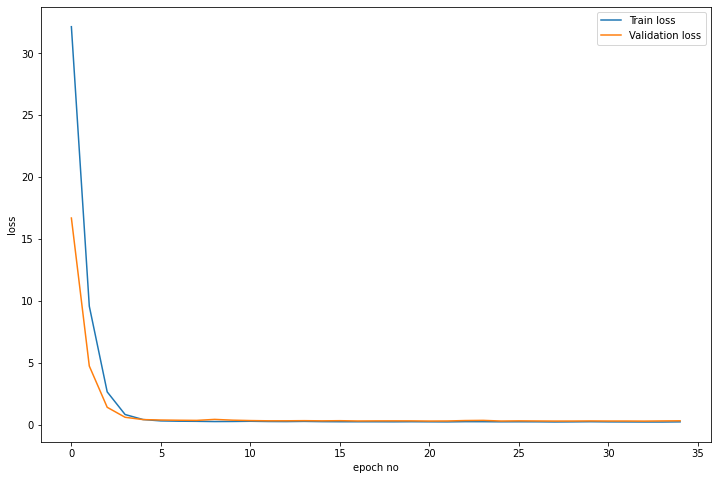

In [23]:
plt.figure(figsize=(12,8))
plt.plot(result.history['loss'],label='Train loss')
plt.plot(result.history['val_loss'],label = 'Validation loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()

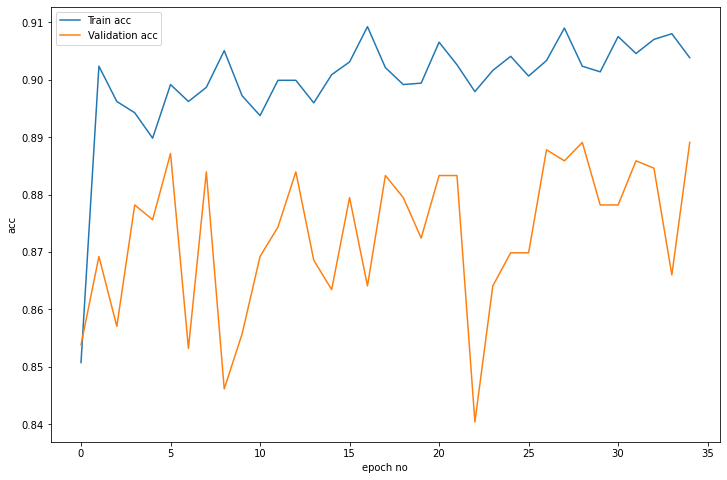

In [18]:
plt.figure(figsize=(12,8))
plt.plot(result.history['accuracy'],label='Train acc')
plt.plot(result.history['val_accuracy'],label = 'Validation acc')
plt.xlabel('epoch no')
plt.ylabel('acc')
plt.legend()
plt.show()

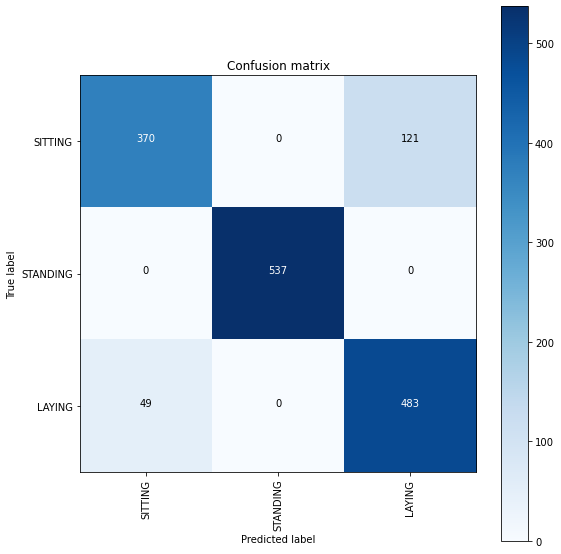

In [26]:
plt.figure(figsize=(8,8))
cm = confusion_matrix_cnn(y_test_static, best_model.predict(X_test_static))
plot_confusion_matrix(cm, classes=['SITTING','STANDING','LAYING'], title='Confusion matrix')
plt.show()

In [27]:
best_model.save('SavedModels/static_classification')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: SavedModels/static_classification\assets


### Dynamic Activities classification

##### Data processing

In [ ]:
def data_dynamic():
  _path_ = 'datasets/raw_signals/'
  raw_signals_trainList = ['body_acc_x_train','body_acc_y_train','body_acc_z_train','body_gyro_x_train','body_gyro_y_train','body_gyro_z_train','total_acc_x_train','total_acc_y_train',
                      'total_acc_z_train']
  raw_signals_testList = ['body_acc_x_test','body_acc_y_test','body_acc_z_test','body_gyro_x_test','body_gyro_y_test','body_gyro_z_test','total_acc_x_test','total_acc_y_test',
                      'total_acc_z_test']
  def load_x(list,path):
    data = []
    for signal in list:
      data.append(pd.read_csv(path+signal+'.txt',delim_whitespace=True, header=None).to_numpy())
    
    return np.transpose(data, (1,2,0))

  def load_y(path, _type_):
    data = pd.read_csv(path + 'y_' + _type_ + '.txt',delim_whitespace=True, header=None)[0]
    tmp = data<=3
    data = data[tmp]
    return pd.get_dummies(data).to_numpy(),tmp

  X_train_dynamic, X_test_dynamic = load_x(raw_signals_trainList, _path_), load_x(raw_signals_testList, _path_)
  y_train_dynamic,tmp1 = load_y(_path_, 'train')
  y_test_dynamic,tmp2 = load_y(_path_,'test')
  X_train_dynamic = X_train_dynamic[tmp1]
  X_test_dynamic = X_test_dynamic[tmp2]
  return X_train_dynamic,y_train_dynamic, X_test_dynamic, y_test_dynamic


In [ ]:
X_train_dynamic,y_train_dynamic,X_test_dynamic,y_test_dynamic = data_dynamic()

In [ ]:
def dynamic_cnn():
  model = Sequential()
  model.add(Conv1D(filters={{choice([28,32,42])}}, kernel_size={{choice([3,5,7])}}, activation='relu',kernel_initializer='he_uniform', kernel_regularizer=l2({{uniform(0,3)}})))
  model.add(Conv1D(filters={{choice([16,24,32])}}, kernel_size={{choice([3,5,7])}}, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2({{uniform(0,2)}})))
  model.add(Dropout({{uniform(0.45,0.7)}}))
  model.add(MaxPooling1D(pool_size={{choice([2,3,5])}}))
  model.add(Flatten())
  model.add(Dense({{choice([16,32,64])}}, activation='relu'))
  model.add(Dense(3, activation='softmax'))
    
  adam = Adam(lr={{uniform(0.00065,0.004)}})
  rmsprop = RMSprop(lr={{uniform(0.00065,0.004)}})
  choiceval = {{choice(['adam', 'rmsprop'])}}
  if choiceval == 'adam':
    optim = adam
  else:
    optim = rmsprop
    
  model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
  model.fit(X_train_dynamic,y_train_dynamic, epochs={{choice([35,40,55])}}, batch_size={{choice([16,32,64])}},verbose=2,validation_data=(X_test_dynamic, y_test_dynamic))
  
  score, acc = model.evaluate(X_test_dynamic, y_test_dynamic, verbose=2)
  print('Test accuracy:', acc)
  return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [ ]:
trials = Trials()
best_run, best_model, space = optim.minimize(model=dynamic_cnn,
                                      data=data_dynamic,
                                      algo=tpe.suggest,
                                      max_evals=100,rseed = 0,                                           
                                      trials=trials,notebook_name='HAR_DL',
                                      return_space = True)

In [ ]:
best_model.summary()

In [ ]:
 _,test_acc = best_model.evaluate(X_test_dynamic,y_test_dynamic,verbose=0)
_,train_acc = best_model.evaluate(X_train_dynamic,y_train_dynamic,verbose=0)
print('Train_accuracy',train_acc,'test_accuracy',test_acc)

In [ ]:
from hyperas.utils import eval_hyperopt_space
total_trials = dict()
for t, trial in enumerate(trials):
        vals = trial.get('misc').get('vals')
        z = eval_hyperopt_space(space, vals)
        total_trials['M'+str(t+1)] = z
best_params = eval_hyperopt_space(space, best_run)
best_params

In [ ]:
def gen_model(space,verbose=1):   
    model = Sequential()
    model.add(Conv1D(filters=space['filters'], kernel_size=space['kernel_size'],activation='relu',
                    kernel_initializer='he_uniform',
                    kernel_regularizer=l2(space['l2']),input_shape=(128,9)))
    model.add(Conv1D(filters=space['filters_1'], kernel_size=space['kernel_size_1'], 
                activation='relu',kernel_regularizer=l2(space['l2_1']),kernel_initializer='he_uniform'))
    model.add(Dropout(space['Dropout']))
    model.add(MaxPooling1D(pool_size=space['pool_size']))
    model.add(Flatten())
    model.add(Dense(space['Dense'], activation='relu'))
    model.add(Dense(3, activation='softmax'))
    adam = Adam(lr=space['lr'])
    rmsprop = RMSprop(lr=space['lr_1'])
    choiceval = space['choiceval']
    if choiceval == 'adam':
        optim = adam
    else:
        optim = rmsprop
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)
    result = model.fit(X_train_dynamic, y_train_dynamic,
                    batch_size=space['Dense_1'],
                    epochs=space['epochs'],
                    verbose=1,
                    validation_data=(X_test_dynamic, y_test_dynamic))
    return model,result

In [ ]:
best_model,result = gen_model(best_params)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(result.history['loss'],label='Train loss')
plt.plot(result.history['val_loss'],label = 'Validation loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(result.history['accuracy'],label='Train acc')
plt.plot(result.history['val_accuracy'],label = 'Validation acc')
plt.xlabel('epoch no')
plt.ylabel('acc')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
cm = confusion_matrix_cnn(y_test_dynamic, best_model.predict(X_test_dynamic))
plot_confusion_matrix(cm, classes=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS'], title='Confusion matrix')
plt.show()

In [ ]:
best_model.save('SavedModels/dynamic_classification')

## Final Classification

In [67]:
def data_final():
  _path_ = 'datasets/raw_signals/'
  activities = {1: 'WALKING',
  2: 'WALKING_UPSTAIRS',
  3: 'WALKING_DOWNSTAIRS',
  4: 'SITTING',
  5: 'STANDING',
  6: 'LAYING'
  }
  raw_signals_trainList = ['body_acc_x_train','body_acc_y_train','body_acc_z_train','body_gyro_x_train','body_gyro_y_train','body_gyro_z_train','total_acc_x_train','total_acc_y_train',
                      'total_acc_z_train']
  raw_signals_testList = ['body_acc_x_test','body_acc_y_test','body_acc_z_test','body_gyro_x_test','body_gyro_y_test','body_gyro_z_test','total_acc_x_test','total_acc_y_test',
                      'total_acc_z_test']
  def load_x(list,path):
    data = []
    for signal in list:
      data.append(pd.read_csv(path+signal+'.txt',delim_whitespace=True, header=None).to_numpy())
    
    return np.transpose(data, (1,2,0))

  def load_y(path, _type_):
    data = pd.read_csv(path + 'y_' + _type_ + '.txt',delim_whitespace=True, header=None)[0]
    return data

  X_train, X_test = load_x(raw_signals_trainList, _path_), load_x(raw_signals_testList, _path_)
  y_train, y_test = load_y(_path_, 'train'), load_y(_path_,'test')
  return X_train,y_train, X_test, y_test

In [68]:
X_train,y_train, X_test, y_test = data_final()

###### Loading trained Models

In [38]:
dynamic_static_classification = load_model('SavedModels/dynamic_static_classification')
dynamic_classification = load_model('SavedModels/dynamic_classification')
static_classification = load_model('SavedModels/static_classification')

In [46]:
predict_2_class = dynamic_static_classification.predict(X_test)
Y_pred_2class =  np.argmax(predict_2_class, axis=1)

In [76]:
def predict(data):
    stage_1_classification = dynamic_static_classification.predict(data)
    stage_1_predictions = np.argmax(stage_1_classification, axis=1)
    
    X_static = data[stage_1_predictions==1]
    X_dynamic = data[stage_1_predictions==0]
    
    stage_2_dynamic = dynamic_classification.predict(X_dynamic)
    stage_2_dynamic_prediction = np.argmax(stage_2_dynamic,axis=1)
    stage_2_dynamic_prediction = stage_2_dynamic_prediction + 1
    
    stage_2_static = static_classification.predict(X_static)
    stage_2_static_prediction = np.argmax(stage_2_static,axis=1)
    stage_2_static_prediction = stage_2_static_prediction + 4
    
    predictions = []
    i,j = 0,0
    for pred in stage_1_predictions:
        if pred == 1:
            predictions.append(stage_2_static_prediction[i])
            i = i + 1
        else:
            predictions.append(stage_2_dynamic_prediction[j])
            j = j + 1 
    return predictions
    
    

In [77]:
test_predictions = predict(X_test)
train_predictions = predict(X_train)

In [104]:
filterr = [t for t in test_predictions if t==1]
len(filterr)

535

In [80]:
print('Train data accuracy',accuracy_score(y_train,train_predictions))
print('Test data accuracy',accuracy_score(y_test,test_predictions))

Train data accuracy 0.9419205658324266
Test data accuracy 0.9233118425517476


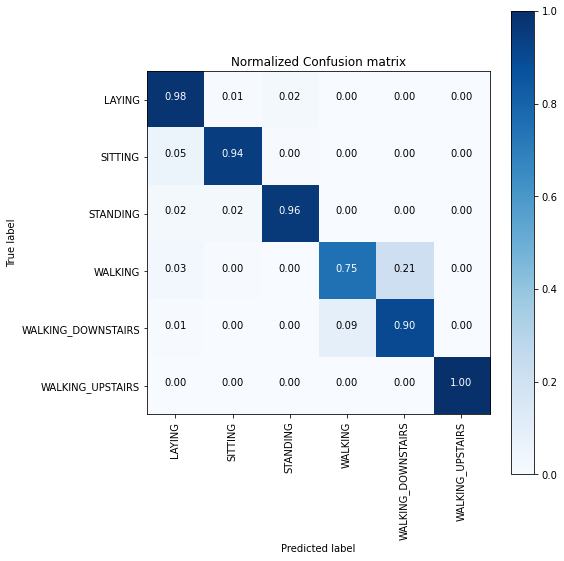

In [106]:
plt.figure(figsize=(8,8))
cm = metrics.confusion_matrix(y_test,test_predictions)
plot_confusion_matrix(cm, classes=labels, title='Normalized Confusion matrix',normalize=True)
plt.show()